In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/FYP'
os.chdir(folder_path)

# !pip install DeepXDE==0.10
!pip install deepxde
!pip install optuna

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 23.3 MB/s eta 0:00:00
Tue Jun 17 22:38:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================

# **Utils file**

In [2]:
import deepxde as dde
import tensorflow as tf
import numpy as np
import pandas as pd

class GlucoseModel:
    def __init__(self, pat, m_t, m_g, m_i, m_d):
        # Store scaling factors
        self.max_t = m_t                          # time max (2880 min)
        self.glucose_scaling = m_g                # max glucose (mg/dL)
        self.insulin_scaling = m_i                # max insulin (U/dL)
        self.digestion_scaling = m_d              # max CHO digestion (mg/dL/min)
        self.filename = f"Pat{pat}.csv"

        self.load_patient_data()
        # self.set_parameters(pat)

        self.min_t = 0
        self.max_t = 2880

        self.generate_inputs_over_time(pat)

        # # Store as tensors for tf.gather in ode()
        # self.insulin_tensor = tf.convert_to_tensor(self.insulin_vector, dtype=tf.float32)
        # self.carb_tensor = tf.convert_to_tensor(self.carb_vector, dtype=tf.float32)
        self.epsilon_causal = 1


    def load_patient_data(self):
        df = pd.read_csv(self.filename)
        self.data_t = df.iloc[0:2880, [0]].values
        self.data_g = df.iloc[0:2880, [2]].values
        self.data_i = df.iloc[0:2880, [3]].values
        self.data_d = df.iloc[0:2880, [5]].values

    def set_parameters(self, pat):
        patient_params = {
            2: {"M": 72, "ksi": 197, "kl": 1.94, "Tu": 122, "ku_Vi": 59e-3, "Tr": 183, "kr_Vb": 2.4e-3, "tend": 48 * 60},
            3: {"M": 94, "ksi": 274, "kl": 1.72, "Tu": 88, "ku_Vi": 62e-3, "Tr": 49, "kr_Vb": 2e-3, "tend": 48 * 60},
            4: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            5: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
            6: {"M": 70, "ksi": 203, "kl": 1.94, "Tu": 118, "ku_Vi": 57e-3, "Tr": 178, "kr_Vb": 2.33e-3, "tend": 48 * 60},
            7: {"M": 97, "ksi": 267, "kl": 1.77, "Tu": 91, "ku_Vi": 60e-3, "Tr": 50, "kr_Vb": 1.94e-3, "tend": 48 * 60},
            8: {"M": 73, "ksi": 200, "kl": 1.92, "Tu": 125, "ku_Vi": 60e-3, "Tr": 182, "kr_Vb": 2.38e-3, "tend": 48 * 60},
            9: {"M": 92, "ksi": 272, "kl": 1.71, "Tu": 87, "ku_Vi": 61e-3, "Tr": 49, "kr_Vb": 2.03e-3, "tend": 48 * 60},
            10: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            11: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
        }

        if pat not in patient_params:
            raise ValueError(f"Unknown patient ID: {pat}")

        params = patient_params[pat]
        self.M = params["M"]
        self.ksi = params["ksi"]
        self.kl = params["kl"]
        self.ku_Vi = params["ku_Vi"]
        self.Tu = params["Tu"]
        self.Tr = params["Tr"]
        self.kr_Vb = params["kr_Vb"]
        self.tend = params["tend"]

        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.Ieq = (self.kl - self.kb) / self.ksi

    def set_inverse_parameters(self, random_init=False):
        patient_params = {
            2: {"M": 72, "ksi": 197, "kl": 1.94, "Tu": 122, "ku_Vi": 59e-3, "Tr": 183, "kr_Vb": 2.4e-3, "tend": 48 * 60},
            3: {"M": 94, "ksi": 274, "kl": 1.72, "Tu": 88, "ku_Vi": 62e-3, "Tr": 49, "kr_Vb": 2e-3, "tend": 48 * 60},
            4: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            5: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
            6: {"M": 70, "ksi": 203, "kl": 1.94, "Tu": 118, "ku_Vi": 57e-3, "Tr": 178, "kr_Vb": 2.33e-3, "tend": 48 * 60},
            7: {"M": 97, "ksi": 267, "kl": 1.77, "Tu": 91, "ku_Vi": 60e-3, "Tr": 50, "kr_Vb": 1.94e-3, "tend": 48 * 60},
            8: {"M": 73, "ksi": 200, "kl": 1.92, "Tu": 125, "ku_Vi": 60e-3, "Tr": 182, "kr_Vb": 2.38e-3, "tend": 48 * 60},
            9: {"M": 92, "ksi": 272, "kl": 1.71, "Tu": 87, "ku_Vi": 61e-3, "Tr": 49, "kr_Vb": 2.03e-3, "tend": 48 * 60},
            10: {"M": 74, "ksi": 191, "kl": 1.94, "Tu": 126, "ku_Vi": 61e-3, "Tr": 188, "kr_Vb": 2.47e-3, "tend": 48 * 60},
            11: {"M": 91, "ksi": 282, "kl": 1.67, "Tu": 85, "ku_Vi": 64e-3, "Tr": 48, "kr_Vb": 2.06e-3, "tend": 48 * 60},
        }

        if pat not in patient_params:
            raise ValueError(f"Unknown patient ID: {pat}")

        params = patient_params[pat]
        self.M = params["M"]
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.kl = params["kl"]
        self.ku_Vi = params["ku_Vi"]
        self.kr_Vb = params["kr_Vb"]
        self.tend = params["tend"]
        self.Tu = params["Tu"]
        self.Tr = params["Tr"]

        # self.ksi = tf.math.exp(tf.Variable(tf.math.log(200.0), dtype=tf.float32, name="ksi"))
        # # self.kl = tf.math.exp(tf.Variable(tf.math.log(1.94), dtype=tf.float32, name="kl"))
        # # self.ku_Vi = tf.math.exp(tf.Variable(tf.math.log(0.06), dtype=tf.float32, name="ku_Vi"))
        # # self.kr_Vb = tf.math.exp(tf.Variable(tf.math.log(0.002), dtype=tf.float32, name="kr_Vb"))
        # self.Tu = tf.math.exp(tf.Variable(tf.math.log(100.0), dtype=tf.float32, name="Tu"))
        # self.Tr = tf.math.exp(tf.Variable(tf.math.log(150.0), dtype=tf.float32, name="Tr"))

        # self.Ieq = (self.kl - self.kb) / self.ksi
        if random_init:
            init_val = np.random.uniform(156.18, 315.62)  # or np.log for log-space
        else:
            init_val = 235.0  # Default midpoint

        self.log_ksi = tf.Variable(tf.math.log(init_val), dtype=tf.float32, name="log_ksi")
        # self.log_ksi = tf.Variable(tf.math.log(220.0), dtype=tf.float32, name="log_ksi")
        # self.log_Tu = tf.Variable(tf.math.log(120.0), dtype=tf.float32, name="log_Tu")
        # self.log_Tr = tf.Variable(tf.math.log(180.0), dtype=tf.float32, name="log_Tr")

        # Use them in the ODE like this:
        ksi = tf.exp(self.log_ksi)
        # Tu = tf.exp(self.log_Tu)
        # Tr = tf.exp(self.log_Tr)

        self.Ieq = (self.kl - self.kb) / ksi

        # self.ksi = params["ksi"]
        # self.kl = params["kl"]
        # self.ku_Vi = params["ku_Vi"]

        # return [self.ksi, self.kl, self.Tu, self.ku_Vi, self.Tr, self.kr_Vb]
        # return [self.log_ksi, self.log_Tu, self.log_Tr]
        return self.log_ksi


    def geometry_time(self):
        return dde.geometry.TimeDomain(self.min_t, self.max_t)

    def generate_input_profiles(t, pat):
        # Input carbohydrates (mg)
        rt = np.zeros_like(t) / 1.0

        if pat == 2:
            rt[t == 24 * 60] = 128.0
            rt[t == 25.5 * 60] = 15.0
            rt[t == 37 * 60] = 150.0
            rt[t == 41 * 60] = 100.0
            rt[t == 42.5 * 60] = 7.5
            rt[t == 44.5 * 60] = 15.0
        elif pat == 3:
            rt[t == 3 * 60] = 15.0
            rt[t == 6 * 60] = 15.0
            rt[t == 7 * 60] = 20.0
            rt[t == 12.5 * 60] = 15.0
            rt[t == 14 * 60] = 15.0
            rt[t == 21 * 60] = 15.0
            rt[t == 23.5 * 60] = 140.0
            rt[t == 27.5 * 60] = 20.0
            rt[t == 29.5 * 60] = 20.0
            rt[t == 32 * 60] = 15.0
            rt[t == 36.5 * 60] = 120.0
            rt[t == 41 * 60] = 95.0
            rt[t == 43 * 60] = 15.0
            rt[t == 44 * 60] = 15.0
            rt[t == 45.5 * 60] = 15.0
            # Patient 4
        elif pat == 4:
            rt[t == 24 * 60] = 124
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 146
            rt[t == 41 * 60] = 103
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 125

            # Patient 5
        elif pat == 5:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 20
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 136
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 116
            rt[t == 41 * 60] = 95
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 6
        elif pat == 6:
            rt[t == 18 * 60] = 132
            rt[t == 25.5 * 60] = 75
            rt[t == 37 * 60] = 150
            rt[t == 41 * 60] = 97
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 129

            # Patient 7
        elif pat == 7:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 19
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 92
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 8
        elif pat == 8:
            rt[t == 17.5 * 60] = 124
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 146
            rt[t == 41 * 60] = 103
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 125

            # Patient 9
        elif pat == 9:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 20
            rt[t == 12.5 * 60] = 15
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 15
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 20
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 95
            rt[t == 43 * 60] = 15
            rt[t == 44 * 60] = 15
            rt[t == 45.5 * 60] = 15

            # Patient 10
        elif pat == 10:
            rt[t == 24 * 60] = 132
            rt[t == 25.5 * 60] = 15
            rt[t == 37 * 60] = 150
            rt[t == 41 * 60] = 97
            rt[t == 42.5 * 60] = 8
            rt[t == 44.5 * 60] = 15
            rt[t == 48 * 60] = 129

            # Patient 11
        elif pat == 11:
            rt[t == 6 * 60] = 15
            rt[t == 3 * 60] = 15
            rt[t == 7 * 60] = 19
            rt[t == 12.5 * 60] = 65
            rt[t == 14 * 60] = 15
            rt[t == 21 * 60] = 80
            rt[t == 23.5 * 60] = 140
            rt[t == 27.5 * 60] = 20
            rt[t == 29.5 * 60] = 87
            rt[t == 32 * 60] = 15
            rt[t == 36.5 * 60] = 120
            rt[t == 41 * 60] = 92
            rt[t == 43 * 60] = 45
            rt[t == 44 * 60] = 45
            rt[t == 45.5 * 60] = 55

        rt = rt * 1000

        # Input insulin (U)
        ut = np.ones_like(t) / 60
            # Patient 2
        if pat == 2:
            ut = np.ones_like(t) / 60
            ut[((t >= 60) & (t <= 11 * 60)) | ((t >= 47 * 60) & (t <= 48 * 60))] = 0.8/60
            ut[t == 7.5 * 60] += 0.5
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 22
            ut[t == 37 * 60] += 18
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 16
            ut[t == 48 * 60] += 19


        # Patient 3
        elif pat == 3:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.5 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.6 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.2 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.6 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.4 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1 / 60
            ut[t == 24 * 60] += 19
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 4
        elif pat == 4:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.49
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 21
            ut[t == 37 * 60] += 17
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 16
            ut[t == 48 * 60] += 18

        # Patient 5
        elif pat == 5:
            ut = np.ones_like(t) * 1.2 / 60
            ut[t == 24 * 60] += 18
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 6
        elif pat == 6:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.7 / 60
            ut[t == 7.5 * 60] += 0.52
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 17
            ut[t == 37 * 60] += 15
            ut[t == 37.5 * 60] += 13
            ut[t == 42.5 * 60] += 12
            ut[t == 48 * 60] += 5

        # Patient 7
        elif pat == 7:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
            ut[t == 24 * 60] += 20
            ut[t == 36.5 * 60] += 11
            ut[t == 37 * 60] += 11
            ut[t == 41 * 60] += 10

        # Patient 8
        elif pat == 8:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.49
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 18
            ut[t == 37 * 60] += 17
            ut[t == 37.5 * 60] += 17
            ut[t == 42.5 * 60] += 10
            ut[t == 48 * 60] += 10
        # Patient 9
        elif pat == 9:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.46 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.55 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.16 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.55 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.35 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 0.97 / 60
            ut[t == 24 * 60] += 18
            ut[t == 36.5 * 60] += 10
            ut[t == 37 * 60] += 10
            ut[t == 41 * 60] += 10

        # Patient 10
        elif pat == 10:
            ut[(t >= 60) & (t <= 11 * 60) | (t >= 47 * 60) & (t <= 48 * 60)] = 0.8 / 60
            ut[t == 7.5 * 60] += 0.52
            ut[t == 12.5 * 60] += 2
            ut[t == 17 * 60] += 2
            ut[t == 24 * 60] += 23
            ut[t == 37 * 60] += 18
            ut[t == 37.5 * 60] += 18
            ut[t == 42.5 * 60] += 17
            ut[t == 48 * 60] += 20

        # Patient 11
        elif pat == 11:
            ut = np.ones_like(t) * 2 / 60
            ut[(t >= 4 * 60) & (t < 8 * 60)] = 1.55 / 60
            ut[(t >= 22 * 60) & (t < 28 * 60)] = 1.65 / 60
            ut[(t >= 28 * 60) & (t < 34 * 60)] = 1.24 / 60
            ut[(t >= 34 * 60) & (t < 38 * 60)] = 1.65 / 60
            ut[(t >= 38 * 60) & (t < 46 * 60)] = 1.45 / 60
            ut[(t >= 46 * 60) & (t < 50 * 60)] = 1.03 / 60
            ut[t == 24 * 60] += 20
            ut[t == 36.5 * 60] += 11
            ut[t == 37 * 60] += 11
            ut[t == 41 * 60] += 10

        return ut, rt

    def generate_inputs_over_time(self, pat):
        """
        Precompute ut and rt over the entire simulation time vector for fast lookup.
        """
        t_vals = np.arange(self.min_t, self.max_t + 1).astype(float)  # in minutes
        ut, rt = GlucoseModel.generate_input_profiles(t_vals, pat)

        # --- Normalize by max values ---
        max_ut = np.max(ut)
        max_rt = np.max(rt)

        self.u_scaling = max_ut if max_ut != 0 else 1.0  # avoid divide-by-zero
        self.r_scaling = max_rt if max_rt != 0 else 1.0

        ut_normalized = ut #/ self.u_scaling
        rt_normalized = rt #/ self.r_scaling

        self.time_vector = t_vals
        self.insulin_vector = tf.convert_to_tensor(ut_normalized, dtype=tf.float32)
        self.carb_vector = tf.convert_to_tensor(rt_normalized, dtype=tf.float32)


    def lookup_inputs(self, t):
        """
        Fast u(t), r(t) lookup from precomputed vectors. Input t is scalar.
        """
        idx = int(t)
        if 0 <= idx < len(self.insulin_vector):
            return self.insulin_vector[idx], self.carb_vector[idx]
        return 0.0, 0.0

    def ode(self, x, y):

        if inverse_activated:
            ksi = tf.exp(self.log_ksi)
        else:
            ksi = self.ksi

        # Tu = tf.exp(self.log_Tu)
        # Tr = tf.exp(self.log_Tr)

        # === Lookup inputs ===
        t_real = tf.cast(x[:, 0:1] * tf.cast(self.max_t, tf.float32), tf.float32)
        idx = tf.cast(tf.round(t_real), tf.int32)
        idx = tf.clip_by_value(idx, 0, tf.shape(self.insulin_vector)[0] - 1)

        ut = tf.gather(self.insulin_vector, idx) #* self.u_scaling
        rt = tf.gather(self.carb_vector, idx) #* self.r_scaling


        # === Denormalise outputs ===
        G = y[:, 0:1] * self.glucose_scaling
        I = y[:, 1:2] * self.insulin_scaling
        D = y[:, 2:3] * self.digestion_scaling

        dG_dt = dde.grad.jacobian(y, x, i=0, j=0) * self.glucose_scaling / self.max_t
        dI_dt = dde.grad.jacobian(y, x, i=1, j=0) * self.insulin_scaling / self.max_t
        dD_dt = dde.grad.jacobian(y, x, i=2, j=0) * self.digestion_scaling / self.max_t

        d2I_dt2 = dde.grad.hessian(y, x, component=1, i=0, j=0) * self.insulin_scaling / self.max_t**2
        d2D_dt2 = dde.grad.hessian(y, x, component=2, i=0, j=0) * self.digestion_scaling / self.max_t**2

        # === Physics-informed ODEs ===
        eq_1 = (dG_dt - (-ksi * I + self.kl - self.kb + D)) / 100
        eq_2 = (d2I_dt2 + (2 / self.Tu) * dI_dt + (1 / self.Tu ** 2) * I - ut * (self.ku_Vi / self.Tu ** 2)) / 0.1
        eq_3 = (d2D_dt2 + (2 / self.Tr) * dD_dt + (1 / self.Tr ** 2) * D - rt * (self.kr_Vb / self.Tr ** 2)) / 5.0

        # === Add soft prior loss on ksi (e.g., prior mean 200, std 80) ===
        prior_mean = 220.0
        prior_std = 60.0
        prior_weight = 1e-5  # Adjust to control how "strong" the prior is

        prior_loss = prior_weight * tf.square((ksi - prior_mean) / prior_std)

        # Broadcast to match output format
        prior_residual = tf.ones_like(eq_1) * prior_loss

        # Return residuals including prior as extra component
        # return [eq_1, eq_2, eq_3, prior_residual]
        return [eq_1, eq_2, eq_3]

        # # === Residual vector and norm ===
        # residual_vector = tf.concat([eq_1, eq_2, eq_3], axis=1)  # shape: [batch_size, 3]
        # residual_norm_sq = tf.reduce_sum(tf.square(residual_vector), axis=1, keepdims=True)  # shape: [batch_size, 1]

        # # === Cumulative sum (causal weighting logic) ===
        # residual_cumsum = tf.stop_gradient(tf.cumsum(residual_norm_sq, axis=0, exclusive=True))
        # causal_weights = tf.exp(-self.epsilon_causal * residual_cumsum)  # shape: [batch_size, 1]

        # # === Apply causal weights to raw residuals ===
        # weighted_eq_1 = causal_weights * eq_1
        # weighted_eq_2 = causal_weights * eq_2
        # weighted_eq_3 = causal_weights * eq_3

        # return [weighted_eq_1, weighted_eq_2, weighted_eq_3]



No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [3]:
import tensorflow as tf
from deepxde.nn import NN


class ModifiedMLP(NN):
    def __init__(self, layers, activation="tanh", initializer="glorot_uniform"):
        super().__init__()
        self.layers = layers
        self.activation = getattr(tf.nn, activation)
        self.initializer = tf.keras.initializers.get(initializer)

        self._input_transform = None
        self._output_transform = None

        # Layers
        self.U_encoder = tf.keras.layers.Dense(
            layers[1], activation=self.activation, kernel_initializer=self.initializer
        )
        self.V_encoder = tf.keras.layers.Dense(
            layers[1], activation=self.activation, kernel_initializer=self.initializer
        )
        self.H_layers = [
            tf.keras.layers.Dense(
                layers[1], activation=self.activation, kernel_initializer=self.initializer
            )
            for _ in range(len(layers) - 3)
        ]
        self.Z_layers = [
            tf.keras.layers.Dense(
                layers[1], activation="sigmoid", kernel_initializer=self.initializer
            )
            for _ in range(len(layers) - 3)
        ]
        self.output_layer = tf.keras.layers.Dense(
            layers[-1], activation=None, kernel_initializer=self.initializer
        )

    def apply_feature_transform(self, transform):
        self._input_transform = transform

    def apply_output_transform(self, transform):
        self._output_transform = transform

    @property
    def inputs(self):
        return self.x

    @property
    def outputs(self):
        return self.y

    @property
    def targets(self):
        return self.y_

    def build(self):
        print("Building Modified MLP with tf.compat.v1 backend...")

        self.x = tf.compat.v1.placeholder(tf.float32, [None, self.layers[0]])
        self.y_ = tf.compat.v1.placeholder(tf.float32, [None, self.layers[-1]])

        inputs = self.x
        if self._input_transform is not None:
            inputs = self._input_transform(inputs)

        # Encoding path
        U = self.U_encoder(inputs)
        V = self.V_encoder(inputs)

        # Mixing path
        H = inputs
        for H_layer, Z_layer in zip(self.H_layers, self.Z_layers):
            Z = Z_layer(H)
            H = (1.0 - Z) * U + Z * V
            H = H_layer(H)

        outputs = self.output_layer(H)

        if self._output_transform is not None:
            outputs = self._output_transform(inputs, outputs)

        self.y = outputs
        self.built = True


# **PINN Model (interpolation)**

In [4]:
# PINN model
import sys
import os
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pandas as pd
import deepxde as dde # version 0.11 or higher
from deepxde.backend import tensorflow as tf
from deepxde.callbacks import VariableValue
import tensorflow as tf  # Import TensorFlow separately
import ast
import random

from sklearn.decomposition import PCA
import seaborn as sns


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
    tf.compat.v1.set_random_seed(seed)
    global random_seed
    random_seed = seed

seed=1204
set_random_seed(seed)
dde.config.set_random_seed(seed)

## Input variables
pat = 2
scale = 'max'        # 'z-score' or 'max'
loss_term = 'g_only' # 'g_only' or 'all'
ini_con = 'hard'     # 'soft' or 'hard' initial conditions
fourier = False     # 'True' or 'False'

## Network Parameters
input_size = 1  # network input size (time as 1D but input vector of size 5)
num_hidden_layers = 3  # number of hidden layers for NN
hidden_layer_size = 32  # size of each hidden layer
output_size = 3  # network output size

## Training Parameters
num_domain = 3000  # number of training points within the domain
num_test = 1000  # number of testing points within the domain
num_initial = 1  # number of points to test the initial conditions
epochs = 25000  # number of epochs for training
lr = 5e-5  # learning rate
noise = 0.5  # noise factor
test_size = 0.1  # percentage of testing data

dim = 1  # Ensure dimension is set to
noise_introduced = False
inverse_activated = True
causal = False


## Load the physical model
filename = f"Pat{pat}.csv"
df = pd.read_csv(filename)

# Assign columns to data_t and data_g as matrices (DataFrames)
data_t = df.iloc[0:2880, [0]].values  # Column 1 = time points
data_g = df.iloc[0:2880, [2]].values  # Column 3 = glucose
data_i = df.iloc[0:2880, [3]].values  # Column 4 = insulin
data_d = df.iloc[0:2880, [5]].values  # Column 6 = carbs

m_t = data_t.max()
data_t_normalised = data_t / m_t

if scale == 'max':
  m_g = data_g.max()
  m_i = data_i.max()
  m_d = data_d.max()

  data_g_normalised = data_g / m_g
  data_i_normalised = data_i / m_i
  data_d_normalised = data_d / m_d

elif scale == 'z-score':
  m_g = data_g.mean()
  m_i = data_i.mean()
  m_d = data_d.mean()

  sig_g = data_g.std()
  sig_i = data_i.std()
  sig_d = data_d.std()

  data_g_normalised = (data_g - m_g) / sig_g
  data_i_normalised = (data_i - m_i) / sig_i
  data_d_normalised = (data_d - m_d) / sig_d

glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
if inverse_activated:
    inverse_params = glucosemodel.set_inverse_parameters()
else:
    params = glucosemodel.set_parameters(pat)

def calculate_rmse(true_values, predicted_values):
    """Calculate Root Mean Square Error (RMSE)."""
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

def calculate_mae(true_values, predicted_values):
    """Calculate Mean Absolute Error (MAE)."""
    return np.mean(np.abs(true_values - predicted_values))

def calculate_gof(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan


print(f"Norm Glucose Data Sample: {data_g_normalised[:5]}")
print(f"Norm Insulin Data Sample: {data_i_normalised[:5]}")
print(f"Norm Carbs Data Sample: {data_d_normalised[:5]}")

data_t_normalised_df = pd.DataFrame(data_t_normalised, columns=["time_normalized"])
print("\nNormalized Time Values:")
print(data_t_normalised_df)

#For the moment the training set is too small because I wanted to guarantee that t0 would be in t_train, have to rewrite

# 1. Extract first point (for IC) and remaining points
first_t, first_g, first_i, first_d = (
    data_t_normalised[0],
    data_g_normalised[0],
    data_i_normalised[0],
    data_d_normalised[0],
)

remaining_t = data_t_normalised[1:]
remaining_g = data_g_normalised[1:]
remaining_i = data_i_normalised[1:]
remaining_d = data_d_normalised[1:]

# 2. Split remaining into interpolation and forecast blocks
split_index = int(0.5 * len(remaining_t))
t_interp = remaining_t[:split_index]
g_interp = remaining_g[:split_index]
i_interp = remaining_i[:split_index]
d_interp = remaining_d[:split_index]

t_forecast = remaining_t[split_index:]
g_forecast = remaining_g[split_index:]
i_forecast = remaining_i[split_index:]
d_forecast = remaining_d[split_index:]

# 3. Apply mask to interpolation block
mask = np.ones(len(t_interp), dtype=bool)
mask[::10] = False

t_train_interp = t_interp[mask]
g_train_interp = g_interp[mask]
i_train_interp = i_interp[mask]
d_train_interp = d_interp[mask]

t_test_interp = t_interp[~mask]
g_test_interp = g_interp[~mask]
i_test_interp = i_interp[~mask]
d_test_interp = d_interp[~mask]

# 4. Add first point explicitly to train set
t_train = np.concatenate([[first_t], t_train_interp])
g_train = np.concatenate([[first_g], g_train_interp])
i_train = np.concatenate([[first_i], i_train_interp])
d_train = np.concatenate([[first_d], d_train_interp])

# 5. Reshape to column vectors
t_train = t_train.reshape(-1, 1)
g_train = g_train.reshape(-1, 1)
i_train = i_train.reshape(-1, 1)
d_train = d_train.reshape(-1, 1)


#Intial conditions
func_init = [first_g, first_i, first_d]

## Geometry and Time domains
geomtime = glucosemodel.geometry_time()

# if noise_introduced:
#     g_train = g_train + noise*np.random.randn(g_train.shape[0], g_train.shape[1])

def boundary(_, on_initial):
    return on_initial

## Define Initial Conditions: Keeping only the initial condition for patient 2 for simplicity
ic_g = dde.IC(geomtime, lambda x: func_init[0], boundary, component=0)
ic_i = dde.IC(geomtime, lambda x: func_init[1], boundary, component=1)
ic_d = dde.IC(geomtime, lambda x: func_init[2], boundary, component=2)

 ## Model observed data
observe_g = dde.PointSetBC(t_train, g_train, component=0)
observe_i = dde.PointSetBC(t_train, i_train, component=1)
observe_d = dde.PointSetBC(t_train, d_train, component=2)

## Assign input data and loss weights based on selected training parameters
if loss_term == 'g_only' and ini_con == 'soft':
    input_data = [observe_g, ic_g, ic_i, ic_d]
if loss_term == 'g_only' and ini_con == 'hard':
    input_data = [observe_g]
if loss_term == 'all' and ini_con == 'soft':
    input_data = [observe_g, observe_i, observe_d, ic_g, ic_i, ic_d]
if loss_term == 'all' and ini_con == 'hard':
    input_data = [observe_g, observe_i, observe_d]

## Define the Network

def train_model_causally(
    glucosemodel,
    t_train,
    g_train,
    i_train,
    d_train,
    loss_term="g_only",
    num_hidden_layers=5,
    hidden_layer_size=32,
    input_size=1,
    output_size=3,
    causal_window=200,
    lr=5e-5,
    epochs_per_chunk=5000,
    fourier=True,
    ini_con="hard",
    func_init=[g_train[0], i_train[0], d_train[0]],  # Default ICs for G, I, D
    m_t= m_t,
    save_path=None,
):
    # Split training set into chunks
    T_total = len(t_train)
    t_chunks = [t_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    g_chunks = [g_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    i_chunks = [i_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    d_chunks = [d_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(y[:, 0:1] * tf.tanh(t) + func_init[0]),  # Glucose
            tf.nn.relu(y[:, 1:2] * tf.tanh(t) + func_init[1]),  # Insulin
            tf.nn.relu(y[:, 2:3] * tf.tanh(t) + func_init[2])   # Digestion
        ], axis=1))

    # Initial state: first glucose value + estimates
    initial_state = func_init

    for k in range(len(t_chunks)):
        t_seg, g_seg, i_seg, d_seg = t_chunks[k], g_chunks[k], i_chunks[k], d_chunks[k]

        t_start_k = float(t_seg[0].item())
        t_end_k = float(t_seg[-1].item())
        geom_k = dde.geometry.TimeDomain(t_start_k, t_end_k)

        # Apply new output transform for this chunk using current initial state
        net.apply_output_transform(lambda t, y, s=initial_state: tf.concat([
            tf.nn.relu(y[:, 0:1] * tf.tanh(t) + s[0]),
            tf.nn.relu(y[:, 1:2] * tf.tanh(t) + s[1]),
            tf.nn.relu(y[:, 2:3] * tf.tanh(t) + s[2]),
        ], axis=1))

        def boundary(_, on_initial):
            return on_initial

        ic_g = dde.IC(geom_k, lambda x: float(initial_state[0]), boundary, component=0)
        ic_i = dde.IC(geom_k, lambda x: float(initial_state[1]), boundary, component=1)
        ic_d = dde.IC(geom_k, lambda x: float(initial_state[2]), boundary, component=2)

        obs_g = dde.PointSetBC(t_seg, g_seg, component=0)

        if loss_term == "g_only":
            input_data = [obs_g]
        else:
            obs_i = dde.PointSetBC(t_seg, i_seg, component=1)
            obs_d = dde.PointSetBC(t_seg, d_seg, component=2)
            input_data = [obs_g, obs_i, obs_d, ic_g, ic_i, ic_d]

        ode_data_k = dde.data.PDE(geom_k, glucosemodel.ode, input_data, num_domain=len(t_seg), anchors=t_seg)

        model_k = dde.Model(ode_data_k, net)
        model_k.compile("adam", lr=lr)
        model_k.train(epochs=epochs_per_chunk)

        # Update initial_state for the next chunk
        y_pred = model_k.predict(t_seg)
        initial_state = [float(v) for v in y_pred[-1]]

    return net, model_k


ode = glucosemodel.ode
# net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")
net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])




Norm Glucose Data Sample: [[1.        ]
 [1.        ]
 [0.99999999]
 [0.99999996]
 [0.9999999 ]]
Norm Insulin Data Sample: [[0.11422356]
 [0.11422438]
 [0.11422666]
 [0.11423038]
 [0.11423552]]
Norm Carbs Data Sample: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Normalized Time Values:
      time_normalized
0            0.000000
1            0.000347
2            0.000695
3            0.001042
4            0.001389
...               ...
2875         0.998611
2876         0.998958
2877         0.999305
2878         0.999653
2879         1.000000

[2880 rows x 1 columns]


In [5]:
if causal:
    net, model = train_model_causally(
        glucosemodel=glucosemodel,
        t_train=t_train,
        g_train=g_train,
        i_train=i_train,
        d_train=d_train,
        loss_term=loss_term,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        input_size=input_size,
        output_size=output_size,
        causal_window=300,  # You can adjust this
        lr=lr,
        epochs_per_chunk=2000,
        fourier=fourier,
        ini_con=ini_con,
        func_init=[g_train[0], i_train[0], d_train[0]],  # First G, default I, D
        m_t=m_t,
        save_path="causal_trained_net"
    )

else:

    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
            tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
            tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
        ], axis=1))

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    ode_data = dde.data.PDE(geomtime, ode, input_data,
                            num_domain=num_domain,
                            anchors=t_train,
                            num_test=num_test)

    model = dde.Model(ode_data, net)

    if inverse_activated:
        inverse_params = glucosemodel.set_inverse_parameters(random_init=False)

        # print("\n===== Stage 1: Train inverse parameters only =====")
        # model.compile("adam", lr=1e-3, loss_weights=[1.0, 0.0, 0.0, 0.0], external_trainable_variables=inverse_params)
        # stage1_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage1.dat")
        # losshistory1, train_state1 = model.train(epochs=5000, display_every=500, callbacks=[stage1_logger])

        # print("\n===== Stage 2: Train NN weights only =====")
        # model.compile("adam", lr=5e-4, loss_weights=[7.5, 0.9, 0.18, 4.6])  # no external vars now
        # stage2_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage2.dat")
        # losshistory2, train_state2 = model.train(epochs=8000, display_every=500, callbacks=[stage2_logger])

        # print("\n===== Stage 3: Joint fine-tuning =====")
        # model.compile("adam", lr=2e-4, loss_weights=[7.5, 0.9, 0.18, 4.6], external_trainable_variables=inverse_params)
        # stage3_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage3.dat")
        # losshistory3, train_state3 = model.train(epochs=2000, display_every=500, callbacks=[stage3_logger])

        print("\n===== Standard PINN training =====")
        model.compile("adam", lr=5e-5, loss_weights=[7.5, 0.9, 0.18, 4.6])
        stage_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage.dat")
        losshistory, train_state = model.train(epochs=epochs, display_every=1000, callbacks=[stage_logger])

    else:
        print("\n===== Standard PINN training =====")
        model.compile("adam", lr=lr, loss_weights=[5.973894046609318, 4.702928213908855, 2.7116368037902543, 3.3211698223093755])
        losshistory, train_state = model.train(epochs=epochs, display_every=1000)



# loss_weights[0]	Loss for Glucose Initial Condition (IC)
# loss_weights[1]	Loss for Insulin Initial Condition (IC)
# loss_weights[2]	Loss for Carbohydrate Initial Condition (IC)
# loss_weights[3]	Loss for PDE governing Glucose dynamics
# loss_weights[4]	Loss for PDE governing Insulin dynamics
# loss_weights[5]	Loss for PDE governing Carbohydrate dynamics
# loss_weights[6]	Loss for Glucose Observations (observe_g)
# loss_weights[7]	Loss for Insulin Observations (observe_i)
# loss_weights[8] Loss for Carbohydrate Observations (observe_d)


#L-BFGS-B refinement
    model.compile("L-BFGS-B")
    model.train()



# # Plot loss history
# loss_train = np.sum(losshistory.loss_train, axis=1)
# loss_test = np.sum(losshistory.loss_test, axis=1)

# # Plot Glucose Loss History
# plt.figure(figsize=(10, 6))
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 0], label="Train Loss (Glucose)", linewidth=2, color="blue")
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 0], label="Test Loss (Glucose)", linewidth=2, color="red")
# plt.title("Loss History - Glucose")
# plt.xlabel("Steps")
# plt.ylabel("Loss (log scale)")
# plt.legend()
# plt.grid(True)
# plt.savefig("Loss_History_Glucose.png")
# plt.show()

# # Plot Insulin Loss History
# plt.figure(figsize=(10, 6))
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 1], label="Train Loss (Insulin)", linewidth=2, color="blue")
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 1], label="Test Loss (Insulin)", linewidth=2, color="red")
# plt.title("Loss History - Insulin")
# plt.xlabel("Steps")
# plt.ylabel("Loss (log scale)")
# plt.legend()
# plt.grid(True)
# plt.savefig("Loss_History_Insulin.png")
# plt.show()

# # Plot Carbohydrate Digestion Loss History
# plt.figure(figsize=(10, 6))
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 2], label="Train Loss (Carbs)", linewidth=2, color="blue")
# plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 2], label="Test Loss (Carbs)", linewidth=2, color="red")
# plt.title("Loss History - Carbohydrate Digestion")
# plt.xlabel("Steps")
# plt.ylabel("Loss (log scale)")
# plt.legend()
# plt.grid(True)
# plt.savefig("Loss_History_Carbs.png")
# plt.show()


## Compute rMSE for testing data & all (training + testing)
# === INTERPOLATION SEGMENT ===

# Train RMSE on training points (including first point)
G_pred_train = model.predict(t_train)[:, 0:1]
I_pred_train = model.predict(t_train)[:, 1:2]
D_pred_train = model.predict(t_train)[:, 2:3]

rmse_G_train_interp = np.sqrt(np.square(G_pred_train - g_train).mean())
rmse_I_train_interp = np.sqrt(np.square(I_pred_train - i_train).mean())
rmse_D_train_interp = np.sqrt(np.square(D_pred_train - d_train).mean())

# Test RMSE on test points
G_pred_interp_test = model.predict(t_test_interp)[:, 0:1]
I_pred_interp_test = model.predict(t_test_interp)[:, 1:2]
D_pred_interp_test = model.predict(t_test_interp)[:, 2:3]

rmse_G_interp_test = np.sqrt(np.square(G_pred_interp_test - g_test_interp).mean())
rmse_I_interp_test = np.sqrt(np.square(I_pred_interp_test - i_test_interp).mean())
rmse_D_interp_test = np.sqrt(np.square(D_pred_interp_test - d_test_interp).mean())

# Full RMSE on all interpolation points (train + test combined)
t_full_interp = np.concatenate([t_train, t_test_interp])
g_full_interp = np.concatenate([g_train, g_test_interp])
i_full_interp = np.concatenate([i_train, i_test_interp])
d_full_interp = np.concatenate([d_train, d_test_interp])

G_pred_full_interp = model.predict(t_full_interp)[:, 0:1]
I_pred_full_interp = model.predict(t_full_interp)[:, 1:2]
D_pred_full_interp = model.predict(t_full_interp)[:, 2:3]

rmse_G_full_interp = np.sqrt(np.square(G_pred_full_interp - g_full_interp).mean())
rmse_I_full_interp = np.sqrt(np.square(I_pred_full_interp - i_full_interp).mean())
rmse_D_full_interp = np.sqrt(np.square(D_pred_full_interp - d_full_interp).mean())

# === FORECAST SEGMENT ===
G_pred_forecast = model.predict(t_forecast)[:, 0:1]
I_pred_forecast = model.predict(t_forecast)[:, 1:2]
D_pred_forecast = model.predict(t_forecast)[:, 2:3]

rmse_G_forecast = np.sqrt(np.square(G_pred_forecast - g_forecast).mean())
rmse_I_forecast = np.sqrt(np.square(I_pred_forecast - i_forecast).mean())
rmse_D_forecast = np.sqrt(np.square(D_pred_forecast - d_forecast).mean())

# === PRINT RESULTS ===
print('--------------------------')
print('INTERPOLATION SEGMENT (first 80%)')
print('G rMSE (train points):', rmse_G_train_interp)
print('G rMSE (test points):', rmse_G_interp_test)
print('G rMSE (full segment):', rmse_G_full_interp)
print('I rMSE (train points):', rmse_I_train_interp)
print('I rMSE (test points):', rmse_I_interp_test)
print('I rMSE (full segment):', rmse_I_full_interp)
print('D rMSE (train points):', rmse_D_train_interp)
print('D rMSE (test points):', rmse_D_interp_test)
print('D rMSE (full segment):', rmse_D_full_interp)
print('--------------------------')
print('FORECAST SEGMENT (last 20%)')
print('G rMSE (forecast):', rmse_G_forecast)
print('I rMSE (forecast):', rmse_I_forecast)
print('D rMSE (forecast):', rmse_D_forecast)
print('--------------------------')


# print("\nEstimated Parameters:")
# print("ksi =", glucosemodel.ksi)
# print("kl =", glucosemodel.kl)
# print("ku_Vi =", glucosemodel.ku_Vi)


# # === SENSITIVITY ANALYSIS BLOCK ===
# sensitivity_results = []
# perturbation_fraction = 0.5  # ±10%

# # Get original parameters
# baseline_params = {
#     "ksi": glucosemodel.ksi,
#     "kl": glucosemodel.kl,
#     "ku_Vi": glucosemodel.ku_Vi,
#     "Tr": glucosemodel.Tr,
#     "Tu": glucosemodel.Tu,
#     "kr_Vb": glucosemodel.kr_Vb,
# }

# # Function to run model and return final glucose RMSE
# def run_and_get_glucose_rmse(glucosemodel, t_train, g_train, t_test_interp, g_test_interp):
#     geomtime = glucosemodel.geometry_time()
#     ode = glucosemodel.ode
#     net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")

#     if ini_con == 'hard':
#         net.apply_output_transform(lambda t, y: tf.concat([
#             tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
#             tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
#             tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
#         ], axis=1))

#     if fourier:
#         net.apply_feature_transform(lambda t: tf.concat(
#             [t * m_t] +
#             [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
#             [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
#             axis=1
#         ))

#     ode_data = dde.data.PDE(geomtime, ode, input_data,
#                             num_domain=num_domain,
#                             anchors=t_train,
#                             num_test=num_test)

#     model = dde.Model(ode_data, net)
#     model.compile("adam", lr=lr)
#     model.train(epochs=epochs, display_every=1000)

#     g_pred_test = model.predict(t_test_interp)[:, 0:1]
#     rmse_g = np.sqrt(np.square(g_pred_test - g_test_interp).mean())
#     return rmse_g


# # Baseline RMSE
# glucosemodel.set_parameters(pat)  # Reset
# baseline_rmse = run_and_get_glucose_rmse(glucosemodel, t_train, g_train, t_test_interp, g_test_interp)

# # Perturb each param
# for param_name, base_value in baseline_params.items():
#     for direction in ["plus", "minus"]:
#         new_val = base_value * (1 + perturbation_fraction) if direction == "plus" else base_value * (1 - perturbation_fraction)

#         # Reset and set modified param
#         glucosemodel.set_parameters(pat)
#         setattr(glucosemodel, param_name, new_val)

#         # Run and evaluate
#         rmse_g = run_and_get_glucose_rmse(glucosemodel, t_train, g_train, t_test_interp, g_test_interp)
#         sensitivity_results.append({
#             "param": param_name,
#             "direction": direction,
#             "original": base_value,
#             "perturbed": new_val,
#             "rmse": rmse_g,
#             "delta_rmse": rmse_g - baseline_rmse
#         })

# # === Output Results ===
# results_df = pd.DataFrame(sensitivity_results)
# print("\nSensitivity Analysis (Glucose RMSE Change):")
# print(results_df[["param", "direction", "original", "perturbed", "rmse", "delta_rmse"]])




===== Standard PINN training =====
Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.844101 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.03e-04, 3.55e-07, 0.00e+00, 2.73e-01]    [2.90e-04, 5.08e-07, 0.00e+00, 2.73e-01]    []  
1000      [6.00e-06, 3.56e-07, 2.15e-17, 1.30e-02]    [2.06e-07, 5.11e-07, 0.00e+00, 1.30e-02]    []  
2000      [5.90e-06, 3.56e-07, 7.29e-16, 2.20e-03]    [1.95e-07, 5.11e-07, 0.00e+00, 2.20e-03]    []  
3000      [4.10e-06, 3.56e-07, 1.86e-15, 1.67e-03]    [2.25e-07, 5.11e-07, 0.00e+00, 1.67e-03]    []  
4000      [2.36e-06, 3.56e-07, 4.20e-15, 7.59e-04]    [2.37e-07, 5.11e-07, 0.00e+00, 7.59e-04]    []  
5000      [1.57e-06, 3.56e-07, 9.08e-15, 1.43e-04]    [2.40e-07, 5.11e-07, 0.00e+00, 1.43e-04]    []  
6000      [7.92e-07, 3.56e-07, 1.87e-14, 4.08e-05]    [2.31e-07, 5.11e-07, 0.00e+00, 4.08e-05]    []  
7000      [3.58e-

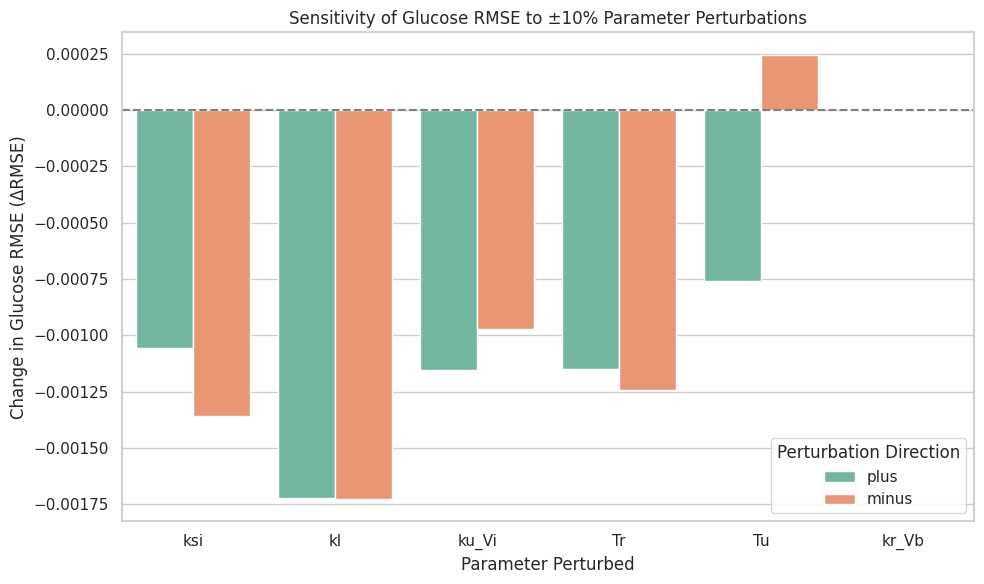

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Clean plotting style ---
sns.set(style="whitegrid")

# Convert to DataFrame (if not already)
results_df = pd.DataFrame(sensitivity_results)

# Sort for consistent plotting order
param_order = results_df["param"].unique()

# Plot delta RMSE grouped by parameter and direction
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="param",
    y="delta_rmse",
    hue="direction",
    order=param_order,
    palette="Set2"
)

plt.axhline(0, color="gray", linestyle="--")
plt.title("Sensitivity of Glucose RMSE to ±10% Parameter Perturbations")
plt.ylabel("Change in Glucose RMSE (ΔRMSE)")
plt.xlabel("Parameter Perturbed")
plt.legend(title="Perturbation Direction")
plt.tight_layout()
plt.show()


Current DeepXDE backend: tensorflow.compat.v1


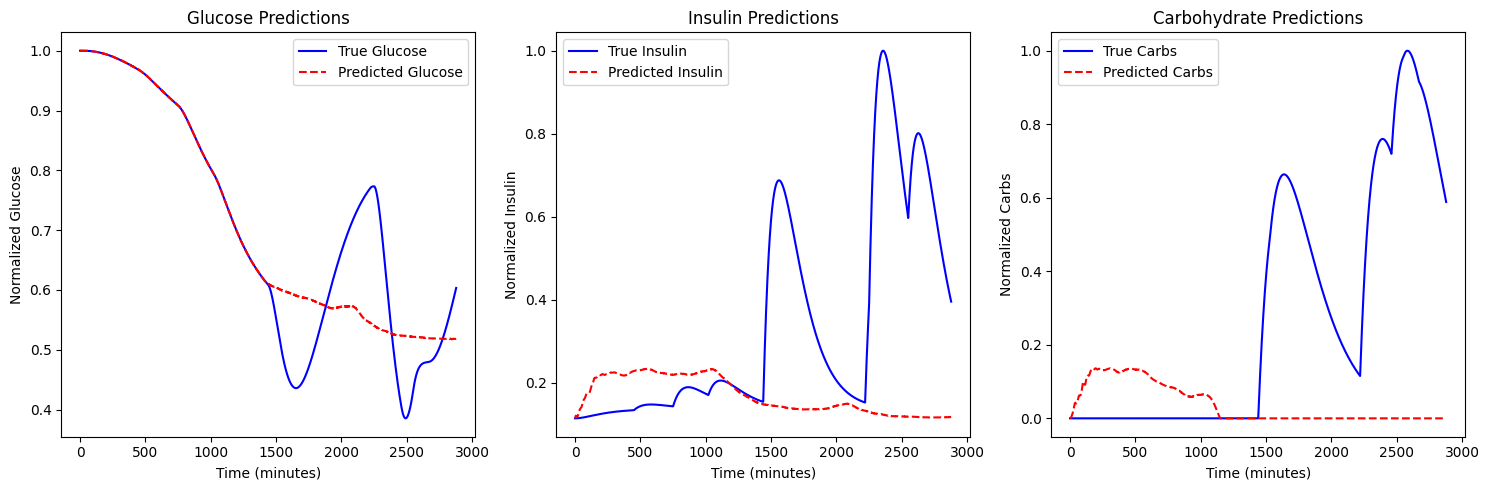

In [7]:
# Predict over the full data (interpolation + forecast combined)
G_pred_data = model.predict(data_t_normalised)[:, 0:1]
I_pred_data = model.predict(data_t_normalised)[:, 1:2]
D_pred_data = model.predict(data_t_normalised)[:, 2:3]
print("Current DeepXDE backend:", dde.backend.backend_name)
# Flatten predictions and true values for plotting
data_t_flat = data_t.flatten()
G_pred_data_flat = G_pred_data.flatten()
I_pred_data_flat = I_pred_data.flatten()
D_pred_data_flat = D_pred_data.flatten()

data_g_flat = data_g_normalised.flatten()
data_i_flat = data_i_normalised.flatten()
data_d_flat = data_d_normalised.flatten()

# Combine predictions and ground truth for export
results = {
    "time": data_t_flat,
    "I_true": data_i_flat,
    "D_true": data_d_flat,
    "I_pred": I_pred_data_flat,
    "D_pred": D_pred_data_flat
}

# Change filename to something like: 'predictions_PINN_patient3.npz'
np.savez("predictions_ModMLP_IandD.npz", **results)

# Create the plot
plt.figure(figsize=(15, 5))  # Wider for better layout

plt.subplot(1, 3, 1)
plt.plot(data_t_flat, data_g_flat, label="True Glucose", color="blue")
plt.plot(data_t_flat, G_pred_data_flat, label="Predicted Glucose", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Glucose")
plt.legend()
plt.title("Glucose Predictions")

plt.subplot(1, 3, 2)
plt.plot(data_t_flat, data_i_flat, label="True Insulin", color="blue")
plt.plot(data_t_flat, I_pred_data_flat, label="Predicted Insulin", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Insulin")
plt.legend()
plt.title("Insulin Predictions")

plt.subplot(1, 3, 3)
plt.plot(data_t_flat, data_d_flat, label="True Carbs", color="blue")
plt.plot(data_t_flat, D_pred_data_flat, label="Predicted Carbs", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Carbs")
plt.legend()
plt.title("Carbohydrate Predictions")

plt.tight_layout()
plt.show()


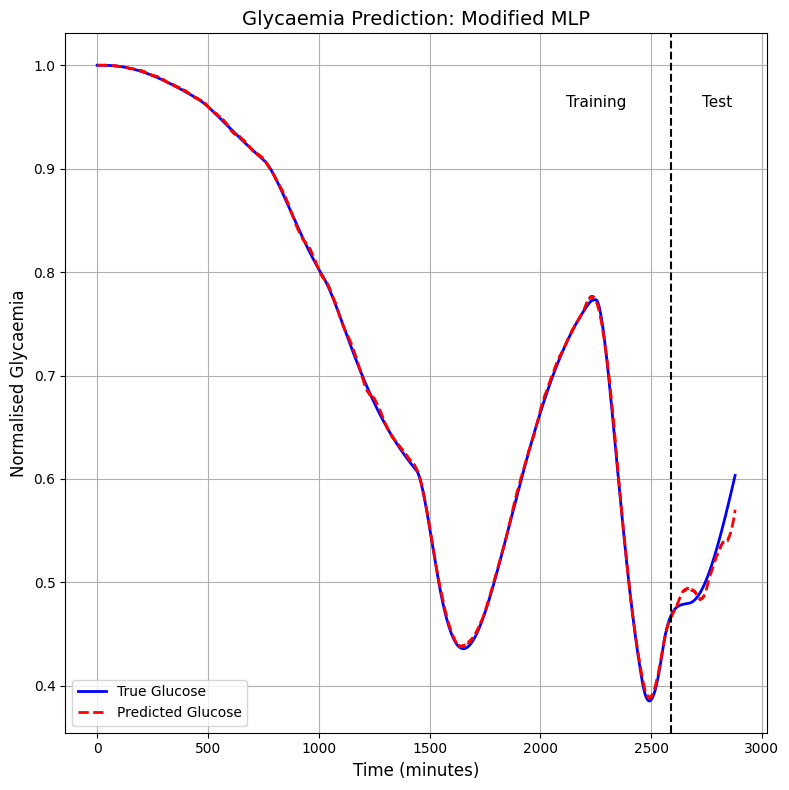

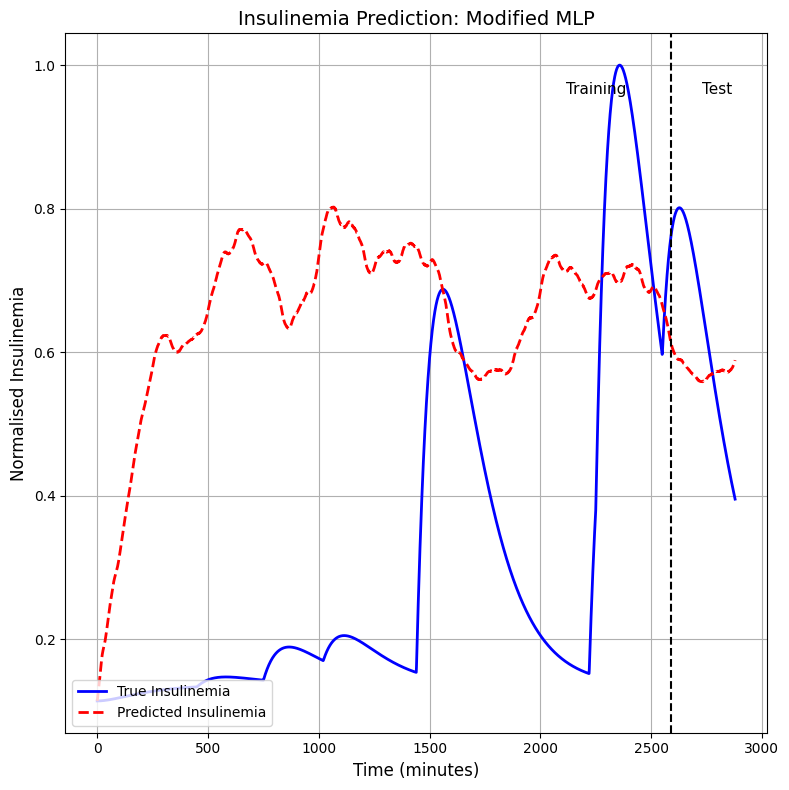

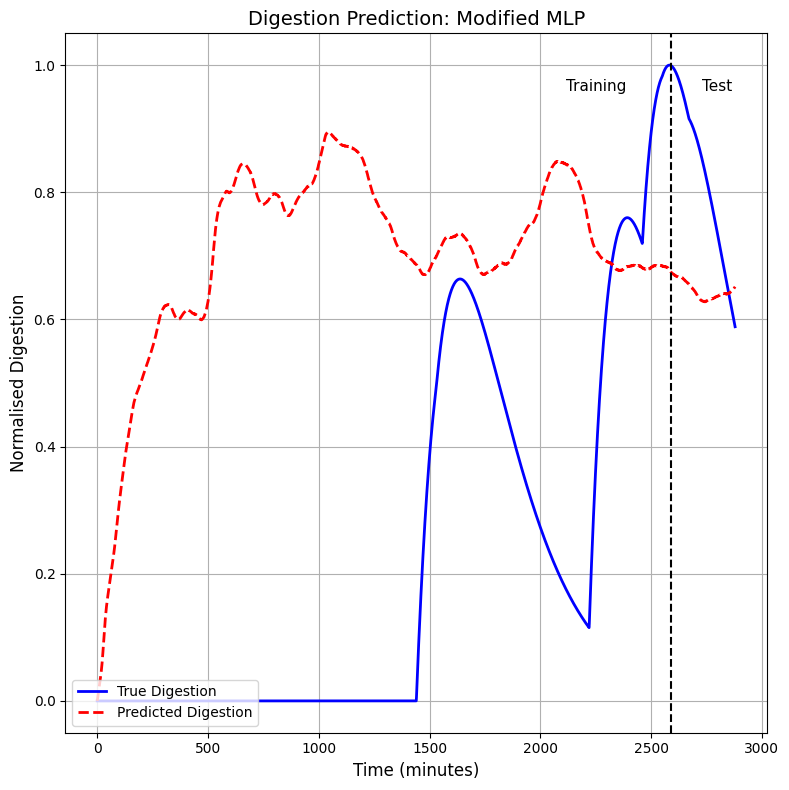

In [ ]:
split_time = data_t_flat[split_index]  # Time at which test set starts

# Create plot
plt.figure(figsize=(8, 8))

plt.plot(data_t_flat, data_g_flat, label="True Glucose", color="blue", linewidth=2)
plt.plot(data_t_flat, G_pred_data_flat, label="Predicted Glucose", linestyle="--", color="red", linewidth=2)

# Add vertical dashed line at test/train split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
# plt.text(split_time, 0.28, "Test Start", rotation=90, verticalalignment='bottom', color='gray')
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Labels and formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Glycaemia", fontsize=12)
plt.title("Glycaemia Prediction: Modified MLP", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
# plt.savefig("glucose_prediction_FNN.png", dpi=600, bbox_inches='tight')
plt.show()

# Create plot
plt.figure(figsize=(8, 8))

plt.plot(data_t_flat, data_i_flat, label="True Insulinemia", color="blue", linewidth=2)
plt.plot(data_t_flat, I_pred_data_flat, label="Predicted Insulinemia", linestyle="--", color="red", linewidth=2)

# Add vertical dashed line at test/train split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
# plt.text(split_time, 0.28, "Test Start", rotation=90, verticalalignment='bottom', color='gray')
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Labels and formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Insulinemia", fontsize=12)
plt.title("Insulinemia Prediction: Modified MLP", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
# plt.savefig("glucose_prediction_FNN.png", dpi=600, bbox_inches='tight')
plt.show()

# Create plot
plt.figure(figsize=(8, 8))

plt.plot(data_t_flat, data_d_flat, label="True Digestion", color="blue", linewidth=2)
plt.plot(data_t_flat, D_pred_data_flat, label="Predicted Digestion", linestyle="--", color="red", linewidth=2)

# Add vertical dashed line at test/train split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
# plt.text(split_time, 0.28, "Test Start", rotation=90, verticalalignment='bottom', color='gray')
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Labels and formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Digestion", fontsize=12)
plt.title("Digestion Prediction: Modified MLP", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
# plt.savefig("glucose_prediction_FNN.png", dpi=600, bbox_inches='tight')
plt.show()

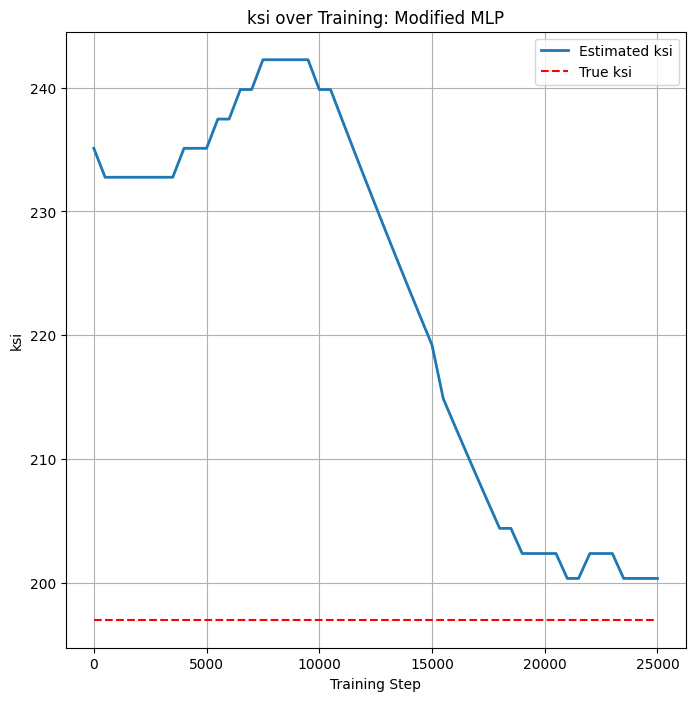

In [6]:
# === True values for comparison ===
true_params = {
    2: {"ksi": 197, "Tu": 122, "Tr": 183},
    3: {"ksi": 274, "Tu": 88, "Tr": 49},
    4: {"ksi": 191, "Tu": 126, "Tr": 188},
    5: {"ksi": 282, "Tu": 85, "Tr": 48},
    6: {"ksi": 203, "Tu": 118, "Tr": 178},
    7: {"ksi": 267, "Tu": 91, "Tr": 50},
    8: {"ksi": 200, "Tu": 125, "Tr": 182},
    9: {"ksi": 272, "Tu": 87, "Tr": 49},
    10: {"ksi": 191, "Tu": 126, "Tr": 188},
    11: {"ksi": 282, "Tu": 85, "Tr": 48},
}[pat]

# === Load & parse log file ===
# Define file paths
# pat_str = f"{pat}"
# output_file = f"run_{pat_str}_params_stage.dat"
# input_files = [
#     f"run_{pat_str}_params_stage1.dat",
#     f"run_{pat_str}_params_stage2.dat",
#     f"run_{pat_str}_params_stage3.dat"
# ]

# # Concatenate all stage logs into one
# with open(output_file, "w") as outfile:
#     for fname in input_files:
#         if os.path.exists(fname):
#             with open(fname) as infile:
#                 for line in infile:
#                     outfile.write(line)
#         else:
#             print(f"Warning: {fname} not found and will be skipped.")

dat_path = f"run_{pat}_params_stage.dat"  # or stage1.dat if you want early trend

steps = []
ksi_vals = []
Tu_vals = []
Tr_vals = []

with open(dat_path, "r") as file:
    for line in file:
        if "[" in line:
            parts = line.strip().split(" ", 1)
            step = int(parts[0])
            vals = ast.literal_eval(parts[1])
            steps.append(step)
            ksi_vals.append(vals[0])
            # Tu_vals.append(vals[1])
            # Tr_vals.append(vals[2])

ksi_vals = np.exp(ksi_vals)
# Tu_vals = np.exp(Tu_vals)
# Tr_vals = np.exp(Tr_vals)

# === Plotting ===
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
params = ["ksi", "Tu", "Tr"]
true_values = [true_params["ksi"], true_params["Tu"], true_params["Tr"]]
values = [ksi_vals, Tu_vals, Tr_vals]

plt.figure(figsize=(8, 8))
plt.plot(steps, ksi_vals, label="Estimated ksi", linewidth=2)
plt.hlines(true_params["ksi"], min(steps), max(steps), colors="r", linestyles="dashed", label="True ksi")
plt.title("ksi over Training: Modified MLP")
plt.xlabel("Training Step")
plt.ylabel("ksi")
plt.legend()
plt.grid(True)

# for i in range(3):
#     axes[i].plot(steps, values[i], label="Estimated", linewidth=2)
#     axes[i].hlines(true_values[i], min(steps), max(steps), colors="r", linestyles="dashed", label="True")
#     axes[i].set_title(f"{params[i]} over Training")
#     axes[i].set_xlabel("Training Step")
#     axes[i].set_ylabel(params[i])
#     axes[i].legend()
#     axes[i].grid(True)

# plt.suptitle(f"Inverse PINN Parameter Estimates (ksi, Tu, Tr) - Patient {pat}", fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("inverse_mod.png", dpi=600, bbox_inches='tight')
plt.show()


# **Forward Modelling**

In [ ]:
import os
import numpy as np
import pandas as pd
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval

# === Global Settings ===
patients = list(range(2, 12))
num_runs = 3
epochs = 25000
learning_rate = 5e-5
inverse_activated = True
ini_con = "hard"
fourier = True

results = []

for pat in patients:
    print(f"\n=== Patient {pat} ===")
    filename = f"Pat{pat}.csv"
    df = pd.read_csv(filename)

    data_t = df.iloc[0:2880, [0]].values
    data_g = df.iloc[0:2880, [2]].values
    data_i = df.iloc[0:2880, [3]].values
    data_d = df.iloc[0:2880, [5]].values

    m_t = data_t.max()
    m_g = data_g.max()
    m_i = data_i.max()
    m_d = data_d.max()

    data_t_norm = data_t / m_t
    data_g_norm = data_g / m_g
    data_i_norm = data_i / m_i
    data_d_norm = data_d / m_d

    first_t, first_g, first_i, first_d = data_t_norm[0], data_g_norm[0], data_i_norm[0], data_d_norm[0]
    remaining_t = data_t_norm[1:]
    remaining_g = data_g_norm[1:]
    remaining_i = data_i_norm[1:]
    remaining_d = data_d_norm[1:]

    split_index = int(0.9 * len(remaining_t))
    t_interp = remaining_t[:split_index]
    g_interp = remaining_g[:split_index]
    i_interp = remaining_i[:split_index]
    d_interp = remaining_d[:split_index]

    t_forecast = remaining_t[split_index:].reshape(-1, 1)
    g_forecast = remaining_g[split_index:].reshape(-1, 1)
    i_forecast = remaining_i[split_index:].reshape(-1, 1)
    d_forecast = remaining_d[split_index:].reshape(-1, 1)

    mask = np.ones(len(t_interp), dtype=bool)
    mask[::10] = False

    t_train = np.concatenate([[first_t], t_interp[mask]]).reshape(-1, 1)
    g_train = np.concatenate([[first_g], g_interp[mask]]).reshape(-1, 1)
    i_train = np.concatenate([[first_i], i_interp[mask]]).reshape(-1, 1)
    d_train = np.concatenate([[first_d], d_interp[mask]]).reshape(-1, 1)

    func_init = [first_g, first_i, first_d]

    for run in range(num_runs):
        print(f"→ Run {run+1} / {num_runs}")

        glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
        if inverse_activated:
            inverse_params = glucosemodel.set_inverse_parameters(random_init=True)
        else:
            glucosemodel.set_parameters(pat)

        geomtime = glucosemodel.geometry_time()
        ode = glucosemodel.ode

        net = dde.maps.FNN([1] + [32] * 3 + [3], "tanh", "Glorot uniform")

        if fourier:
            net.apply_feature_transform(lambda t: tf.concat(
                [t * m_t] +
                [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
                [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
                axis=1
            ))

        if ini_con == "hard":
            net.apply_output_transform(lambda t, y: tf.concat([
                tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
                tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
                tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3])
            ], axis=1))

        observe_g = dde.PointSetBC(t_train, g_train, component=0)
        input_data = [observe_g]

        data = dde.data.PDE(geomtime, ode, input_data, num_domain=3000, anchors=t_train)
        model = dde.Model(data, net)

        stage_file = f"run_{pat}_run{run+1}_log.dat"
        logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=stage_file)

        model.compile("adam", lr=learning_rate,
                      loss_weights=[5.973894046609318, 4.702928213908855, 2.7116368037902543, 3.3211698223093755],
                      external_trainable_variables=[inverse_params])
        model.train(epochs=epochs, display_every=1000, callbacks=[logger])
        model.compile("L-BFGS-B")
        model.train()

        preds = model.predict(t_forecast)
        g_pred, i_pred, d_pred = preds[:, 0:1], preds[:, 1:2], preds[:, 2:3]

        rmse_g = np.sqrt(np.mean((g_pred - g_forecast) ** 2))
        rmse_i = np.sqrt(np.mean((i_pred - i_forecast) ** 2))
        rmse_d = np.sqrt(np.mean((d_pred - d_forecast) ** 2))

        # === Extract final logged ksi value ===
        with open(stage_file, "r") as f:
            last_line = None
            for line in f:
                if "[" in line:
                    last_line = line
            if last_line:
                log_ksi = literal_eval(last_line.strip().split(" ", 1)[1])[0]
                final_ksi = float(np.exp(log_ksi))
            else:
                final_ksi = np.nan

        results.append({
            "Patient": pat,
            "Run": run + 1,
            "G_RMSE": float(rmse_g),
            "I_RMSE": float(rmse_i),
            "D_RMSE": float(rmse_d),
            "ksi": final_ksi
        })

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv("forward_inverse_ksi_rmse_results.csv", index=False)
print("\n✓ All runs complete. Results saved to 'forward_inverse_ksi_rmse_results.csv'")



=== Patient 2 ===
→ Run 1 / 3
Compiling model...
Building feed-forward neural network...
'build' took 0.147567 s

'compile' took 5.604644 s

Training model...

0         [2.28e-04, 1.50e-06, 3.85e-09, 8.40e-02]    [2.28e-04, 1.50e-06, 3.85e-09, 8.40e-02]    []  
1000      [1.96e-04, 1.51e-06, 4.80e-09, 3.26e-02]    [1.96e-04, 1.51e-06, 4.80e-09, 3.26e-02]    []  
2000      [1.22e-04, 1.51e-06, 5.26e-09, 2.85e-02]    [1.22e-04, 1.51e-06, 5.26e-09, 2.85e-02]    []  
3000      [2.76e-04, 1.51e-06, 9.92e-09, 1.66e-02]    [2.76e-04, 1.51e-06, 9.92e-09, 1.66e-02]    []  
4000      [9.86e-05, 1.51e-06, 1.45e-08, 6.36e-03]    [9.86e-05, 1.51e-06, 1.45e-08, 6.36e-03]    []  
5000      [6.20e-05, 1.51e-06, 1.50e-08, 3.72e-03]    [6.20e-05, 1.51e-06, 1.50e-08, 3.72e-03]    []  
6000      [4.25e-05, 1.50e-06, 1.18e-08, 2.29e-03]    [4.25e-05, 1.50e-06, 1.18e-08, 2.29e-03]    []  
7000      [2.97e-05, 1.50e-06, 1.11e-08, 1.12e-03]    [2.97e-05, 1.50e-06, 1.11e-08, 1.12e-03]    []  
8000      [1.89

In [ ]:
import os
import numpy as np
import pandas as pd
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval

# === Global Settings ===
patients = list(range(2, 12))
num_runs = 3
epochs = 25000
learning_rate = 5e-5
inverse_activated = True
ini_con = "hard"
fourier = False

results = []

for pat in patients:
    print(f"\n=== Patient {pat} ===")
    filename = f"Pat{pat}.csv"
    df = pd.read_csv(filename)

    data_t = df.iloc[0:2880, [0]].values
    data_g = df.iloc[0:2880, [2]].values
    data_i = df.iloc[0:2880, [3]].values
    data_d = df.iloc[0:2880, [5]].values

    m_t = data_t.max()
    m_g = data_g.max()
    m_i = data_i.max()
    m_d = data_d.max()

    data_t_norm = data_t / m_t
    data_g_norm = data_g / m_g
    data_i_norm = data_i / m_i
    data_d_norm = data_d / m_d

    first_t, first_g, first_i, first_d = data_t_norm[0], data_g_norm[0], data_i_norm[0], data_d_norm[0]
    remaining_t = data_t_norm[1:]
    remaining_g = data_g_norm[1:]
    remaining_i = data_i_norm[1:]
    remaining_d = data_d_norm[1:]

    split_index = int(0.9 * len(remaining_t))
    t_interp = remaining_t[:split_index]
    g_interp = remaining_g[:split_index]
    i_interp = remaining_i[:split_index]
    d_interp = remaining_d[:split_index]

    t_forecast = remaining_t[split_index:].reshape(-1, 1)
    g_forecast = remaining_g[split_index:].reshape(-1, 1)
    i_forecast = remaining_i[split_index:].reshape(-1, 1)
    d_forecast = remaining_d[split_index:].reshape(-1, 1)

    mask = np.ones(len(t_interp), dtype=bool)
    mask[::10] = False

    t_train = np.concatenate([[first_t], t_interp[mask]]).reshape(-1, 1)
    g_train = np.concatenate([[first_g], g_interp[mask]]).reshape(-1, 1)
    i_train = np.concatenate([[first_i], i_interp[mask]]).reshape(-1, 1)
    d_train = np.concatenate([[first_d], d_interp[mask]]).reshape(-1, 1)

    func_init = [first_g, first_i, first_d]

    for run in range(num_runs):
        print(f"→ Run {run+1} / {num_runs}")

        glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
        if inverse_activated:
            inverse_params = glucosemodel.set_inverse_parameters(random_init=True)
        else:
            glucosemodel.set_parameters(pat)

        geomtime = glucosemodel.geometry_time()
        ode = glucosemodel.ode

        net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])

        # if fourier:
        #     net.apply_feature_transform(lambda t: tf.concat(
        #         [t * m_t] +
        #         [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
        #         [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
        #         axis=1
        #     ))

        if ini_con == "hard":
            net.apply_output_transform(lambda t, y: tf.concat([
                tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
                tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
                tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3])
            ], axis=1))

        observe_g = dde.PointSetBC(t_train, g_train, component=0)
        input_data = [observe_g]

        data = dde.data.PDE(geomtime, ode, input_data, num_domain=3000, anchors=t_train)
        model = dde.Model(data, net)

        stage_file = f"run_{pat}_run{run+1}_log.dat"
        logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=stage_file)

        model.compile("adam", lr=learning_rate,
                      loss_weights=[5.973894046609318, 4.702928213908855, 2.7116368037902543, 3.3211698223093755],
                      external_trainable_variables=[inverse_params])
        model.train(epochs=epochs, display_every=1000, callbacks=[logger])
        model.compile("L-BFGS-B")
        model.train()

        preds = model.predict(t_forecast)
        g_pred, i_pred, d_pred = preds[:, 0:1], preds[:, 1:2], preds[:, 2:3]

        rmse_g = np.sqrt(np.mean((g_pred - g_forecast) ** 2))
        rmse_i = np.sqrt(np.mean((i_pred - i_forecast) ** 2))
        rmse_d = np.sqrt(np.mean((d_pred - d_forecast) ** 2))

        # === Extract final logged ksi value ===
        with open(stage_file, "r") as f:
            last_line = None
            for line in f:
                if "[" in line:
                    last_line = line
            if last_line:
                log_ksi = literal_eval(last_line.strip().split(" ", 1)[1])[0]
                final_ksi = float(np.exp(log_ksi))
            else:
                final_ksi = np.nan

        results.append({
            "Patient": pat,
            "Run": run + 1,
            "G_RMSE": float(rmse_g),
            "I_RMSE": float(rmse_i),
            "D_RMSE": float(rmse_d),
            "ksi": final_ksi
        })

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv("ModMLP_forward_inverse_ksi_rmse_results.csv", index=False)
print("\n✓ All runs complete. Results saved to 'forward_inverse_ksi_rmse_results.csv'")



=== Patient 2 ===
→ Run 1 / 3
Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.014866 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.67e-04, 1.49e-06, 3.42e-09, 6.26e-01]    [1.67e-04, 1.49e-06, 3.42e-09, 6.26e-01]    []  
1000      [8.70e-06, 1.50e-06, 3.42e-09, 3.94e-02]    [8.70e-06, 1.50e-06, 3.42e-09, 3.94e-02]    []  
2000      [8.59e-06, 1.50e-06, 3.42e-09, 3.53e-02]    [8.59e-06, 1.50e-06, 3.42e-09, 3.53e-02]    []  
3000      [8.36e-06, 1.50e-06, 3.42e-09, 3.31e-02]    [8.36e-06, 1.50e-06, 3.42e-09, 3.31e-02]    []  
4000      [7.84e-06, 1.50e-06, 3.42e-09, 2.84e-02]    [7.84e-06, 1.50e-06, 3.42e-09, 2.84e-02]    []  
5000      [6.46e-06, 1.50e-06, 3.43e-09, 2.40e-02]    [6.46e-06, 1.50e-06, 3.43e-09, 2.40e-02]    []  
6000      [4.73e-06, 1.50e-06, 3.43e-09, 2.22e-02]    [4.73e-06, 1.50e-06, 3.43e-09, 2.22e-02]    []  
7000      [6.13e-07, 1

# **Inverse Modelling**


=== Run 1 / 8 ===

===== Stage 1: Train inverse parameters only =====
Compiling model...
Building feed-forward neural network...
'build' took 0.077397 s

'compile' took 10.562393 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.67e-04, 0.00e+00, 0.00e+00, 0.00e+00]    [2.96e-04, 0.00e+00, 0.00e+00, 0.00e+00]    []  
500       [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1500      [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2500      [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [6.98e-07, 0.00e+00, 0.00e+00, 0.00e+00]    [1.24e-06, 0.00e

NameError: name 'true_params' is not defined

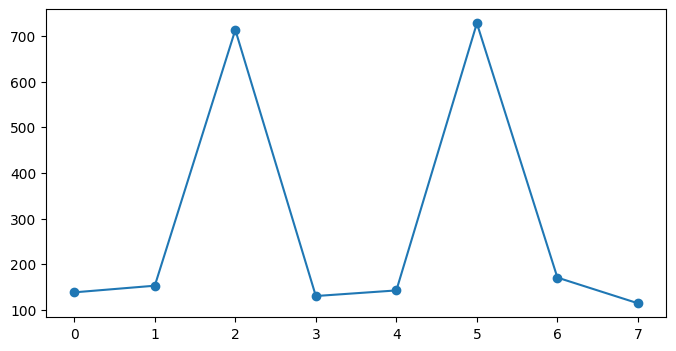

In [ ]:
# import ast

# num_runs = 8
# pat = 6
# ksi_estimates = []

# for run in range(num_runs):
#     print(f"\n=== Run {run+1} / {num_runs} ===")

#     # --- Reset model ---
#     glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
#     inverse_params = glucosemodel.set_inverse_parameters(random_init=True)

#     # --- Train model (your 3-stage block goes here) ---
#     ode = glucosemodel.ode
#     net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")

#     if ini_con == 'hard':
#         net.apply_output_transform(lambda t, y: tf.concat([
#             tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
#             tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
#             tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
#         ], axis=1))

#     # if fourier:
#     #     net.apply_feature_transform(lambda t: tf.concat(
#     #         [t * m_t] +
#     #         [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
#     #         [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
#     #         axis=1
#     #     ))

#     ode_data = dde.data.PDE(geomtime, ode, input_data,
#                             num_domain=num_domain,
#                             anchors=t_train,
#                             num_test=num_test)

#     model = dde.Model(ode_data, net)

#     print("\n===== Stage 1: Train inverse parameters only =====")
#     model.compile("adam", lr=1e-3, loss_weights=[1.0, 0.0, 0.0, 0.0], external_trainable_variables=inverse_params)
#     stage1_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage1.dat")
#     losshistory1, train_state1 = model.train(epochs=5000, display_every=500, callbacks=[stage1_logger])

#     print("\n===== Stage 2: Train NN weights only =====")
#     model.compile("adam", lr=5e-4, loss_weights=[7.5, 0.9, 0.18, 4.6])  # no external vars now
#     stage2_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage2.dat")
#     losshistory2, train_state2 = model.train(epochs=4000, display_every=500, callbacks=[stage2_logger])

#     print("\n===== Stage 3: Joint fine-tuning =====")
#     model.compile("adam", lr=2e-4, loss_weights=[7.5, 0.9, 0.18, 4.6], external_trainable_variables=inverse_params)
#     stage3_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage3.dat")
#     losshistory3, train_state3 = model.train(epochs=2000, display_every=500, callbacks=[stage3_logger])


#     # --- Merge .dat logs into one ---
#     pat_str = f"{pat}_run{run+1}"
#     merged_file = f"run_{pat_str}_params_stage.dat"
#     input_files = [
#         f"run_{pat}_params_stage1.dat",
#         f"run_{pat}_params_stage2.dat",
#         f"run_{pat}_params_stage3.dat"
#     ]
#     with open(merged_file, "w") as outfile:
#         for fname in input_files:
#             if os.path.exists(fname):
#                 with open(fname) as infile:
#                     outfile.writelines(infile.readlines())

#     # --- Parse final value of ksi from merged file ---
#     with open(merged_file, "r") as file:
#         last_line = None
#         for line in file:
#             if "[" in line:
#                 last_line = line  # keep only the last one
#         if last_line:
#             parts = last_line.strip().split(" ", 1)
#             values = ast.literal_eval(parts[1])
#             final_ksi = np.exp(values[0])
#             ksi_estimates.append(final_ksi)
#             print(f"Run {run+1} → Final ksi = {final_ksi:.2f}")
#         else:
#             print(f"Warning: no valid entries in log file for run {run+1}")



# print("Final ksi estimates:", ksi_estimates)
# print(f"Mean ksi: {np.mean(ksi_estimates):.2f} ± {np.std(ksi_estimates):.2f}")

# plt.figure(figsize=(8, 4))
# plt.plot(ksi_estimates, "o-", label="Estimated ksi per run")
# plt.hlines(true_params["ksi"], 0, num_runs - 1, colors="r", linestyles="dashed", label="True ksi")
# plt.xlabel("Run Index")
# plt.ylabel("ksi")
# plt.title(f"Ksi Estimation Across {num_runs} Runs - Patient {pat}")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



In [ ]:
import os
import ast
import numpy as np
import pandas as pd
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt


# Constants
patients = list(range(7, 12))
num_runs = 5
true_params_dict = {
    2: 197, 3: 274, 4: 191, 5: 282, 6: 203,
    7: 267, 8: 200, 9: 272, 10: 191, 11: 282
}

# Empty storage
ksi_results = []

# Loop through patients
for pat in patients:
    filename = f"Pat{pat}.csv"
    df = pd.read_csv(filename)

    data_t = df.iloc[0:2880, [0]].values
    data_g = df.iloc[0:2880, [2]].values
    data_i = df.iloc[0:2880, [3]].values
    data_d = df.iloc[0:2880, [5]].values

    m_t = data_t.max()
    m_g = data_g.max()
    m_i = data_i.max()
    m_d = data_d.max()

    data_t_normalised = data_t / m_t
    data_g_normalised = data_g / m_g
    data_i_normalised = data_i / m_i
    data_d_normalised = data_d / m_d

    first_t, first_g, first_i, first_d = data_t_normalised[0], data_g_normalised[0], data_i_normalised[0], data_d_normalised[0]

    remaining_t = data_t_normalised[1:]
    remaining_g = data_g_normalised[1:]
    remaining_i = data_i_normalised[1:]
    remaining_d = data_d_normalised[1:]

    split_index = int(0.9 * len(remaining_t))
    t_interp = remaining_t[:split_index]
    g_interp = remaining_g[:split_index]
    i_interp = remaining_i[:split_index]
    d_interp = remaining_d[:split_index]

    mask = np.ones(len(t_interp), dtype=bool)
    mask[::10] = False

    t_train_interp = t_interp[mask]
    g_train_interp = g_interp[mask]
    i_train_interp = i_interp[mask]
    d_train_interp = d_interp[mask]

    t_train = np.concatenate([[first_t], t_train_interp]).reshape(-1, 1)
    g_train = np.concatenate([[first_g], g_train_interp]).reshape(-1, 1)
    i_train = np.concatenate([[first_i], i_train_interp]).reshape(-1, 1)
    d_train = np.concatenate([[first_d], d_train_interp]).reshape(-1, 1)

    func_init = [first_g, first_i, first_d]

    glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
    geomtime = glucosemodel.geometry_time()

    observe_g = dde.PointSetBC(t_train, g_train, component=0)

    input_data = [observe_g]

    for run in range(num_runs):
        print(f"\n=== Patient {pat} | Run {run+1} / {num_runs} ===")

        inverse_params = glucosemodel.set_inverse_parameters(random_init=True)

        ode = glucosemodel.ode
        # net = dde.maps.FNN([1] + [32] * 3 + [3], "tanh", "Glorot uniform")
        net = ModifiedMLP([1] + [32] * 3 + [3])

        if ini_con == 'hard':
            net.apply_output_transform(lambda t, y: tf.concat([
                tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
                tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
                tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
            ], axis=1))

        # if fourier:
        #     net.apply_feature_transform(lambda t: tf.concat(
        #         [t * m_t] +
        #         [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
        #         [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
        #         axis=1
        #     ))

        ode_data = dde.data.PDE(geomtime, ode, input_data,
                                num_domain=3000,
                                anchors=t_train,
                                num_test=1000)

        model = dde.Model(ode_data, net)

        stage_files = []
        for stage, (lr, lw, ep) in enumerate([
            (1e-3, [1.0, 0.0, 0.0, 0.0], 5000),
            (5e-4, [7.5, 0.9, 0.18, 4.6], 4000),
            (2e-4, [7.5, 0.9, 0.18, 4.6], 2000)]):

            model.compile("adam", lr=lr, loss_weights=lw,
                          external_trainable_variables=inverse_params if stage != 1 else None)
            stage_file = f"run_{pat}_run{run+1}_stage{stage+1}.dat"
            logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=stage_file)
            model.train(epochs=ep, display_every=500, callbacks=[logger])
            stage_files.append(stage_file)

        merged_file = f"run_{pat}_run{run+1}_params_stage.dat"
        with open(merged_file, "w") as outfile:
            for fname in stage_files:
                if os.path.exists(fname):
                    with open(fname) as infile:
                        outfile.writelines(infile.readlines())

        with open(merged_file, "r") as file:
            last_line = None
            for line in file:
                if "[" in line:
                    last_line = line
            if last_line:
                values = ast.literal_eval(last_line.strip().split(" ", 1)[1])
                final_ksi = np.exp(values[0])
                ksi_results.append({"Patient": pat, "Run": run+1, "Estimated_ksi": final_ksi})
                print(f"Run {run+1} → Final ksi = {final_ksi:.2f}")

# Save final results
ksi_df = pd.DataFrame(ksi_results)
ksi_df.to_csv("ksi_estimates_all_patients.csv", index=False)
print("\nAll runs complete. Results saved to 'ksi_estimates_all_patients.csv'")



=== Patient 7 | Run 1 / 5 ===
Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.312656 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.87e-06, 0.00e+00, 0.00e+00, 0.00e+00]    [7.84e-06, 0.00e+00, 0.00e+00, 0.00e+00]    []  
500       [2.10e-10, 0.00e+00, 0.00e+00, 0.00e+00]    [1.05e-10, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [1.48e-10, 0.00e+00, 0.00e+00, 0.00e+00]    [3.97e-11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1500      [1.15e-10, 0.00e+00, 0.00e+00, 0.00e+00]    [2.83e-11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [8.30e-11, 0.00e+00, 0.00e+00, 0.00e+00]    [2.95e-11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2500      [5.52e-11, 0.00e+00, 0.00e+00, 0.00e+00]    [1.44e-11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [3.49e-11, 0.00e+00, 0.00e+00, 0.00e+00]    [1.09e-11, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3500      [2.05e-11, 0

In [ ]:
ksi_range = np.arange(150.0, 301.0, 10.0)
glucose_predictions = []
rmse_values = []

for ksi_val in ksi_range:
    print(f"\n=== Simulating with ksi = {ksi_val} ===")

    # Set fixed ksi
    glucosemodel.set_parameters(pat)
    glucosemodel.ksi = ksi_val  # Overwrite default
    glucosemodel.Ieq = (glucosemodel.kl - glucosemodel.kb) / glucosemodel.ksi
    glucosemodel.generate_inputs_over_time(pat)  # Regenerate ut/rt for current ksi

    # Rebuild model
    geomtime = glucosemodel.geometry_time()
    ode_data = dde.data.PDE(geomtime, glucosemodel.ode, input_data,
                            num_domain=num_domain, anchors=t_train, num_test=num_test)

    net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size],
                       "tanh", "Glorot uniform")
    if ini_con == 'hard':
        net.apply_output_transform(output_transform)
    if fourier:
        net.apply_feature_transform(input_transform)

    model = dde.Model(ode_data, net)
    model.compile("adam", lr=lr, loss_weights=[7.5, 0.9, 0.18, 4.6])
    model.train(epochs=epochs, display_every=1000)

    G_pred = model.predict(data_t_normalised)[:, 0]
    glucose_predictions.append(G_pred)

    G_true = data_g_normalised.squeeze()
    rmse = np.sqrt(np.mean((G_pred - G_true)**2))
    rmse_values.append(rmse)
    print(f"RMSE for ksi = {ksi_val:.0f}: {rmse:.5f}")

plt.figure(figsize=(12, 6))
for i, G in enumerate(glucose_predictions):
    plt.plot(data_t, G, label=f"ksi = {ksi_range[i]:.0f}")

plt.plot(data_t, data_g_normalised, 'k--', label="True Glucose")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Traces for Varying ksi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ksi_range, rmse_values, marker='o', linestyle='-', color='purple')
plt.xlabel("Insulin Sensitivity (ksi)")
plt.ylabel("Glucose RMSE")
plt.title("RMSE of Glucose Prediction vs ksi")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))
for i, G in enumerate(glucose_predictions):
    plt.plot(data_t, G, label=f"ksi = {ksi_range[i]:.0f}")

plt.plot(data_t, data_g_normalised, 'k--', label="True Glucose")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Traces for Varying ksi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ksi_range, rmse_values, marker='o', linestyle='-', color='purple')
plt.xlabel("Insulin Sensitivity (ksi)")
plt.ylabel("Glucose RMSE")
plt.title("RMSE of Glucose Prediction vs ksi")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'glucose_predictions' is not defined

<Figure size 1200x500 with 0 Axes>

# **PINN Model (extrapolation)**

In [ ]:
# PINN model
import sys
import os
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pandas as pd
import deepxde as dde # version 0.11 or higher
from deepxde.backend import tensorflow as tf
from deepxde.callbacks import VariableValue
import tensorflow as tf  # Import TensorFlow separately
import ast
import random


# SEED = 42  # or any other integer you prefer
# random.seed(SEED)
# np.random.seed(SEED)
# tf.random.set_seed(SEED)


## Input variables
pat = 2
scale = 'max'        # 'z-score' or 'max'
loss_term = 'g_only' # 'g_only' or 'all'
ini_con = 'hard'     # 'soft' or 'hard' initial conditions
fourier = True    # 'True' or 'False'

## Network Parameters
input_size = 1  # network input size (time as 1D but input vector of size 5)
num_hidden_layers = 5  # number of hidden layers for NN
hidden_layer_size = 32  # size of each hidden layer
output_size = 3  # network output size

## Training Parameters
num_domain = 3000  # number of training points within the domain
num_test = 1000  # number of testing points within the domain
num_initial = 1  # number of points to test the initial conditions
epochs = 50000  # number of epochs for training
lr = 0.0001  # learning rate
noise = 0.5  # noise factor
test_size = 0.1  # percentage of testing data

dim = 1  # Ensure dimension is set to
noise_introduced = False
inverse_activated = True # Switch on when trying to solve inverse problem


## Load the physical model


# M = glucosemodel.M
# ksi = glucosemodel.ksi
# kl = glucosemodel.kl
# kb = 128 / M

# Ieq = (kl - kb) / ksi

## Load Data
filename = f"Pat{pat}.csv"
df = pd.read_csv(filename)

# Assign columns to data_t and data_g as matrices (DataFrames)
data_t = df.iloc[0:2880, [0]].values  # Column 1 = time points
data_g = df.iloc[0:2880, [2]].values  # Column 3 = glucose
data_i = df.iloc[0:2880, [3]].values  # Column 4 = insulin
data_d = df.iloc[0:2880, [5]].values  # Column 6 = carbs

m_t = data_t.max()
data_t_normalised = data_t / m_t

if scale == 'max':
  m_g = data_g.max()
  m_i = data_i.max()
  m_d = data_d.max()

  data_g_normalised = data_g / m_g
  data_i_normalised = data_i / m_i
  data_d_normalised = data_d / m_d

elif scale == 'z-score':
  m_g = data_g.mean()
  m_i = data_i.mean()
  m_d = data_d.mean()

  sig_g = data_g.std()
  sig_i = data_i.std()
  sig_d = data_d.std()

  data_g_normalised = (data_g - m_g) / sig_g
  data_i_normalised = (data_i - m_i) / sig_i
  data_d_normalised = (data_d - m_d) / sig_d

glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
if inverse_activated:
    inverse_params = glucosemodel.set_inverse_parameters()
else:
    params = glucosemodel.set_parameters(pat)

def output_transform(t, y_nn):
    """Apply hard initial conditions using a transformation function."""

    # t = t * m_t  # Ensure time is scaled properly
    return tf.concat(
        [
            tf.nn.relu(y_nn[:, 0:1] * tf.tanh(t) + data_g_normalised[0]),
            tf.nn.relu(y_nn[:, 1:2] * tf.tanh(t) + data_i_normalised[0]),
            tf.nn.relu(y_nn[:, 2:3] * tf.tanh(t) + data_d_normalised[0]),
        ],
        axis=1,
    )

# def input_transform(t, alpha=5.0):
#     alpha=5.0
#     warped_t = tf.exp(-alpha * t)
#     return warped_t

# def input_transform(t):
#     alpha = 5.0
#     t_warped = tf.tanh(alpha * t)  # or tf.exp(-alpha * t)
#     return t_warped  # still 1D, just reparameterized

def input_transform(t):
    # Apply input warping
    scaled_t = t * m_t / 500
    return tf.concat(
        (
            t * m_t,  # Unnormalized time
            tf.sin(scaled_t),
            tf.cos(scaled_t),
            tf.sin(2 * scaled_t),
            tf.cos(2 * scaled_t),
            tf.sin(4 * scaled_t),
            tf.cos(4 * scaled_t),
            tf.sin(8 * scaled_t),
            tf.cos(8 * scaled_t),
            tf.sin(16 * scaled_t),
            tf.cos(16 * scaled_t),
            tf.sin(32 * scaled_t),
            tf.cos(32 * scaled_t),
        ),
        axis=1,
    )

def calculate_rmse(true_values, predicted_values):
    """Calculate Root Mean Square Error (RMSE)."""
    return np.sqrt(np.mean((true_values - predicted_values) ** 2))

def calculate_mae(true_values, predicted_values):
    """Calculate Mean Absolute Error (MAE)."""
    return np.mean(np.abs(true_values - predicted_values))


print(f"Norm Glucose Data Sample: {data_g_normalised[:5]}")
print(f"Norm Insulin Data Sample: {data_i_normalised[:5]}")
print(f"Norm Carbs Data Sample: {data_d_normalised[:5]}")

data_t_normalised_df = pd.DataFrame(data_t_normalised, columns=["time_normalized"])
print("\nNormalized Time Values:")
print(data_t_normalised_df)

#For the moment the training set is too small because I wanted to guarantee that t0 would be in t_train, have to rewrite

first_t = data_t_normalised[0]
first_g = data_g_normalised[0]
first_i = data_i_normalised[0]
first_d = data_d_normalised[0]

# Remaining data
remaining_t = data_t_normalised[1:]
remaining_g = data_g_normalised[1:]
remaining_i = data_i_normalised[1:]
remaining_d = data_d_normalised[1:]

# Define the split index (90% for training, 10% for testing)
split_index = int(0.9 * len(remaining_t))

# Training data: First 90% of points
t_train, g_train, i_train, d_train = (
    remaining_t[:split_index],
    remaining_g[:split_index],
    remaining_i[:split_index],
    remaining_d[:split_index],
)

# Test data: Last 10% of points
t_test, g_test, i_test, d_test = (
    remaining_t[split_index:],
    remaining_g[split_index:],
    remaining_i[split_index:],
    remaining_d[split_index:],
)

train_set_size = np.size(t_train) + 1  # The 1 accounts for appending the first_t and first values

# Add the first point to the training set
t_train = np.append([first_t], t_train)
t_train = np.reshape(t_train, (train_set_size, 1))

g_train = np.append([first_g], g_train)
g_train = np.reshape(g_train, (train_set_size, 1))

i_train = np.append([first_i], i_train)
i_train = np.reshape(i_train, (train_set_size, 1))

d_train = np.append([first_d], d_train)
d_train = np.reshape(d_train, (train_set_size, 1))

#Intial conditions
func_init = [first_g, first_i, first_d]

## Geometry and Time domains
geomtime = glucosemodel.geometry_time()

# if noise_introduced:
#     g_train = g_train + noise*np.random.randn(g_train.shape[0], g_train.shape[1])

def boundary(_, on_initial):
    return on_initial

## Define Initial Conditions: Keeping only the initial condition for patient 2 for simplicity
ic_g = dde.IC(geomtime, lambda x: func_init[0], boundary, component=0)
ic_i = dde.IC(geomtime, lambda x: func_init[1], boundary, component=1)
ic_d = dde.IC(geomtime, lambda x: func_init[2], boundary, component=2)

 ## Model observed data
observe_g = dde.PointSetBC(t_train, g_train, component=0)
observe_i = dde.PointSetBC(t_train, i_train, component=1)
observe_d = dde.PointSetBC(t_train, d_train, component=2)

## Assign input data and loss weights based on selected training parameters
if loss_term == 'g_only' and ini_con == 'soft':
    input_data = [observe_g, ic_g, ic_i, ic_d]
if loss_term == 'g_only' and ini_con == 'hard':
    input_data = [observe_g]
if loss_term == 'all' and ini_con == 'soft':
    input_data = [observe_g, observe_i, observe_d, ic_g, ic_i, ic_d]
if loss_term == 'all' and ini_con == 'hard':
    input_data = [observe_g, observe_i, observe_d]

## Define the Network
ode = glucosemodel.ode
net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")

if ini_con == 'hard':
    net.apply_output_transform(output_transform)

if fourier:
  net.apply_feature_transform(input_transform)

# net.apply_feature_transform(input_transform)


ode_data = dde.data.PDE(geomtime, ode, input_data,
                        num_domain=num_domain,
                        anchors=t_train,
                        num_test=num_test)


model = dde.Model(ode_data, net)



# num_phases = 5  # Number of sequential training phases
# time_splits = np.linspace(0, len(t_train), num_phases + 1, dtype=int)

# for phase in range(num_phases):
#     print(f"\n===== Training Phase {phase + 1}/{num_phases} =====")

#     # Select subset of training data
#     t_train_phase = t_train[time_splits[phase]: time_splits[phase + 1]]
#     g_train_phase = g_train[time_splits[phase]: time_splits[phase + 1]]
#     i_train_phase = i_train[time_splits[phase]: time_splits[phase + 1]]
#     d_train_phase = d_train[time_splits[phase]: time_splits[phase + 1]]
#     print(f"Phase {phase + 1}:")
#     print(f"  t_train_phase shape: {t_train_phase.shape}")
#     print(f"  g_train_phase shape: {g_train_phase.shape}")
#     print(f"  First t: {t_train_phase[0][0]:.4f}, Last t: {t_train_phase[-1][0]:.4f}")
#     print("-" * 40)

#     # Plot training data for this phase
#     plt.figure(figsize=(15, 4))

#     plt.subplot(1, 3, 1)
#     plt.plot(t_train_phase, g_train_phase, 'b-')
#     plt.title(f"Phase {phase+1} - Glucose Training Data")
#     plt.xlabel("Time (normalized)")
#     plt.ylabel("Glucose")

#     plt.subplot(1, 3, 2)
#     plt.plot(t_train_phase, i_train_phase, 'b-')
#     plt.title(f"Phase {phase+1} - Insulin Training Data")
#     plt.xlabel("Time (normalized)")
#     plt.ylabel("Insulin")

#     plt.subplot(1, 3, 3)
#     plt.plot(t_train_phase, d_train_phase, 'b-')
#     plt.title(f"Phase {phase+1} - Carbs Training Data")
#     plt.xlabel("Time (normalized)")
#     plt.ylabel("Carbohydrates")

#     plt.tight_layout()
#     plt.savefig(f"debug_phase_{phase+1}_training_data.png")
#     plt.show()

#     # Redefine geometry per phase
#     t0_phase = float(t_train_phase[0])
#     t1_phase = float(t_train_phase[-1])
#     geomtime_phase = dde.geometry.TimeDomain(t0_phase, t1_phase)

#     # Use prediction from previous phase as new IC
#     if phase > 0:
#         prev_final_state = model.predict(np.array([t_train_phase[0]]))  # Already 2D
#         func_init = [
#             prev_final_state[0, 0],  # Glucose
#             prev_final_state[0, 1],  # Insulin
#             prev_final_state[0, 2]   # Carbs
#         ]
#     else:
#         func_init = [first_g, first_i, first_d]  # Original ICs

#     # Redefine ICs for the new geometry
#     ic_g = dde.IC(geomtime_phase, lambda x: func_init[0], boundary, component=0)
#     ic_i = dde.IC(geomtime_phase, lambda x: func_init[1], boundary, component=1)
#     ic_d = dde.IC(geomtime_phase, lambda x: func_init[2], boundary, component=2)

#     # Assign input data for this phase, depending on settings
#     if loss_term == 'g_only' and ini_con == 'hard':
#         input_data = [dde.PointSetBC(t_train_phase, g_train_phase, component=0)]
#     elif loss_term == 'g_only' and ini_con == 'soft':
#         input_data = [
#             dde.PointSetBC(t_train_phase, g_train_phase, component=0),
#             ic_g, ic_i, ic_d
#         ]
#     elif loss_term == 'all' and ini_con == 'hard':
#         input_data = [
#             dde.PointSetBC(t_train_phase, g_train_phase, component=0),
#             dde.PointSetBC(t_train_phase, i_train_phase, component=1),
#             dde.PointSetBC(t_train_phase, d_train_phase, component=2)
#         ]
#     elif loss_term == 'all' and ini_con == 'soft':
#         input_data = [
#             dde.PointSetBC(t_train_phase, g_train_phase, component=0),
#             dde.PointSetBC(t_train_phase, i_train_phase, component=1),
#             dde.PointSetBC(t_train_phase, d_train_phase, component=2),
#             ic_g, ic_i, ic_d
#         ]

#     # Redefine the problem
#     ode_data = dde.data.PDE(
#         geomtime_phase,
#         glucosemodel.ode,
#         input_data,
#         num_domain=num_domain,
#         anchors=t_train_phase,
#         num_test=num_test
#     )

#     # Rebuild model using the same net (preserves weights)
#     model = dde.Model(ode_data, net)

#     model.compile("adam", lr=lr)

#     losshistory, train_state = model.train(epochs=20000, display_every=1000)

#     # Evaluate Glucose RMSE for this phase
#     rmse_G_test = np.sqrt(np.square(model.predict(t_test)[:, 0] - g_test).mean())
#     print(f"Phase {phase + 1} - RMSE (Glucose): {rmse_G_test:.5f}")





# Remove IC losses from the loss function since ICs are hard enforced
# loss_weights = [
#    6.087516797778927, 7.811122164565435, 9.092601824687419,  # PDE loss weights
#    0.9835213933697937, 2.920429889062021, 5.977961400239223   # Observation losses
#]

#loss_weights = [
#    5.298183859236593, 4.028416828754142, 0.7913555485212642,  # PDE loss weights
#    1.0671775013024876   # Observation losses
#]

# Compile the model
 #loss_weights=[86.31825558333624, 10.625569779710585, 0.05101363822182585, 32.82519848687217]
# model.compile("adam", lr=lr, loss_weights=[69.05209518465055, 6.836369279132655, 21.949019631714208, 0.014468987125635158]) # loss_weights=[77.09026183879253, 88.48478184554327, 33.416778081755574, 0.6281290360263165]
# model.compile("adam", lr=lr, loss_weights=[99.96053807396926, 96.27515303113123, 87.57201941987275, 0.1406354666595031])

# model.compile("adam", lr=lr, loss_weights=[7.5, 0.9, 0.18, 4.6])
# if inverse_activated:
#     # Already defined above: inverse_params = glucosemodel.set_inverse_parameters()
#     param_log_filename = f"run_{pat}_inverse_params.dat"
#     # Log estimated values of ksi, kl, ku_Vi every 1000 steps into a .dat file
#     variable_logger = dde.callbacks.VariableValue(inverse_params, period=1000, filename=param_log_filename)
#     losshistory, train_state = model.train(epochs=epochs, display_every=1000, callbacks=[variable_logger])
# else:
#     losshistory, train_state = model.train(epochs=epochs, display_every=1000)

if inverse_activated:
    inverse_params = glucosemodel.set_inverse_parameters()

    # print("\n===== Stage 1: Train inverse parameters only =====")
    # model.compile("adam", lr=1e-3, loss_weights=[7.5, 0.9, 0.18, 4.6], external_trainable_variables=inverse_params)
    # stage1_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage1.dat")
    # losshistory1, train_state1 = model.train(epochs=4000, display_every=500, callbacks=[stage1_logger])

    # print("\n===== Stage 2: Train NN weights only =====")
    # model.compile("adam", lr=5e-4, loss_weights=[7.5, 0.9, 0.18, 4.6])  # no external vars now
    # losshistory2, train_state2 = model.train(epochs=2000, display_every=500)

    # print("\n===== Stage 3: Joint fine-tuning =====")
    # model.compile("adam", lr=2e-4, loss_weights=[7.5, 0.9, 0.18, 4.6], external_trainable_variables=inverse_params)
    # stage3_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage3.dat")
    # losshistory3, train_state3 = model.train(epochs=2000, display_every=500, callbacks=[stage3_logger])

    print("\n===== Standard PINN training =====")
    model.compile("adam", lr=2e-4)
    stage_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage.dat")
    losshistory, train_state = model.train(epochs=20000, display_every=1000, callbacks=[stage_logger])

else:
    print("\n===== Standard PINN training =====")
    model.compile("adam", lr=lr, loss_weights=[7.5, 0.9, 0.18, 4.6])
    losshistory, train_state = model.train(epochs=epochs, display_every=1000)


# === Manual Merge of loss histories ===
# losshistory = losshistory1

# # Manually concatenate each attribute
# losshistory.loss_train += losshistory2.loss_train + losshistory3.loss_train
# losshistory.loss_test += losshistory2.loss_test + losshistory3.loss_test
# losshistory.steps += losshistory2.steps + losshistory3.steps

# # Final train state from last stage
# train_state = train_state3



# loss_weights[0]	Loss for Glucose Initial Condition (IC)
# loss_weights[1]	Loss for Insulin Initial Condition (IC)
# loss_weights[2]	Loss for Carbohydrate Initial Condition (IC)
# loss_weights[3]	Loss for PDE governing Glucose dynamics
# loss_weights[4]	Loss for PDE governing Insulin dynamics
# loss_weights[5]	Loss for PDE governing Carbohydrate dynamics
# loss_weights[6]	Loss for Glucose Observations (observe_g)
# loss_weights[7]	Loss for Insulin Observations (observe_i)
# loss_weights[8] Loss for Carbohydrate Observations (observe_d)

# # Stabilize initialization process by capping the losses
# losshistory, _ = model.train(epochs=1)
# num_iterations = len(losshistory.loss_train)
# initial_loss = max(losshistory.loss_train[num_iterations - 1])
# num_init = 0




# model.train(epochs=epochs, display_every=1000)
# model.compile("L-BFGS-B")
# model.train()
# print("\n===== Final Full-Domain Training Phase =====")

# # Redefine input data using full training set, based on loss_term and ini_con
# if loss_term == 'g_only' and ini_con == 'soft':
#     input_data_full = [observe_g, ic_g, ic_i, ic_d]
# elif loss_term == 'g_only' and ini_con == 'hard':
#     input_data_full = [observe_g]
# elif loss_term == 'all' and ini_con == 'soft':
#     input_data_full = [observe_g, observe_i, observe_d, ic_g, ic_i, ic_d]
# elif loss_term == 'all' and ini_con == 'hard':
#     input_data_full = [observe_g, observe_i, observe_d]

# # Redefine problem with full time geometry
# ode_data_full = dde.data.PDE(
#     geomtime,
#     glucosemodel.ode,
#     input_data_full,
#     num_domain=num_domain,
#     anchors=t_train,
#     num_test=num_test,
# )

# # Build new model using the trained net
# model = dde.Model(ode_data_full, net)

# # No need to reapply input/output transforms – done before sectioned training loop

# # Compile and train further
# model.compile("adam", lr=lr)
# losshistory, train_state = model.train(epochs=epochs, display_every=1000)

# Optional: L-BFGS-B refinement
model.compile("L-BFGS-B")
model.train()



# Plot loss history
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

# Plot Glucose Loss History
plt.figure(figsize=(10, 6))
plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 0], label="Train Loss (Glucose)", linewidth=2, color="blue")
plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 0], label="Test Loss (Glucose)", linewidth=2, color="red")
plt.title("Loss History - Glucose")
plt.xlabel("Steps")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True)
plt.savefig("Loss_History_Glucose.png")
plt.show()

# Plot Insulin Loss History
plt.figure(figsize=(10, 6))
plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 1], label="Train Loss (Insulin)", linewidth=2, color="blue")
plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 1], label="Test Loss (Insulin)", linewidth=2, color="red")
plt.title("Loss History - Insulin")
plt.xlabel("Steps")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True)
plt.savefig("Loss_History_Insulin.png")
plt.show()

# Plot Carbohydrate Digestion Loss History
plt.figure(figsize=(10, 6))
plt.semilogy(losshistory.steps, np.array(losshistory.loss_train)[:, 2], label="Train Loss (Carbs)", linewidth=2, color="blue")
plt.semilogy(losshistory.steps, np.array(losshistory.loss_test)[:, 2], label="Test Loss (Carbs)", linewidth=2, color="red")
plt.title("Loss History - Carbohydrate Digestion")
plt.xlabel("Steps")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(True)
plt.savefig("Loss_History_Carbs.png")
plt.show()


## Compute rMSE for testing data & all (training + testing)
G_pred_test = model.predict(t_test)[:, 0:1]
G_pred_data = model.predict(data_t_normalised)[:, 0:1]
rmse_G_test = np.sqrt(np.square(G_pred_test - g_test).mean())
G_pred_train = model.predict(t_train)[:, 0:1]
rmse_G_train = np.sqrt(np.square(G_pred_train - g_train).mean())
G_test_err2 = np.square(G_pred_test - g_test)
G_train_err2 = np.square(G_pred_train - g_train )
G_all_err2 = np.concatenate((G_test_err2, G_train_err2))
rmse_G_all = np.sqrt( G_all_err2.mean() )

    # For Insulin
I_pred_test = model.predict(t_test)[:, 1:2]
I_pred_data = model.predict(data_t_normalised)[:, 1:2]
rmse_I_test = np.sqrt(np.square(I_pred_test - data_i[:len(t_test)]).mean())
I_pred_train = model.predict(t_train)[:, 1:2]
rmse_I_train = np.sqrt(np.square(I_pred_train - data_i[:len(t_train)]).mean())

rmse_I_all = np.sqrt(np.concatenate(
    (np.square(I_pred_test - data_i[:len(t_test)]), np.square(I_pred_train - data_i[:len(t_train)]))
).mean())

   # For Carbs
D_pred_test = model.predict(t_test)[:, 2:3]
D_pred_data = model.predict(data_t_normalised)[:, 2:3]
D_pred_train = model.predict(t_train)[:, 2:3]
rmse_D_test = np.sqrt(np.square(D_pred_test - data_d[:len(t_test)]).mean())
D_pred_train = model.predict(t_train)[:, 2:3]
rmse_D_train = np.sqrt(np.square(D_pred_train - data_d[:len(t_train)]).mean())
rmse_D_all = np.sqrt(np.concatenate(
    (np.square(D_pred_test - data_d[:len(t_test)]), np.square(D_pred_train - data_d[:len(t_train)]))
).mean())

data_rmse = [rmse_G_test, rmse_G_train, rmse_G_all, rmse_I_test, rmse_I_train, rmse_I_all, rmse_D_test, rmse_D_train, rmse_D_all]


# Compute rMSE for testing data & all (training + testing)
print('--------------------------')
print('G rMSE for test data:', rmse_G_test)
print('G rMSE for train data:', rmse_G_train)
print('G rMSE for all data:', rmse_G_all)
print('--------------------------')
print('I rMSE for test data:', rmse_I_test)
print('I rMSE for train data:', rmse_I_train)
print('I rMSE for all data:', rmse_I_all)
print('--------------------------')
print('D rMSE for test data:', rmse_D_test)
print('D rMSE for train data:', rmse_D_train)
print('D rMSE for all data:', rmse_D_all)
print('--------------------------')

# print("\nEstimated Parameters:")
# print("ksi =", glucosemodel.ksi)
# print("kl =", glucosemodel.kl)
# print("ku_Vi =", glucosemodel.ku_Vi)

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(data_t, data_g_normalised, label="True Glucose", color="blue")
plt.plot(data_t, G_pred_data, label="Predicted Glucose", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.legend()
plt.title("Glucose Predictions")

plt.subplot(1, 3, 2)
plt.plot(data_t, data_i_normalised, label="True Insulin", color="blue")
plt.plot(data_t, I_pred_data, label="Predicted Insulin", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Insulin (U/dL)")
plt.legend()
plt.title("Insulin Predictions")

plt.subplot(1, 3, 3)
plt.plot(data_t, data_d_normalised, label="True Carbs", color="blue")
plt.plot(data_t, D_pred_data, label="Predicted Carbs", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Carbohydrates (g)")
plt.legend()
plt.title("Carbohydrate Predictions")

plt.tight_layout()
plt.show()

In [ ]:
# tf.keras.backend.clear_session()
# globals().clear()

# **Bayesian Optimisation**

In [7]:
import sys
import os
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pandas as pd
import deepxde as dde
import optuna  # Import Optuna for Bayesian Optimization

model = dde.Model(ode_data, net)


# Function for Bayesian Optimization
def objective(trial):
    # tf.keras.backend.clear_session()

    # Rebuild physical model and time geometry
    glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
    params = glucosemodel.set_parameters(pat)
    geomtime = glucosemodel.geometry_time()

    # Rebuild loss weights
    loss_weights = [trial.suggest_float(f'loss_weight_{i}', 0.0, 10.0) for i in range(4)]

    # Rebuild the neural network
    # net = dde.maps.FNN(
    #     [input_size] + [hidden_layer_size] * num_hidden_layers + [output_size],
    #     "tanh", "Glorot uniform"
    # )
    net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])

    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
            tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
            tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
        ], axis=1))

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    # Recreate BC (important!)
    observe_g = dde.PointSetBC(t_train, g_train, component=0)

    ode_data = dde.data.PDE(
        geomtime,
        glucosemodel.ode,
        [observe_g],
        num_domain=num_domain,
        anchors=t_train,
        num_test=num_test
    )

    model = dde.Model(ode_data, net)
    model.compile("adam", loss_weights=loss_weights, lr=lr)
    losshistory, _ = model.train(epochs=25000, display_every=1000)

    # Evaluate model
    G_pred = model.predict(t_forecast)[:, 0:1]
    I_pred = model.predict(data_t_normalised)[:, 1:2]
    D_pred = model.predict(data_t_normalised)[:, 2:3]

    rmse_G = np.sqrt(np.square(G_pred - g_forecast).mean())
    rmse_I = np.sqrt(np.square(I_pred - data_i_normalised).mean())
    rmse_D = np.sqrt(np.square(D_pred - data_d_normalised).mean())

    return rmse_G


# Define the pruner (stops bad trials early)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2500)  # Wait 2500 steps before pruning

# Create Optuna study with Bayesian Optimization & Pruning
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=10),  # First 10 trials = random search
    pruner=pruner  # Enable pruning
)

study.optimize(objective, n_trials=50)

# Get optimal loss weights
best_loss_weights = [study.best_trial.params[f'loss_weight_{i}'] for i in range(4)]
print("Optimal Loss Weights:", best_loss_weights)

# Train Final Model with Best Loss Weights
model.compile("adam", loss_weights=best_loss_weights, lr=lr)
losshistory, train_state = model.train(epochs=epochs, display_every=1000)

# Compute Final RMSE
G_pred_test = model.predict(t_test)[:, 0:1]
I_pred_test = model.predict(t_test)[:, 1:2]
D_pred_test = model.predict(t_test)[:, 2:3]

rmse_G_test = np.sqrt(np.square(G_pred_test - g_test).mean())
rmse_I_test = np.sqrt(np.square(I_pred_test - i_test).mean())
rmse_D_test = np.sqrt(np.square(D_pred_test - d_test).mean())

print('Final Optimized RMSE:')
print('Glucose RMSE:', rmse_G_test)
print('Insulin RMSE:', rmse_I_test)
print('Carbohydrate RMSE:', rmse_D_test)



[I 2025-06-08 09:06:07,395] A new study created in memory with name: no-name-1053b38a-a0ab-4244-8985-7e7ed41d7a5f


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.850221 s

Training model...

0         [7.50e-06, 3.39e-06, 0.00e+00, 6.51e-02]    [7.83e-06, 4.86e-06, 0.00e+00, 6.50e-02]    []  
1000      [5.33e-06, 3.39e-06, 2.04e-14, 4.03e-03]    [7.46e-06, 4.86e-06, 0.00e+00, 4.03e-03]    []  
2000      [9.86e-08, 3.39e-06, 2.53e-14, 3.36e-03]    [1.01e-07, 4.85e-06, 0.00e+00, 3.36e-03]    []  
3000      [4.44e-08, 3.39e-06, 2.05e-14, 5.65e-04]    [2.62e-08, 4.85e-06, 0.00e+00, 5.65e-04]    []  
4000      [2.86e-08, 3.39e-06, 4.73e-14, 1.46e-04]    [2.10e-08, 4.85e-06, 0.00e+00, 1.46e-04]    []  
5000      [1.63e-08, 3.39e-06, 5.39e-14, 1.40e-04]    [1.57e-08, 4.85e-06, 0.00e+00, 1.40e-04]    []  
6000      [1.05e-08, 3.39e-06, 5.50e-14, 1.30e-04]    [1.10e-08, 4.85e-06, 0.00e+00, 1.30e-04]    []  
7000      [7.82e-09, 3.39e-06, 5.22e-14, 1.12e-04]    [8.40e-09, 4.85e-06, 0.00e+00, 1.12e-04]    []  
8000      [5.56e-09, 3.39e-06, 4.48e-14, 7.69e-05]    [6.92e

[I 2025-06-08 09:07:09,804] Trial 0 finished with value: 0.1635087332038569 and parameters: {'loss_weight_0': 2.97420213884776, 'loss_weight_1': 8.553164261818381, 'loss_weight_2': 3.0050330310981344, 'loss_weight_3': 7.535644605615878}. Best is trial 0 with value: 0.1635087332038569.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.565173 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.52e-05, 1.64e-06, 2.04e-12, 6.59e-01]    [2.00e-05, 2.34e-06, 2.90e-12, 6.59e-01]    []  
1000      [1.36e-07, 1.63e-06, 1.03e-14, 2.45e-02]    [1.85e-07, 2.34e-06, 0.00e+00, 2.45e-02]    []  
2000      [3.75e-07, 1.63e-06, 4.36e-14, 4.16e-03]    [2.79e-08, 2.34e-06, 0.00e+00, 4.16e-03]    []  
3000      [5.74e-08, 1.63e-06, 4.14e-14, 3.24e-03]    [8.54e-09, 2.34e-06, 0.00e+00, 3.24e-03]    []  
4000      [3.70e-08, 1.63e-06, 3.50e-14, 1.65e-03]    [1.86e-08, 2.34e-06, 0.00e+00, 1.65e-03]    []  
5000      [5.22e-08, 1.63e-06, 3.31e-14, 3.30e-04]    [2.63e-08, 2.34e-06, 0.00e+00, 3.30e-04]    []  
6000      [3.44e-08, 1.63e-06, 7.56e-14, 1.00e-04]    [2.10e-08, 2.34e-06, 0.00e+00, 1.00e-04]    []  
7000      [1.73e-08, 1.63e-06, 1.62e-13, 8.32e-05]   

[I 2025-06-08 09:08:13,226] Trial 1 finished with value: 0.16121116176349595 and parameters: {'loss_weight_0': 3.180283078680767, 'loss_weight_1': 4.127638393622198, 'loss_weight_2': 9.405111324726219, 'loss_weight_3': 8.605808229421731}. Best is trial 1 with value: 0.16121116176349595.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.998590 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.27e-04, 3.67e-06, 1.22e-11, 1.21e-01]    [1.74e-04, 5.26e-06, 1.75e-11, 1.21e-01]    []  
1000      [2.02e-05, 3.67e-06, 6.89e-14, 3.20e-03]    [2.83e-05, 5.26e-06, 9.88e-14, 3.20e-03]    []  
2000      [1.83e-05, 3.67e-06, 1.54e-19, 1.71e-03]    [2.60e-05, 5.26e-06, 2.47e-20, 1.71e-03]    []  
3000      [1.83e-05, 3.67e-06, 0.00e+00, 1.25e-03]    [2.60e-05, 5.26e-06, 0.00e+00, 1.25e-03]    []  
4000      [1.82e-05, 3.67e-06, 0.00e+00, 3.30e-04]    [2.60e-05, 5.26e-06, 0.00e+00, 3.30e-04]    []  
5000      [1.82e-05, 3.67e-06, 0.00e+00, 4.15e-05]    [2.60e-05, 5.26e-06, 0.00e+00, 4.16e-05]    []  
6000      [1.82e-05, 3.67e-06, 0.00e+00, 2.96e-05]    [2.60e-05, 5.26e-06, 0.00e+00, 2.96e-05]    []  
7000      [1.82e-05, 3.67e-06, 0.00e+00, 2.74e-05]   

[I 2025-06-08 09:09:16,971] Trial 2 finished with value: 0.15982344002620438 and parameters: {'loss_weight_0': 9.895264295147147, 'loss_weight_1': 9.257043462769058, 'loss_weight_2': 7.374267536030987, 'loss_weight_3': 3.489489874313352}. Best is trial 2 with value: 0.15982344002620438.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.156314 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.31e-04, 2.38e-06, 2.35e-11, 2.36e-01]    [3.23e-04, 3.40e-06, 3.33e-11, 2.36e-01]    []  
1000      [1.35e-05, 2.38e-06, 6.12e-14, 6.46e-03]    [1.84e-05, 3.40e-06, 8.13e-14, 6.46e-03]    []  
2000      [1.19e-05, 2.38e-06, 7.17e-15, 3.95e-03]    [1.68e-05, 3.40e-06, 1.01e-14, 3.95e-03]    []  
3000      [1.18e-05, 2.38e-06, 4.02e-15, 2.65e-03]    [1.66e-05, 3.40e-06, 5.69e-15, 2.65e-03]    []  
4000      [2.99e-07, 2.37e-06, 1.92e-14, 5.57e-04]    [3.56e-07, 3.40e-06, 2.70e-14, 5.57e-04]    []  
5000      [6.51e-08, 2.37e-06, 1.81e-15, 1.02e-04]    [1.61e-08, 3.40e-06, 2.60e-15, 1.02e-04]    []  
6000      [5.97e-08, 2.37e-06, 1.51e-15, 7.89e-05]    [8.01e-09, 3.40e-06, 2.21e-15, 7.89e-05]    []  
7000      [6.02e-08, 2.37e-06, 1.32e-15, 7.12e-05]   

[I 2025-06-08 09:10:21,232] Trial 3 finished with value: 0.16505128313326778 and parameters: {'loss_weight_0': 6.277027690842921, 'loss_weight_1': 5.991460344644384, 'loss_weight_2': 3.029555112682043, 'loss_weight_3': 8.323541176240074}. Best is trial 2 with value: 0.15982344002620438.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.958890 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.67e-05, 2.85e-06, 4.18e-10, 1.70e-01]    [2.32e-05, 4.08e-06, 5.93e-10, 1.70e-01]    []  
1000      [1.17e-07, 2.85e-06, 4.64e-10, 4.08e-03]    [7.37e-08, 4.08e-06, 6.58e-10, 4.08e-03]    []  
2000      [1.04e-07, 2.85e-06, 4.57e-10, 2.68e-03]    [5.95e-08, 4.08e-06, 6.50e-10, 2.68e-03]    []  
3000      [7.66e-08, 2.85e-06, 4.59e-10, 1.87e-03]    [5.32e-08, 4.08e-06, 6.53e-10, 1.87e-03]    []  
4000      [4.31e-08, 2.85e-06, 4.62e-10, 4.62e-04]    [4.77e-08, 4.08e-06, 6.57e-10, 4.62e-04]    []  
5000      [4.29e-08, 2.85e-06, 4.69e-10, 7.78e-05]    [4.15e-08, 4.08e-06, 6.67e-10, 7.77e-05]    []  
6000      [4.42e-08, 2.85e-06, 4.79e-10, 5.61e-05]    [3.67e-08, 4.08e-06, 6.80e-10, 5.61e-05]    []  
7000      [4.18e-08, 2.85e-06, 4.93e-10, 5.05e-05]   

[I 2025-06-08 09:11:27,083] Trial 4 finished with value: 0.12397221293845188 and parameters: {'loss_weight_0': 4.09826774435706, 'loss_weight_1': 7.317158915509777, 'loss_weight_2': 5.5788535714576595, 'loss_weight_3': 5.649587817529353}. Best is trial 4 with value: 0.12397221293845188.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.288736 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.03e-04, 3.49e-06, 1.99e-10, 1.03e-01]    [1.43e-04, 5.01e-06, 2.85e-10, 1.03e-01]    []  
1000      [3.83e-06, 3.48e-06, 2.26e-10, 4.75e-03]    [3.47e-06, 4.98e-06, 3.24e-10, 4.75e-03]    []  
2000      [2.76e-06, 3.48e-06, 2.27e-10, 4.09e-03]    [3.02e-06, 4.98e-06, 3.25e-10, 4.09e-03]    []  
3000      [2.76e-07, 3.48e-06, 2.25e-10, 1.19e-03]    [2.14e-07, 4.98e-06, 3.22e-10, 1.19e-03]    []  
4000      [2.69e-07, 3.48e-06, 2.40e-10, 1.55e-04]    [2.25e-07, 4.98e-06, 3.43e-10, 1.55e-04]    []  
5000      [2.27e-07, 3.47e-06, 2.45e-10, 1.41e-04]    [1.99e-07, 4.98e-06, 3.51e-10, 1.41e-04]    []  
6000      [2.03e-07, 3.47e-06, 2.48e-10, 1.23e-04]    [1.64e-07, 4.98e-06, 3.55e-10, 1.23e-04]    []  
7000      [1.79e-07, 3.47e-06, 2.50e-10, 9.85e-05]   

[I 2025-06-08 09:12:33,341] Trial 5 finished with value: 0.17812705775168547 and parameters: {'loss_weight_0': 5.832764623372842, 'loss_weight_1': 8.873490041635218, 'loss_weight_2': 6.517891784049665, 'loss_weight_3': 8.951612293925306}. Best is trial 4 with value: 0.12397221293845188.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.389395 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.21e-03, 3.08e-06, 3.39e-16, 1.20e-01]    [1.73e-03, 4.42e-06, 7.10e-17, 1.20e-01]    []  
1000      [1.00e-06, 3.12e-06, 3.76e-12, 4.26e-03]    [4.12e-07, 4.46e-06, 4.56e-12, 4.26e-03]    []  
2000      [6.74e-07, 3.12e-06, 4.36e-12, 1.31e-03]    [5.04e-07, 4.46e-06, 5.81e-12, 1.31e-03]    []  
3000      [5.29e-07, 3.12e-06, 4.10e-12, 1.06e-03]    [4.90e-07, 4.46e-06, 5.59e-12, 1.06e-03]    []  
4000      [4.55e-07, 3.12e-06, 3.62e-12, 4.65e-04]    [4.86e-07, 4.46e-06, 5.02e-12, 4.65e-04]    []  
5000      [1.80e-07, 3.12e-06, 3.10e-12, 8.21e-05]    [1.69e-07, 4.47e-06, 4.30e-12, 8.21e-05]    []  
6000      [1.35e-07, 3.12e-06, 3.13e-12, 2.22e-05]    [1.23e-07, 4.47e-06, 4.30e-12, 2.22e-05]    []  
7000      [1.00e-07, 3.12e-06, 3.20e-12, 1.93e-05]   

[I 2025-06-08 09:13:39,301] Trial 6 finished with value: 0.1227552360897779 and parameters: {'loss_weight_0': 8.766234600392181, 'loss_weight_1': 7.884579915147139, 'loss_weight_2': 3.5820050029792725, 'loss_weight_3': 2.681135719897595}. Best is trial 6 with value: 0.1227552360897779.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.456542 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.30e-04, 2.01e-06, 5.34e-11, 1.18e-02]    [6.09e-04, 2.88e-06, 7.57e-11, 1.18e-02]    []  
1000      [2.85e-06, 1.99e-06, 3.82e-11, 5.33e-04]    [9.19e-07, 2.86e-06, 5.42e-11, 5.33e-04]    []  
2000      [1.76e-06, 1.99e-06, 3.74e-11, 4.82e-04]    [6.21e-07, 2.86e-06, 5.32e-11, 4.82e-04]    []  
3000      [9.26e-07, 1.99e-06, 3.59e-11, 2.04e-04]    [4.77e-07, 2.86e-06, 5.12e-11, 2.04e-04]    []  
4000      [6.72e-07, 1.99e-06, 3.42e-11, 1.86e-05]    [2.78e-07, 2.86e-06, 4.88e-11, 1.86e-05]    []  
5000      [4.14e-07, 2.00e-06, 3.29e-11, 1.79e-05]    [1.60e-07, 2.86e-06, 4.69e-11, 1.79e-05]    []  
6000      [2.19e-07, 2.00e-06, 3.10e-11, 1.67e-05]    [1.03e-07, 2.86e-06, 4.43e-11, 1.67e-05]    []  
7000      [8.62e-08, 2.00e-06, 2.93e-11, 1.47e-05]   

[I 2025-06-08 09:14:46,170] Trial 7 finished with value: 0.1604527024605169 and parameters: {'loss_weight_0': 5.775761015686635, 'loss_weight_1': 5.097410865149517, 'loss_weight_2': 0.823994799131893, 'loss_weight_3': 0.9815122099822449}. Best is trial 6 with value: 0.1227552360897779.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.101548 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.27e-04, 3.57e-06, 1.38e-11, 1.13e-01]    [1.58e-04, 5.11e-06, 1.56e-11, 1.13e-01]    []  
1000      [4.42e-06, 3.56e-06, 1.64e-12, 3.39e-03]    [9.63e-07, 5.11e-06, 3.36e-13, 3.39e-03]    []  
2000      [8.82e-07, 3.56e-06, 7.81e-13, 1.91e-03]    [1.93e-07, 5.11e-06, 9.81e-14, 1.91e-03]    []  
3000      [6.56e-07, 3.56e-06, 6.88e-13, 1.29e-03]    [1.96e-07, 5.11e-06, 9.17e-14, 1.29e-03]    []  
4000      [7.88e-07, 3.56e-06, 6.96e-13, 3.08e-04]    [9.17e-08, 5.11e-06, 8.94e-14, 3.08e-04]    []  
5000      [7.30e-07, 3.56e-06, 6.69e-13, 5.01e-05]    [6.00e-08, 5.11e-06, 7.54e-14, 5.01e-05]    []  
6000      [4.44e-07, 3.56e-06, 5.55e-13, 3.45e-05]    [5.79e-08, 5.11e-06, 7.44e-14, 3.45e-05]    []  
7000      [2.20e-07, 3.56e-06, 4.12e-13, 3.20e-05]   

[I 2025-06-08 09:15:55,165] Trial 8 finished with value: 0.14344296775969434 and parameters: {'loss_weight_0': 7.951624149143589, 'loss_weight_1': 9.002057006848984, 'loss_weight_2': 5.294800683900556, 'loss_weight_3': 4.003866055490519}. Best is trial 6 with value: 0.1227552360897779.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.670705 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.04e-03, 1.13e-06, 4.19e-10, 4.46e-03]    [1.48e-03, 1.62e-06, 5.95e-10, 4.46e-03]    []  
1000      [1.22e-05, 1.13e-06, 5.35e-14, 6.03e-04]    [1.67e-05, 1.62e-06, 7.34e-15, 6.03e-04]    []  
2000      [3.62e-07, 1.13e-06, 1.91e-14, 4.65e-04]    [4.05e-07, 1.62e-06, 1.30e-14, 4.65e-04]    []  
3000      [3.07e-07, 1.13e-06, 1.94e-13, 2.69e-05]    [3.42e-07, 1.62e-06, 2.45e-13, 2.69e-05]    []  
4000      [1.42e-07, 1.13e-06, 2.11e-15, 2.58e-05]    [1.51e-07, 1.62e-06, 0.00e+00, 2.59e-05]    []  
5000      [8.96e-08, 1.13e-06, 7.10e-20, 2.44e-05]    [8.32e-08, 1.62e-06, 0.00e+00, 2.44e-05]    []  
6000      [6.14e-08, 1.13e-06, 0.00e+00, 2.27e-05]    [4.84e-08, 1.62e-06, 0.00e+00, 2.27e-05]    []  
7000      [4.21e-08, 1.13e-06, 0.00e+00, 2.02e-05]   

[I 2025-06-08 09:17:03,805] Trial 9 finished with value: 0.1400598086374812 and parameters: {'loss_weight_0': 6.3168796346952005, 'loss_weight_1': 2.852024579730188, 'loss_weight_2': 8.93930370838538, 'loss_weight_3': 1.1272385981038768}. Best is trial 6 with value: 0.1227552360897779.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.762433 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.92e-08, 5.21e-08, 0.00e+00, 7.76e-04]    [1.10e-07, 7.46e-08, 0.00e+00, 7.76e-04]    []  
1000      [3.67e-09, 5.21e-08, 9.73e-16, 3.00e-05]    [9.30e-10, 7.46e-08, 0.00e+00, 3.00e-05]    []  
2000      [2.15e-09, 5.21e-08, 2.63e-15, 1.74e-05]    [5.91e-10, 7.46e-08, 0.00e+00, 1.74e-05]    []  
3000      [1.76e-09, 5.21e-08, 4.45e-15, 1.72e-05]    [3.72e-10, 7.46e-08, 0.00e+00, 1.72e-05]    []  
4000      [1.60e-09, 5.21e-08, 5.14e-15, 1.65e-05]    [2.61e-10, 7.46e-08, 0.00e+00, 1.65e-05]    []  
5000      [1.25e-09, 5.21e-08, 6.29e-15, 1.29e-05]    [2.04e-10, 7.46e-08, 0.00e+00, 1.29e-05]    []  
6000      [7.57e-10, 5.21e-08, 1.88e-14, 2.52e-06]    [1.66e-10, 7.46e-08, 0.00e+00, 2.52e-06]    []  
7000      [5.23e-10, 5.21e-08, 4.59e-14, 6.27e-07]   

[I 2025-06-08 09:18:13,088] Trial 10 finished with value: 0.11615717601125847 and parameters: {'loss_weight_0': 0.13248192202377584, 'loss_weight_1': 0.131452397530067, 'loss_weight_2': 3.208843429839846, 'loss_weight_3': 0.03178064068666053}. Best is trial 10 with value: 0.11615717601125847.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.842316 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.16e-08, 9.27e-09, 3.54e-13, 3.18e-03]    [1.05e-07, 1.33e-08, 1.56e-14, 3.18e-03]    []  
1000      [7.67e-08, 9.27e-09, 2.54e-13, 1.20e-04]    [1.07e-07, 1.33e-08, 3.12e-14, 1.20e-04]    []  
2000      [1.66e-09, 9.26e-09, 1.57e-13, 6.83e-05]    [1.05e-09, 1.33e-08, 2.58e-14, 6.83e-05]    []  
3000      [1.07e-09, 9.26e-09, 1.73e-13, 6.45e-05]    [6.33e-10, 1.33e-08, 4.36e-14, 6.45e-05]    []  
4000      [1.14e-09, 9.26e-09, 2.31e-13, 3.95e-05]    [8.71e-10, 1.33e-08, 1.87e-13, 3.95e-05]    []  
5000      [1.84e-09, 9.24e-09, 5.38e-12, 4.91e-06]    [2.03e-09, 1.32e-08, 7.65e-12, 4.91e-06]    []  
6000      [1.44e-09, 9.24e-09, 5.21e-12, 1.90e-06]    [1.49e-09, 1.32e-08, 7.45e-12, 1.90e-06]    []  
7000      [1.07e-09, 9.24e-09, 5.81e-12, 1.58e-06]   

[I 2025-06-08 09:19:22,912] Trial 11 finished with value: 0.1148455573752636 and parameters: {'loss_weight_0': 0.04004865914639259, 'loss_weight_1': 0.023385914111764272, 'loss_weight_2': 3.0770888133489738, 'loss_weight_3': 0.12414306200088031}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.875803 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.23e-06, 4.23e-08, 1.16e-11, 1.85e-03]    [1.03e-05, 6.06e-08, 1.66e-11, 1.85e-03]    []  
1000      [7.60e-09, 4.28e-08, 4.13e-12, 6.75e-05]    [2.63e-09, 6.13e-08, 5.93e-12, 6.75e-05]    []  
2000      [8.12e-09, 4.28e-08, 3.00e-12, 6.04e-05]    [1.66e-09, 6.14e-08, 4.29e-12, 6.04e-05]    []  
3000      [7.45e-09, 4.28e-08, 3.09e-12, 5.72e-05]    [1.36e-09, 6.14e-08, 4.43e-12, 5.72e-05]    []  
4000      [6.84e-09, 4.28e-08, 3.79e-12, 3.71e-05]    [1.25e-09, 6.13e-08, 5.42e-12, 3.71e-05]    []  
5000      [8.55e-09, 4.28e-08, 6.16e-12, 5.52e-06]    [4.29e-09, 6.13e-08, 8.83e-12, 5.52e-06]    []  
6000      [4.56e-09, 4.27e-08, 9.76e-12, 1.46e-06]    [4.66e-09, 6.12e-08, 1.40e-11, 1.46e-06]    []  
7000      [1.81e-09, 4.27e-08, 1.11e-11, 1.22e-06]   

[I 2025-06-08 09:20:33,511] Trial 12 finished with value: 0.11966447975255454 and parameters: {'loss_weight_0': 0.10500410187835477, 'loss_weight_1': 0.10863640594688542, 'loss_weight_2': 0.5952787243033208, 'loss_weight_3': 0.1125942902461684}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.104143 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.54e-07, 1.03e-07, 0.00e+00, 1.30e-01]    [2.08e-07, 1.47e-07, 0.00e+00, 1.30e-01]    []  
1000      [1.47e-07, 1.03e-07, 3.84e-16, 5.69e-03]    [2.07e-07, 1.47e-07, 0.00e+00, 5.69e-03]    []  
2000      [1.49e-07, 1.03e-07, 2.56e-15, 9.78e-04]    [2.08e-07, 1.47e-07, 0.00e+00, 9.78e-04]    []  
3000      [1.47e-07, 1.03e-07, 2.52e-15, 7.74e-04]    [2.07e-07, 1.47e-07, 0.00e+00, 7.74e-04]    []  
4000      [1.46e-07, 1.03e-07, 2.51e-15, 4.51e-04]    [2.07e-07, 1.47e-07, 0.00e+00, 4.51e-04]    []  
5000      [1.45e-07, 1.03e-07, 3.00e-15, 1.12e-04]    [2.07e-07, 1.47e-07, 0.00e+00, 1.12e-04]    []  
6000      [1.45e-07, 1.03e-07, 6.27e-15, 2.50e-05]    [2.08e-07, 1.47e-07, 0.00e+00, 2.50e-05]    []  
7000      [1.45e-07, 1.03e-07, 1.14e-14, 1.69e-05]   

[I 2025-06-08 09:21:48,148] Trial 13 finished with value: 0.11500906834074716 and parameters: {'loss_weight_0': 0.07886398749482268, 'loss_weight_1': 0.25848135314530957, 'loss_weight_2': 1.9281121792302165, 'loss_weight_3': 1.9699667094412132}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.035695 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.72e-04, 7.31e-07, 6.76e-13, 2.47e-02]    [2.47e-04, 1.05e-06, 9.08e-14, 2.47e-02]    []  
1000      [4.82e-07, 7.39e-07, 2.93e-13, 1.19e-03]    [3.14e-07, 1.06e-06, 9.86e-14, 1.19e-03]    []  
2000      [1.07e-07, 7.39e-07, 4.32e-13, 1.05e-03]    [1.67e-08, 1.06e-06, 4.62e-13, 1.05e-03]    []  
3000      [4.96e-08, 7.37e-07, 3.42e-12, 5.38e-04]    [1.07e-08, 1.06e-06, 4.83e-12, 5.38e-04]    []  
4000      [4.26e-08, 7.37e-07, 4.92e-12, 5.01e-05]    [2.69e-08, 1.06e-06, 7.02e-12, 5.02e-05]    []  
5000      [2.57e-08, 7.37e-07, 5.95e-12, 2.45e-05]    [2.04e-08, 1.06e-06, 8.49e-12, 2.45e-05]    []  
6000      [1.18e-08, 7.36e-07, 6.69e-12, 2.16e-05]    [8.77e-09, 1.05e-06, 9.54e-12, 2.16e-05]    []  
7000      [5.58e-09, 7.36e-07, 7.66e-12, 1.86e-05]   

[I 2025-06-08 09:23:01,175] Trial 14 finished with value: 0.16743781070608982 and parameters: {'loss_weight_0': 1.6518191384606637, 'loss_weight_1': 1.8660547561061716, 'loss_weight_2': 1.8198467556768516, 'loss_weight_3': 2.172702514773015}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.267014 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.10e-05, 6.65e-07, 6.13e-14, 4.72e-02]    [1.16e-04, 9.53e-07, 8.90e-14, 4.71e-02]    []  
1000      [7.27e-07, 6.71e-07, 4.73e-16, 2.98e-03]    [1.14e-08, 9.61e-07, 6.73e-16, 2.98e-03]    []  
2000      [4.67e-07, 6.71e-07, 3.61e-16, 2.50e-03]    [4.06e-09, 9.61e-07, 5.27e-16, 2.50e-03]    []  
3000      [1.99e-07, 6.71e-07, 3.38e-16, 2.70e-04]    [1.20e-08, 9.61e-07, 4.18e-16, 2.70e-04]    []  
4000      [1.01e-07, 6.71e-07, 5.05e-16, 1.06e-04]    [1.28e-08, 9.61e-07, 5.42e-16, 1.06e-04]    []  
5000      [6.27e-08, 6.71e-07, 8.57e-16, 9.84e-05]    [1.39e-08, 9.61e-07, 8.03e-16, 9.84e-05]    []  
6000      [4.60e-08, 6.71e-07, 1.56e-15, 8.64e-05]    [1.27e-08, 9.61e-07, 1.32e-15, 8.65e-05]    []  
7000      [3.17e-08, 6.71e-07, 4.82e-14, 6.76e-05]   

[I 2025-06-08 09:24:14,904] Trial 15 finished with value: 0.16663487281119332 and parameters: {'loss_weight_0': 1.4189748589952031, 'loss_weight_1': 1.6938548320874571, 'loss_weight_2': 1.8125088668759308, 'loss_weight_3': 5.556127467807788}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.247448 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.52e-06, 5.55e-07, 0.00e+00, 7.77e-02]    [4.02e-06, 7.95e-07, 0.00e+00, 7.77e-02]    []  
1000      [8.71e-07, 5.54e-07, 1.84e-16, 2.82e-03]    [5.13e-08, 7.94e-07, 0.00e+00, 2.82e-03]    []  
2000      [4.31e-07, 5.54e-07, 1.99e-15, 9.88e-04]    [3.50e-08, 7.94e-07, 0.00e+00, 9.88e-04]    []  
3000      [1.55e-07, 5.54e-07, 1.82e-14, 7.74e-04]    [2.95e-08, 7.94e-07, 0.00e+00, 7.74e-04]    []  
4000      [5.88e-08, 5.54e-07, 8.51e-14, 3.10e-04]    [2.45e-08, 7.94e-07, 0.00e+00, 3.10e-04]    []  
5000      [1.94e-08, 5.54e-07, 2.07e-13, 4.88e-05]    [1.98e-08, 7.94e-07, 0.00e+00, 4.87e-05]    []  
6000      [1.32e-08, 5.54e-07, 2.67e-13, 1.57e-05]    [1.70e-08, 7.94e-07, 0.00e+00, 1.58e-05]    []  
7000      [1.08e-08, 5.54e-07, 2.56e-13, 1.45e-05]   

[I 2025-06-08 09:25:28,665] Trial 16 finished with value: 0.14342499525810562 and parameters: {'loss_weight_0': 1.5261523463713182, 'loss_weight_1': 1.4003215197230616, 'loss_weight_2': 3.960533650558572, 'loss_weight_3': 2.0482507331750623}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.317669 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.69e-04, 1.24e-06, 0.00e+00, 1.37e-01]    [5.26e-04, 1.77e-06, 0.00e+00, 1.37e-01]    []  
1000      [1.86e-06, 1.26e-06, 0.00e+00, 4.01e-03]    [2.62e-06, 1.80e-06, 0.00e+00, 4.01e-03]    []  
2000      [1.24e-07, 1.26e-06, 0.00e+00, 1.83e-03]    [4.49e-08, 1.80e-06, 0.00e+00, 1.83e-03]    []  
3000      [6.49e-08, 1.25e-06, 0.00e+00, 1.30e-03]    [3.13e-08, 1.80e-06, 0.00e+00, 1.30e-03]    []  
4000      [3.46e-08, 1.26e-06, 1.23e-21, 3.15e-04]    [3.39e-08, 1.80e-06, 0.00e+00, 3.15e-04]    []  
5000      [4.15e-08, 1.25e-06, 0.00e+00, 4.82e-05]    [3.67e-08, 1.80e-06, 0.00e+00, 4.82e-05]    []  
6000      [4.67e-08, 1.25e-06, 0.00e+00, 4.06e-05]    [3.37e-08, 1.80e-06, 0.00e+00, 4.06e-05]    []  
7000      [5.10e-08, 1.25e-06, 0.00e+00, 3.64e-05]   

[I 2025-06-08 09:26:43,832] Trial 17 finished with value: 0.16741188667704823 and parameters: {'loss_weight_0': 2.5196434283489424, 'loss_weight_1': 3.169391522185255, 'loss_weight_2': 1.7185455903963132, 'loss_weight_3': 3.7800937551702267}. Best is trial 11 with value: 0.1148455573752636.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.492503 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.04e-06, 3.91e-07, 0.00e+00, 1.00e-01]    [1.15e-05, 5.60e-07, 0.00e+00, 1.00e-01]    []  
1000      [8.08e-06, 3.91e-07, 0.00e+00, 3.63e-03]    [1.15e-05, 5.60e-07, 0.00e+00, 3.63e-03]    []  
2000      [8.10e-06, 3.91e-07, 0.00e+00, 6.91e-04]    [1.15e-05, 5.60e-07, 0.00e+00, 6.91e-04]    []  
3000      [8.10e-06, 3.91e-07, 0.00e+00, 5.49e-04]    [1.15e-05, 5.60e-07, 0.00e+00, 5.49e-04]    []  
4000      [8.08e-06, 3.91e-07, 0.00e+00, 3.12e-04]    [1.15e-05, 5.60e-07, 0.00e+00, 3.12e-04]    []  
5000      [8.07e-06, 3.91e-07, 0.00e+00, 7.32e-05]    [1.15e-05, 5.60e-07, 0.00e+00, 7.33e-05]    []  
6000      [8.07e-06, 3.91e-07, 1.61e-17, 1.43e-05]    [1.15e-05, 5.60e-07, 0.00e+00, 1.43e-05]    []  
7000      [8.08e-06, 3.91e-07, 7.19e-17, 1.01e-05]   

[I 2025-06-08 09:27:58,942] Trial 18 finished with value: 0.11461787425285226 and parameters: {'loss_weight_0': 4.388293005490042, 'loss_weight_1': 0.9852436435949699, 'loss_weight_2': 0.09025581767790847, 'loss_weight_3': 1.3670142307579258}. Best is trial 18 with value: 0.11461787425285226.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.953974 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.70e-06, 1.17e-06, 0.00e+00, 3.73e-02]    [1.23e-05, 1.67e-06, 0.00e+00, 3.73e-02]    []  
1000      [2.54e-07, 1.17e-06, 0.00e+00, 1.19e-03]    [1.33e-07, 1.67e-06, 0.00e+00, 1.19e-03]    []  
2000      [8.05e-08, 1.17e-06, 1.45e-15, 6.12e-04]    [4.47e-09, 1.67e-06, 2.04e-15, 6.12e-04]    []  
3000      [5.08e-08, 1.17e-06, 1.62e-15, 4.49e-04]    [2.66e-09, 1.67e-06, 2.28e-15, 4.49e-04]    []  
4000      [5.91e-08, 1.17e-06, 1.99e-15, 1.12e-04]    [3.61e-09, 1.67e-06, 2.79e-15, 1.12e-04]    []  
5000      [8.28e-08, 1.17e-06, 2.41e-15, 1.70e-05]    [3.48e-09, 1.67e-06, 3.39e-15, 1.70e-05]    []  
6000      [6.71e-08, 1.17e-06, 3.04e-15, 1.19e-05]    [3.33e-09, 1.67e-06, 4.26e-15, 1.19e-05]    []  
7000      [4.38e-08, 1.17e-06, 4.07e-15, 1.07e-05]   

[I 2025-06-08 09:29:20,151] Trial 19 finished with value: 0.1426666529911119 and parameters: {'loss_weight_0': 4.678138493369999, 'loss_weight_1': 2.9450571617366244, 'loss_weight_2': 0.2732980481564784, 'loss_weight_3': 1.259868994134159}. Best is trial 18 with value: 0.11461787425285226.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.736219 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.12e-03, 6.56e-07, 2.24e-10, 4.14e-01]    [1.56e-03, 9.39e-07, 3.13e-10, 4.14e-01]    []  
1000      [2.03e-05, 6.50e-07, 9.47e-11, 9.78e-03]    [4.64e-06, 9.31e-07, 1.31e-10, 9.78e-03]    []  
2000      [1.77e-05, 6.50e-07, 9.71e-11, 2.89e-03]    [1.38e-06, 9.31e-07, 1.35e-10, 2.89e-03]    []  
3000      [1.19e-05, 6.50e-07, 9.60e-11, 2.04e-03]    [8.92e-07, 9.31e-07, 1.34e-10, 2.04e-03]    []  
4000      [6.89e-06, 6.50e-07, 9.46e-11, 6.05e-04]    [5.22e-07, 9.31e-07, 1.33e-10, 6.05e-04]    []  
5000      [3.11e-06, 6.50e-07, 9.37e-11, 9.91e-05]    [3.41e-07, 9.31e-07, 1.33e-10, 9.91e-05]    []  
6000      [1.36e-06, 6.50e-07, 9.25e-11, 5.91e-05]    [2.41e-07, 9.31e-07, 1.31e-10, 5.91e-05]    []  
7000      [7.69e-07, 6.50e-07, 9.03e-11, 5.34e-05]   

[I 2025-06-08 09:30:37,612] Trial 20 finished with value: 0.13624459040034195 and parameters: {'loss_weight_0': 7.486719359241192, 'loss_weight_1': 1.6555036232883507, 'loss_weight_2': 4.285296718130667, 'loss_weight_3': 6.391147620700218}. Best is trial 18 with value: 0.11461787425285226.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.794187 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.53e-05, 2.89e-07, 6.06e-11, 1.46e-02]    [1.20e-04, 4.15e-07, 8.66e-11, 1.46e-02]    []  
1000      [3.13e-06, 2.89e-07, 2.37e-13, 1.57e-03]    [4.31e-06, 4.15e-07, 3.37e-13, 1.57e-03]    []  
2000      [1.40e-08, 2.89e-07, 6.19e-14, 9.99e-04]    [4.02e-09, 4.14e-07, 8.89e-14, 9.99e-04]    []  
3000      [8.13e-09, 2.89e-07, 9.05e-13, 6.47e-05]    [1.46e-09, 4.13e-07, 1.29e-12, 6.46e-05]    []  
4000      [5.97e-09, 2.89e-07, 8.13e-13, 6.15e-05]    [9.97e-10, 4.14e-07, 1.17e-12, 6.15e-05]    []  
5000      [4.43e-09, 2.89e-07, 7.19e-13, 5.71e-05]    [7.81e-10, 4.14e-07, 1.04e-12, 5.71e-05]    []  
6000      [3.40e-09, 2.89e-07, 6.51e-13, 5.17e-05]    [9.91e-10, 4.14e-07, 9.31e-13, 5.17e-05]    []  
7000      [2.95e-09, 2.89e-07, 6.83e-13, 4.20e-05]   

[I 2025-06-08 09:31:55,743] Trial 21 finished with value: 0.14692091360421114 and parameters: {'loss_weight_0': 0.843057514537438, 'loss_weight_1': 0.7298289436319714, 'loss_weight_2': 2.2763101047089025, 'loss_weight_3': 2.88606102778628}. Best is trial 18 with value: 0.11461787425285226.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.823330 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.89e-04, 3.06e-07, 1.72e-12, 6.83e-02]    [2.70e-04, 4.39e-07, 2.43e-12, 6.83e-02]    []  
1000      [1.74e-06, 3.06e-07, 7.87e-12, 2.82e-03]    [2.31e-06, 4.38e-07, 1.12e-11, 2.82e-03]    []  
2000      [4.55e-07, 3.06e-07, 8.54e-12, 5.26e-04]    [1.95e-07, 4.38e-07, 1.21e-11, 5.26e-04]    []  
3000      [2.98e-07, 3.06e-07, 8.57e-12, 4.23e-04]    [8.88e-08, 4.38e-07, 1.22e-11, 4.23e-04]    []  
4000      [1.42e-07, 3.06e-07, 8.62e-12, 2.45e-04]    [5.86e-08, 4.38e-07, 1.22e-11, 2.45e-04]    []  
5000      [7.44e-08, 3.06e-07, 8.81e-12, 5.32e-05]    [5.05e-08, 4.38e-07, 1.25e-11, 5.32e-05]    []  
6000      [7.06e-08, 3.06e-07, 8.92e-12, 1.18e-05]    [5.57e-08, 4.38e-07, 1.27e-11, 1.18e-05]    []  
7000      [7.31e-08, 3.06e-07, 8.92e-12, 9.03e-06]   

[I 2025-06-08 09:33:14,462] Trial 22 finished with value: 0.11444039871651399 and parameters: {'loss_weight_0': 3.5654309398175563, 'loss_weight_1': 0.7854359912798776, 'loss_weight_2': 0.09531916950229637, 'loss_weight_3': 1.029860354735523}. Best is trial 22 with value: 0.11444039871651399.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 5.845421 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.34e-06, 3.46e-07, 0.00e+00, 4.63e-02]    [1.02e-05, 4.95e-07, 0.00e+00, 4.63e-02]    []  
1000      [3.56e-07, 3.45e-07, 2.49e-17, 1.59e-03]    [2.83e-07, 4.95e-07, 0.00e+00, 1.59e-03]    []  
2000      [4.05e-07, 3.45e-07, 3.53e-16, 3.71e-04]    [4.17e-07, 4.95e-07, 0.00e+00, 3.71e-04]    []  
3000      [2.27e-07, 3.45e-07, 8.83e-16, 2.99e-04]    [2.74e-07, 4.95e-07, 0.00e+00, 2.99e-04]    []  
4000      [1.12e-07, 3.45e-07, 1.62e-15, 1.48e-04]    [1.31e-07, 4.95e-07, 0.00e+00, 1.48e-04]    []  
5000      [2.41e-08, 3.45e-07, 3.08e-15, 3.01e-05]    [2.68e-08, 4.95e-07, 0.00e+00, 3.01e-05]    []  
6000      [4.79e-09, 3.45e-07, 4.23e-15, 8.48e-06]    [4.53e-09, 4.95e-07, 0.00e+00, 8.48e-06]    []  
7000      [5.79e-09, 3.45e-07, 4.45e-15, 6.75e-06]   

[I 2025-06-08 09:34:33,855] Trial 23 finished with value: 0.1143001323452505 and parameters: {'loss_weight_0': 3.9478042572450223, 'loss_weight_1': 0.87230148496047, 'loss_weight_2': 0.22899987457042986, 'loss_weight_3': 0.7754396188077088}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.007822 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.06e-05, 9.23e-07, 0.00e+00, 7.25e-01]    [1.27e-04, 1.32e-06, 0.00e+00, 7.25e-01]    []  
1000      [6.57e-07, 9.28e-07, 0.00e+00, 3.52e-02]    [4.96e-07, 1.33e-06, 0.00e+00, 3.52e-02]    []  
2000      [8.10e-07, 9.28e-07, 2.32e-17, 5.37e-03]    [7.63e-08, 1.33e-06, 0.00e+00, 5.37e-03]    []  
3000      [7.76e-07, 9.28e-07, 3.38e-17, 3.96e-03]    [6.83e-08, 1.33e-06, 0.00e+00, 3.96e-03]    []  
4000      [5.33e-07, 9.28e-07, 3.75e-17, 2.51e-03]    [5.93e-08, 1.33e-06, 0.00e+00, 2.50e-03]    []  
5000      [2.92e-07, 9.28e-07, 2.89e-17, 7.37e-04]    [5.88e-08, 1.33e-06, 0.00e+00, 7.37e-04]    []  
6000      [1.23e-07, 9.28e-07, 3.53e-17, 1.54e-04]    [6.06e-08, 1.33e-06, 0.00e+00, 1.54e-04]    []  
7000      [5.97e-08, 9.28e-07, 1.93e-16, 7.97e-05]   

[I 2025-06-08 09:35:54,103] Trial 24 finished with value: 0.12784415741625066 and parameters: {'loss_weight_0': 4.0761585313337125, 'loss_weight_1': 2.3433228303178595, 'loss_weight_2': 0.1318043963110203, 'loss_weight_3': 9.871249357564603}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 9.171430 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.20e-04, 1.55e-06, 0.00e+00, 6.75e-02]    [3.11e-04, 2.22e-06, 0.00e+00, 6.76e-02]    []  
1000      [1.14e-05, 1.56e-06, 8.92e-16, 2.51e-03]    [1.53e-05, 2.24e-06, 0.00e+00, 2.51e-03]    []  
2000      [1.11e-06, 1.56e-06, 9.66e-16, 2.24e-03]    [4.19e-07, 2.24e-06, 0.00e+00, 2.24e-03]    []  
3000      [1.08e-06, 1.56e-06, 7.93e-16, 1.27e-03]    [6.31e-07, 2.24e-06, 0.00e+00, 1.27e-03]    []  
4000      [1.13e-06, 1.56e-06, 4.76e-16, 1.53e-04]    [9.82e-07, 2.24e-06, 0.00e+00, 1.53e-04]    []  
5000      [1.09e-06, 1.56e-06, 2.19e-16, 5.11e-05]    [9.34e-07, 2.24e-06, 0.00e+00, 5.11e-05]    []  
6000      [9.66e-07, 1.56e-06, 1.95e-16, 4.58e-05]    [8.06e-07, 2.24e-06, 0.00e+00, 4.58e-05]    []  
7000      [7.98e-07, 1.56e-06, 2.53e-16, 4.01e-05]   

[I 2025-06-08 09:37:20,097] Trial 25 finished with value: 0.15583755370785324 and parameters: {'loss_weight_0': 4.89320550930377, 'loss_weight_1': 3.9466574164470902, 'loss_weight_2': 1.0472812749822702, 'loss_weight_3': 4.603090861815936}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.339988 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.60e-04, 5.28e-07, 3.89e-16, 5.41e-02]    [2.30e-04, 7.57e-07, 2.94e-17, 5.41e-02]    []  
1000      [1.70e-06, 5.32e-07, 0.00e+00, 1.85e-03]    [3.58e-07, 7.62e-07, 0.00e+00, 1.85e-03]    []  
2000      [2.07e-06, 5.32e-07, 1.36e-18, 4.62e-04]    [3.47e-07, 7.62e-07, 0.00e+00, 4.62e-04]    []  
3000      [1.37e-06, 5.32e-07, 1.97e-18, 3.68e-04]    [2.07e-07, 7.62e-07, 0.00e+00, 3.68e-04]    []  
4000      [7.16e-07, 5.32e-07, 3.74e-18, 1.62e-04]    [1.40e-07, 7.62e-07, 0.00e+00, 1.62e-04]    []  
5000      [3.07e-07, 5.32e-07, 5.80e-17, 2.82e-05]    [1.29e-07, 7.62e-07, 0.00e+00, 2.82e-05]    []  
6000      [1.30e-07, 5.32e-07, 4.82e-16, 8.36e-06]    [1.07e-07, 7.62e-07, 0.00e+00, 8.36e-06]    []  
7000      [6.59e-08, 5.32e-07, 1.05e-15, 7.24e-06]   

[I 2025-06-08 09:38:43,015] Trial 26 finished with value: 0.14140429075365685 and parameters: {'loss_weight_0': 3.6980732499792213, 'loss_weight_1': 1.3433811086249656, 'loss_weight_2': 0.06451449838969886, 'loss_weight_3': 0.9379241569225392}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.423893 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.72e-05, 3.93e-07, 4.74e-12, 6.55e-02]    [5.32e-05, 5.63e-07, 6.78e-12, 6.55e-02]    []  
1000      [1.81e-06, 3.92e-07, 1.12e-12, 2.17e-03]    [2.56e-06, 5.62e-07, 1.60e-12, 2.17e-03]    []  
2000      [9.45e-07, 3.92e-07, 8.17e-13, 7.83e-04]    [1.27e-06, 5.62e-07, 1.17e-12, 7.83e-04]    []  
3000      [5.43e-07, 3.92e-07, 8.02e-13, 6.01e-04]    [7.08e-07, 5.62e-07, 1.15e-12, 6.01e-04]    []  
4000      [3.34e-07, 3.92e-07, 8.45e-13, 2.24e-04]    [4.39e-07, 5.62e-07, 1.21e-12, 2.24e-04]    []  
5000      [2.24e-07, 3.92e-07, 9.23e-13, 3.63e-05]    [3.05e-07, 5.62e-07, 1.32e-12, 3.63e-05]    []  
6000      [1.88e-07, 3.92e-07, 9.89e-13, 1.37e-05]    [2.51e-07, 5.61e-07, 1.42e-12, 1.37e-05]    []  
7000      [1.66e-07, 3.92e-07, 1.03e-12, 1.25e-05]   

[I 2025-06-08 09:40:06,610] Trial 27 finished with value: 0.11563046004551869 and parameters: {'loss_weight_0': 2.2474072930923477, 'loss_weight_1': 0.99180098129881, 'loss_weight_2': 0.8811538662864931, 'loss_weight_3': 1.6192057815954015}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.452456 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.07e-05, 1.60e-06, 1.95e-12, 1.47e-01]    [1.29e-05, 2.29e-06, 2.78e-12, 1.47e-01]    []  
1000      [2.30e-06, 1.60e-06, 1.91e-13, 4.70e-03]    [7.82e-07, 2.29e-06, 2.71e-13, 4.70e-03]    []  
2000      [1.06e-06, 1.60e-06, 8.81e-14, 1.32e-03]    [1.62e-07, 2.29e-06, 1.26e-13, 1.32e-03]    []  
3000      [5.27e-07, 1.60e-06, 2.22e-13, 1.04e-03]    [1.23e-07, 2.29e-06, 3.19e-13, 1.04e-03]    []  
4000      [3.51e-07, 1.60e-06, 4.69e-13, 4.45e-04]    [9.78e-08, 2.29e-06, 6.71e-13, 4.45e-04]    []  
5000      [2.83e-07, 1.60e-06, 8.65e-13, 8.15e-05]    [7.33e-08, 2.29e-06, 1.24e-12, 8.15e-05]    []  
6000      [2.39e-07, 1.60e-06, 1.36e-12, 2.87e-05]    [8.50e-08, 2.29e-06, 1.95e-12, 2.87e-05]    []  
7000      [2.03e-07, 1.60e-06, 1.95e-12, 2.47e-05]   

[I 2025-06-08 09:41:29,574] Trial 28 finished with value: 0.11435683433218936 and parameters: {'loss_weight_0': 5.093975841129538, 'loss_weight_1': 4.046949649290253, 'loss_weight_2': 1.2164249629269444, 'loss_weight_3': 2.814525630160527}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.595112 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.46e-06, 2.53e-06, 1.32e-13, 3.15e-02]    [1.21e-06, 3.62e-06, 1.31e-13, 3.15e-02]    []  
1000      [5.63e-06, 2.53e-06, 4.26e-15, 1.45e-03]    [8.02e-06, 3.62e-06, 7.87e-16, 1.45e-03]    []  
2000      [5.63e-06, 2.53e-06, 1.17e-15, 1.27e-03]    [8.01e-06, 3.62e-06, 0.00e+00, 1.27e-03]    []  
3000      [5.61e-06, 2.53e-06, 1.05e-18, 3.93e-04]    [8.02e-06, 3.62e-06, 0.00e+00, 3.93e-04]    []  
4000      [5.61e-06, 2.53e-06, 3.07e-19, 4.28e-05]    [8.02e-06, 3.62e-06, 0.00e+00, 4.29e-05]    []  
5000      [5.60e-06, 2.53e-06, 2.11e-18, 3.35e-05]    [8.01e-06, 3.62e-06, 0.00e+00, 3.35e-05]    []  
6000      [5.60e-06, 2.53e-06, 9.17e-19, 2.80e-05]    [8.01e-06, 3.62e-06, 0.00e+00, 2.80e-05]    []  
7000      [5.60e-06, 2.53e-06, 1.85e-18, 2.28e-05]   

[I 2025-06-08 09:42:53,459] Trial 29 finished with value: 0.15173354845204073 and parameters: {'loss_weight_0': 3.0457958075352973, 'loss_weight_1': 6.380172591149488, 'loss_weight_2': 2.5030135831200857, 'loss_weight_3': 2.686848819882643}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.679710 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.13e-04, 1.54e-06, 4.42e-12, 8.65e-03]    [1.54e-04, 2.21e-06, 6.13e-12, 8.65e-03]    []  
1000      [7.13e-07, 1.54e-06, 1.71e-13, 3.27e-04]    [1.09e-07, 2.20e-06, 1.89e-13, 3.27e-04]    []  
2000      [2.62e-07, 1.54e-06, 3.05e-13, 2.78e-04]    [5.00e-08, 2.20e-06, 3.91e-13, 2.78e-04]    []  
3000      [1.85e-07, 1.54e-06, 2.48e-13, 1.93e-04]    [3.58e-08, 2.20e-06, 3.25e-13, 1.93e-04]    []  
4000      [1.32e-07, 1.54e-06, 1.64e-13, 3.94e-05]    [2.83e-08, 2.20e-06, 2.21e-13, 3.94e-05]    []  
5000      [6.25e-08, 1.54e-06, 5.33e-14, 6.39e-06]    [1.96e-08, 2.21e-06, 7.27e-14, 6.39e-06]    []  
6000      [3.40e-08, 1.54e-06, 5.91e-14, 5.19e-06]    [1.05e-08, 2.21e-06, 8.19e-14, 5.18e-06]    []  
7000      [2.29e-08, 1.54e-06, 1.05e-13, 4.70e-06]   

[I 2025-06-08 09:44:18,102] Trial 30 finished with value: 0.1329885764137921 and parameters: {'loss_weight_0': 5.434972298759736, 'loss_weight_1': 3.889389260123045, 'loss_weight_2': 1.2552302400633024, 'loss_weight_3': 0.5389750870074781}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.682818 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.31e-05, 9.09e-07, 0.00e+00, 6.52e-02]    [7.60e-05, 1.30e-06, 0.00e+00, 6.52e-02]    []  
1000      [7.22e-07, 9.09e-07, 6.28e-12, 2.04e-03]    [9.20e-08, 1.30e-06, 9.00e-12, 2.04e-03]    []  
2000      [5.59e-07, 9.08e-07, 8.70e-12, 1.47e-03]    [2.05e-08, 1.30e-06, 1.25e-11, 1.47e-03]    []  
3000      [2.72e-07, 9.08e-07, 1.00e-11, 9.04e-04]    [2.75e-08, 1.30e-06, 1.44e-11, 9.04e-04]    []  
4000      [1.22e-07, 9.08e-07, 1.19e-11, 1.53e-04]    [3.48e-08, 1.30e-06, 1.71e-11, 1.53e-04]    []  
5000      [7.70e-08, 9.07e-07, 1.29e-11, 4.00e-05]    [4.15e-08, 1.30e-06, 1.85e-11, 4.00e-05]    []  
6000      [7.40e-08, 9.07e-07, 1.35e-11, 3.37e-05]    [3.81e-08, 1.30e-06, 1.94e-11, 3.37e-05]    []  
7000      [6.53e-08, 9.07e-07, 1.46e-11, 2.93e-05]   

[I 2025-06-08 09:45:43,496] Trial 31 finished with value: 0.13329282127617234 and parameters: {'loss_weight_0': 4.4721618700511945, 'loss_weight_1': 2.3051276929426026, 'loss_weight_2': 1.217534353850319, 'loss_weight_3': 3.093758849571476}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 13.543782 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.34e-05, 3.94e-06, 7.92e-16, 7.74e-02]    [1.88e-05, 5.64e-06, 1.27e-16, 7.74e-02]    []  
1000      [2.27e-06, 3.95e-06, 8.10e-18, 2.63e-03]    [2.67e-06, 5.65e-06, 0.00e+00, 2.63e-03]    []  
2000      [1.16e-06, 3.95e-06, 2.60e-17, 7.92e-04]    [1.16e-07, 5.66e-06, 0.00e+00, 7.92e-04]    []  
3000      [8.68e-07, 3.95e-06, 1.13e-17, 6.34e-04]    [1.05e-07, 5.66e-06, 0.00e+00, 6.34e-04]    []  
4000      [5.11e-07, 3.95e-06, 1.46e-18, 2.61e-04]    [1.11e-07, 5.66e-06, 0.00e+00, 2.61e-04]    []  
5000      [2.22e-07, 3.95e-06, 9.36e-20, 3.79e-05]    [1.13e-07, 5.66e-06, 0.00e+00, 3.79e-05]    []  
6000      [1.16e-07, 3.95e-06, 1.03e-17, 1.40e-05]    [9.25e-08, 5.66e-06, 0.00e+00, 1.40e-05]    []  
7000      [7.49e-08, 3.95e-06, 1.50e-16, 1.28e-05]  

[I 2025-06-08 09:47:18,579] Trial 32 finished with value: 0.14953846927144776 and parameters: {'loss_weight_0': 3.460539856904994, 'loss_weight_1': 9.970957474504733, 'loss_weight_2': 0.0812977581768344, 'loss_weight_3': 1.613655660813326}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.059557 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.43e-05, 1.90e-06, 2.53e-13, 1.22e-02]    [1.34e-04, 2.73e-06, 3.64e-13, 1.22e-02]    []  
1000      [3.07e-06, 1.91e-06, 3.84e-12, 1.26e-03]    [1.44e-06, 2.73e-06, 5.51e-12, 1.26e-03]    []  
2000      [1.81e-06, 1.91e-06, 7.88e-12, 9.88e-04]    [1.11e-06, 2.73e-06, 1.13e-11, 9.88e-04]    []  
3000      [2.13e-06, 1.90e-06, 1.52e-11, 5.54e-05]    [1.86e-06, 2.72e-06, 2.18e-11, 5.55e-05]    []  
4000      [7.98e-07, 1.90e-06, 1.64e-11, 5.24e-05]    [7.90e-07, 2.72e-06, 2.35e-11, 5.25e-05]    []  
5000      [3.36e-07, 1.90e-06, 1.70e-11, 4.84e-05]    [2.74e-07, 2.72e-06, 2.44e-11, 4.84e-05]    []  
6000      [1.85e-07, 1.90e-06, 1.70e-11, 4.30e-05]    [8.30e-08, 2.72e-06, 2.44e-11, 4.30e-05]    []  
7000      [1.15e-07, 1.90e-06, 1.63e-11, 3.32e-05]   

[I 2025-06-08 09:48:46,526] Trial 33 finished with value: 0.140502343979122 and parameters: {'loss_weight_0': 6.989542034601955, 'loss_weight_1': 4.833581771168214, 'loss_weight_2': 1.3336663307477492, 'loss_weight_3': 2.361015672952256}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 6.979070 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.03e-03, 3.48e-07, 1.39e-10, 5.09e-03]    [1.45e-03, 4.98e-07, 1.97e-10, 5.09e-03]    []  
1000      [1.15e-05, 3.46e-07, 4.96e-12, 3.88e-04]    [8.96e-06, 4.96e-07, 6.16e-12, 3.88e-04]    []  
2000      [3.58e-06, 3.46e-07, 3.99e-12, 3.78e-04]    [3.25e-06, 4.96e-07, 5.31e-12, 3.78e-04]    []  
3000      [1.28e-06, 3.46e-07, 3.40e-12, 2.90e-04]    [1.22e-06, 4.96e-07, 4.71e-12, 2.90e-04]    []  
4000      [7.43e-07, 3.46e-07, 3.81e-12, 4.23e-05]    [6.11e-07, 4.96e-07, 5.40e-12, 4.23e-05]    []  
5000      [2.61e-07, 3.46e-07, 3.29e-12, 1.38e-05]    [1.80e-07, 4.96e-07, 4.71e-12, 1.38e-05]    []  
6000      [9.11e-08, 3.46e-07, 2.90e-12, 1.23e-05]    [4.81e-08, 4.96e-07, 4.16e-12, 1.23e-05]    []  
7000      [4.36e-08, 3.47e-07, 2.69e-12, 1.00e-05]   

[I 2025-06-08 09:50:15,403] Trial 34 finished with value: 0.11968951775891973 and parameters: {'loss_weight_0': 5.1868416086625935, 'loss_weight_1': 0.8767909172107666, 'loss_weight_2': 2.4149842572196163, 'loss_weight_3': 0.7067828707795054}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.241117 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.18e-05, 1.37e-06, 3.89e-13, 1.20e-01]    [3.12e-05, 1.96e-06, 5.57e-13, 1.20e-01]    []  
1000      [4.57e-06, 1.37e-06, 0.00e+00, 2.60e-03]    [6.48e-06, 1.96e-06, 0.00e+00, 2.60e-03]    []  
2000      [1.56e-07, 1.37e-06, 0.00e+00, 1.61e-03]    [1.32e-07, 1.96e-06, 0.00e+00, 1.61e-03]    []  
3000      [1.15e-07, 1.37e-06, 0.00e+00, 1.12e-03]    [1.06e-07, 1.96e-06, 0.00e+00, 1.12e-03]    []  
4000      [1.84e-07, 1.37e-06, 1.63e-19, 2.86e-04]    [2.39e-07, 1.96e-06, 5.86e-19, 2.86e-04]    []  
5000      [1.27e-07, 1.37e-06, 0.00e+00, 4.58e-05]    [1.61e-07, 1.96e-06, 0.00e+00, 4.58e-05]    []  
6000      [3.06e-08, 1.37e-06, 0.00e+00, 3.32e-05]    [2.00e-08, 1.96e-06, 0.00e+00, 3.32e-05]    []  
7000      [2.79e-08, 1.37e-06, 6.34e-22, 2.98e-05]   

[I 2025-06-08 09:51:45,119] Trial 35 finished with value: 0.1450659338749261 and parameters: {'loss_weight_0': 2.4795341553273222, 'loss_weight_1': 3.4524865984152946, 'loss_weight_2': 0.4195301556652512, 'loss_weight_3': 3.3419653525164312}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.238955 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.93e-06, 8.99e-07, 3.72e-14, 1.41e-02]    [1.11e-05, 1.29e-06, 4.18e-15, 1.41e-02]    []  
1000      [5.01e-07, 8.98e-07, 5.81e-15, 8.30e-04]    [4.80e-07, 1.29e-06, 8.51e-15, 8.30e-04]    []  
2000      [2.17e-07, 8.98e-07, 1.86e-14, 7.36e-04]    [2.12e-07, 1.29e-06, 2.44e-14, 7.36e-04]    []  
3000      [8.19e-08, 8.98e-07, 1.29e-13, 1.94e-04]    [5.73e-08, 1.29e-06, 1.80e-13, 1.94e-04]    []  
4000      [7.04e-08, 8.97e-07, 2.05e-12, 2.87e-05]    [4.73e-09, 1.28e-06, 2.93e-12, 2.87e-05]    []  
5000      [4.84e-08, 8.96e-07, 7.03e-12, 2.55e-05]    [2.40e-09, 1.28e-06, 1.01e-11, 2.55e-05]    []  
6000      [3.24e-08, 8.96e-07, 1.64e-11, 2.14e-05]    [2.52e-09, 1.28e-06, 2.35e-11, 2.14e-05]    []  
7000      [2.31e-08, 8.95e-07, 2.66e-11, 1.60e-05]   

[I 2025-06-08 09:53:15,268] Trial 36 finished with value: 0.14062929361037546 and parameters: {'loss_weight_0': 4.205439799587252, 'loss_weight_1': 2.267472258757049, 'loss_weight_2': 7.97457108710439, 'loss_weight_3': 1.5530283597309364}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.451291 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.37e-04, 1.95e-06, 3.84e-11, 1.49e-02]    [1.95e-04, 2.79e-06, 5.50e-11, 1.49e-02]    []  
1000      [6.67e-06, 1.95e-06, 2.39e-15, 3.52e-04]    [9.39e-06, 2.79e-06, 0.00e+00, 3.52e-04]    []  
2000      [6.59e-06, 1.95e-06, 5.68e-15, 2.03e-04]    [9.37e-06, 2.79e-06, 0.00e+00, 2.03e-04]    []  
3000      [1.35e-07, 1.95e-06, 5.52e-15, 1.63e-04]    [1.36e-07, 2.79e-06, 0.00e+00, 1.63e-04]    []  
4000      [7.23e-08, 1.95e-06, 4.66e-15, 5.71e-05]    [6.50e-08, 2.79e-06, 0.00e+00, 5.71e-05]    []  
5000      [8.52e-08, 1.95e-06, 4.37e-15, 7.04e-06]    [5.47e-08, 2.79e-06, 0.00e+00, 7.04e-06]    []  
6000      [8.71e-08, 1.95e-06, 4.51e-15, 3.90e-06]    [5.22e-08, 2.79e-06, 0.00e+00, 3.91e-06]    []  
7000      [7.79e-08, 1.95e-06, 4.94e-15, 3.55e-06]   

[I 2025-06-08 09:54:46,727] Trial 37 finished with value: 0.11820003421436995 and parameters: {'loss_weight_0': 3.575831846409254, 'loss_weight_1': 4.917519732362075, 'loss_weight_2': 4.64297929115214, 'loss_weight_3': 0.3912088104422504}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.413075 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.24e-05, 2.52e-06, 0.00e+00, 2.69e-01]    [1.68e-05, 3.61e-06, 0.00e+00, 2.69e-01]    []  
1000      [2.68e-07, 2.52e-06, 1.53e-17, 1.16e-02]    [1.39e-07, 3.60e-06, 0.00e+00, 1.16e-02]    []  
2000      [2.30e-07, 2.52e-06, 9.48e-16, 2.06e-03]    [1.47e-07, 3.60e-06, 0.00e+00, 2.06e-03]    []  
3000      [1.37e-07, 2.52e-06, 3.26e-15, 1.55e-03]    [1.23e-07, 3.60e-06, 0.00e+00, 1.55e-03]    []  
4000      [9.92e-08, 2.52e-06, 5.75e-15, 6.59e-04]    [1.02e-07, 3.60e-06, 0.00e+00, 6.59e-04]    []  
5000      [6.40e-08, 2.52e-06, 8.37e-15, 1.26e-04]    [8.38e-08, 3.60e-06, 0.00e+00, 1.26e-04]    []  
6000      [6.05e-08, 2.52e-06, 7.10e-15, 4.44e-05]    [7.72e-08, 3.60e-06, 0.00e+00, 4.43e-05]    []  
7000      [5.75e-08, 2.52e-06, 6.00e-15, 3.78e-05]   

[I 2025-06-08 09:56:19,143] Trial 38 finished with value: 0.1466536220492102 and parameters: {'loss_weight_0': 6.379390896794862, 'loss_weight_1': 6.353243757976096, 'loss_weight_2': 0.597155772436151, 'loss_weight_3': 4.412103765824517}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 16.074397 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.56e-05, 2.56e-07, 0.00e+00, 1.33e-02]    [1.46e-05, 3.67e-07, 0.00e+00, 1.33e-02]    []  
1000      [1.11e-05, 2.56e-07, 2.24e-14, 1.70e-03]    [1.46e-05, 3.67e-07, 0.00e+00, 1.70e-03]    []  
2000      [4.60e-07, 2.56e-07, 5.95e-14, 2.23e-04]    [1.77e-07, 3.66e-07, 0.00e+00, 2.23e-04]    []  
3000      [1.36e-07, 2.56e-07, 1.32e-13, 2.16e-04]    [1.35e-07, 3.66e-07, 0.00e+00, 2.16e-04]    []  
4000      [5.92e-08, 2.56e-07, 1.86e-13, 2.09e-04]    [7.03e-08, 3.66e-07, 0.00e+00, 2.09e-04]    []  
5000      [3.43e-08, 2.56e-07, 2.30e-13, 1.95e-04]    [4.06e-08, 3.66e-07, 0.00e+00, 1.95e-04]    []  
6000      [3.60e-08, 2.56e-07, 2.91e-13, 1.62e-04]    [4.44e-08, 3.66e-07, 0.00e+00, 1.62e-04]    []  
7000      [1.48e-08, 2.56e-07, 3.78e-13, 9.54e-05]  

[I 2025-06-08 09:58:03,719] Trial 39 finished with value: 0.14736188474227843 and parameters: {'loss_weight_0': 5.559845237652665, 'loss_weight_1': 0.6458543738378891, 'loss_weight_2': 5.724396579318931, 'loss_weight_3': 6.589445797669313}. Best is trial 23 with value: 0.1143001323452505.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.831974 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.24e-05, 2.82e-06, 1.80e-11, 2.12e-01]    [1.17e-04, 4.03e-06, 2.58e-11, 2.12e-01]    []  
1000      [1.39e-06, 2.83e-06, 4.30e-11, 8.27e-03]    [1.56e-06, 4.05e-06, 6.17e-11, 8.27e-03]    []  
2000      [2.82e-07, 2.84e-06, 8.37e-12, 9.58e-04]    [1.50e-07, 4.06e-06, 1.20e-11, 9.58e-04]    []  
3000      [2.30e-07, 2.84e-06, 7.34e-12, 5.64e-04]    [8.35e-08, 4.06e-06, 1.05e-11, 5.64e-04]    []  
4000      [1.53e-07, 2.84e-06, 7.28e-12, 3.87e-04]    [8.19e-08, 4.06e-06, 1.04e-11, 3.87e-04]    []  
5000      [9.10e-08, 2.84e-06, 6.69e-12, 1.43e-04]    [7.53e-08, 4.06e-06, 9.60e-12, 1.43e-04]    []  
6000      [5.94e-08, 2.84e-06, 5.06e-12, 3.47e-05]    [5.95e-08, 4.06e-06, 7.25e-12, 3.47e-05]    []  
7000      [4.16e-08, 2.84e-06, 2.09e-12, 1.62e-05]   

[I 2025-06-08 09:59:39,467] Trial 40 finished with value: 0.1142410665934178 and parameters: {'loss_weight_0': 2.9378731673100207, 'loss_weight_1': 7.175334905905125, 'loss_weight_2': 6.508524120481929, 'loss_weight_3': 1.4447494632066376}. Best is trial 40 with value: 0.1142410665934178.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.803032 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.63e-04, 3.14e-06, 1.88e-10, 1.55e-02]    [3.69e-04, 4.50e-06, 2.68e-10, 1.56e-02]    []  
1000      [5.84e-06, 3.14e-06, 6.49e-14, 7.22e-04]    [7.74e-06, 4.50e-06, 1.43e-14, 7.22e-04]    []  
2000      [1.20e-07, 3.14e-06, 8.49e-14, 6.39e-04]    [4.43e-08, 4.50e-06, 6.25e-14, 6.39e-04]    []  
3000      [7.68e-08, 3.13e-06, 3.54e-12, 3.39e-04]    [3.94e-08, 4.49e-06, 5.04e-12, 3.39e-04]    []  
4000      [6.16e-08, 3.13e-06, 4.82e-12, 3.60e-05]    [2.41e-08, 4.49e-06, 6.87e-12, 3.59e-05]    []  
5000      [4.34e-08, 3.13e-06, 6.23e-12, 1.35e-05]    [1.42e-08, 4.49e-06, 8.92e-12, 1.35e-05]    []  
6000      [3.09e-08, 3.13e-06, 7.35e-12, 1.20e-05]    [7.79e-09, 4.49e-06, 1.05e-11, 1.20e-05]    []  
7000      [2.22e-08, 3.13e-06, 9.21e-12, 1.07e-05]   

[I 2025-06-08 10:01:15,516] Trial 41 finished with value: 0.1645382880330316 and parameters: {'loss_weight_0': 2.8782890620711905, 'loss_weight_1': 7.92679420914835, 'loss_weight_2': 7.97698932967708, 'loss_weight_3': 1.2904183987359472}. Best is trial 40 with value: 0.1142410665934178.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.813583 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.35e-04, 2.72e-06, 4.69e-13, 1.20e-02]    [3.36e-04, 3.90e-06, 1.48e-13, 1.20e-02]    []  
1000      [1.35e-06, 2.75e-06, 2.70e-13, 4.15e-04]    [1.22e-07, 3.93e-06, 3.07e-15, 4.15e-04]    []  
2000      [5.34e-07, 2.75e-06, 7.64e-14, 3.77e-04]    [1.76e-07, 3.93e-06, 9.45e-17, 3.77e-04]    []  
3000      [2.64e-07, 2.75e-06, 7.93e-15, 3.03e-04]    [2.38e-07, 3.93e-06, 0.00e+00, 3.03e-04]    []  
4000      [2.86e-07, 2.75e-06, 6.56e-19, 5.49e-05]    [3.56e-07, 3.93e-06, 0.00e+00, 5.49e-05]    []  
5000      [2.35e-07, 2.75e-06, 0.00e+00, 1.01e-05]    [2.68e-07, 3.93e-06, 0.00e+00, 1.01e-05]    []  
6000      [1.59e-07, 2.75e-06, 0.00e+00, 8.62e-06]    [1.50e-07, 3.93e-06, 0.00e+00, 8.63e-06]    []  
7000      [1.18e-07, 2.75e-06, 0.00e+00, 7.29e-06]   

[I 2025-06-08 10:02:52,296] Trial 42 finished with value: 0.11424296176371329 and parameters: {'loss_weight_0': 3.791627726804556, 'loss_weight_1': 6.936925508930841, 'loss_weight_2': 6.520112571896062, 'loss_weight_3': 0.711801126262901}. Best is trial 40 with value: 0.1142410665934178.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.903711 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.71e-06, 2.79e-06, 0.00e+00, 1.48e-02]    [1.31e-05, 3.99e-06, 0.00e+00, 1.49e-02]    []  
1000      [1.01e-07, 2.79e-06, 1.27e-12, 4.05e-04]    [1.70e-08, 4.00e-06, 1.72e-12, 4.05e-04]    []  
2000      [6.84e-08, 2.79e-06, 3.23e-12, 3.43e-04]    [3.55e-09, 3.99e-06, 4.46e-12, 3.43e-04]    []  
3000      [2.62e-08, 2.79e-06, 5.40e-12, 1.72e-04]    [3.29e-09, 3.99e-06, 7.46e-12, 1.72e-04]    []  
4000      [5.65e-09, 2.78e-06, 1.46e-11, 1.71e-05]    [5.20e-09, 3.99e-06, 2.07e-11, 1.71e-05]    []  
5000      [5.96e-09, 2.78e-06, 1.73e-11, 8.34e-06]    [2.17e-09, 3.99e-06, 2.46e-11, 8.34e-06]    []  
6000      [5.46e-09, 2.78e-06, 2.41e-11, 7.33e-06]    [1.78e-09, 3.99e-06, 3.44e-11, 7.33e-06]    []  
7000      [4.89e-09, 2.78e-06, 3.90e-11, 6.16e-06]   

[I 2025-06-08 10:04:29,710] Trial 43 finished with value: 0.114139410923762 and parameters: {'loss_weight_0': 3.865723030748515, 'loss_weight_1': 7.051295887667893, 'loss_weight_2': 6.445233343665693, 'loss_weight_3': 0.6894214176912598}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 7.965963 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.62e-04, 2.75e-06, 1.94e-14, 5.68e-03]    [6.56e-04, 3.94e-06, 2.72e-14, 5.68e-03]    []  
1000      [1.26e-06, 2.75e-06, 6.80e-11, 3.60e-04]    [1.21e-06, 3.94e-06, 9.70e-11, 3.60e-04]    []  
2000      [9.20e-07, 2.75e-06, 7.06e-11, 3.39e-04]    [8.18e-07, 3.94e-06, 1.01e-10, 3.39e-04]    []  
3000      [5.66e-07, 2.75e-06, 9.17e-11, 1.64e-04]    [5.34e-07, 3.94e-06, 1.31e-10, 1.64e-04]    []  
4000      [2.37e-07, 2.74e-06, 1.90e-10, 1.25e-05]    [2.82e-07, 3.93e-06, 2.72e-10, 1.25e-05]    []  
5000      [1.42e-07, 2.74e-06, 1.75e-10, 9.96e-06]    [1.68e-07, 3.93e-06, 2.50e-10, 9.96e-06]    []  
6000      [9.85e-08, 2.74e-06, 1.71e-10, 8.13e-06]    [1.04e-07, 3.93e-06, 2.44e-10, 8.13e-06]    []  
7000      [7.41e-08, 2.74e-06, 1.67e-10, 6.23e-06]   

[I 2025-06-08 10:06:09,018] Trial 44 finished with value: 0.11993962030977787 and parameters: {'loss_weight_0': 9.74862263186527, 'loss_weight_1': 6.995534301748391, 'loss_weight_2': 6.417148910946079, 'loss_weight_3': 0.6599633430729837}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.281327 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.54e-03, 2.21e-06, 8.27e-10, 1.12e-01]    [2.18e-03, 3.16e-06, 1.17e-09, 1.12e-01]    []  
1000      [1.04e-04, 2.21e-06, 3.55e-11, 3.19e-03]    [1.48e-04, 3.16e-06, 5.01e-11, 3.18e-03]    []  
2000      [1.18e-07, 2.20e-06, 2.29e-12, 1.21e-03]    [4.93e-08, 3.15e-06, 3.09e-12, 1.21e-03]    []  
3000      [1.46e-07, 2.20e-06, 2.36e-12, 9.13e-04]    [1.08e-07, 3.15e-06, 3.20e-12, 9.13e-04]    []  
4000      [1.80e-07, 2.20e-06, 3.43e-12, 2.68e-04]    [2.12e-07, 3.15e-06, 4.73e-12, 2.68e-04]    []  
5000      [2.03e-07, 2.20e-06, 7.27e-12, 2.97e-05]    [2.16e-07, 3.15e-06, 1.01e-11, 2.97e-05]    []  
6000      [1.42e-07, 2.20e-06, 9.03e-12, 1.79e-05]    [1.45e-07, 3.15e-06, 1.27e-11, 1.80e-05]    []  
7000      [8.62e-08, 2.20e-06, 9.67e-12, 1.73e-05]   

[I 2025-06-08 10:07:48,678] Trial 45 finished with value: 0.13552405274195878 and parameters: {'loss_weight_0': 3.8866325541333397, 'loss_weight_1': 5.56276026365282, 'loss_weight_2': 6.753695698993875, 'loss_weight_3': 2.457924141044787}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.379020 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.70e-04, 3.24e-06, 2.21e-10, 1.52e-03]    [3.84e-04, 4.64e-06, 3.16e-10, 1.52e-03]    []  
1000      [8.52e-07, 3.20e-06, 2.38e-10, 4.42e-05]    [4.01e-07, 4.58e-06, 3.41e-10, 4.42e-05]    []  
2000      [5.62e-07, 3.20e-06, 2.58e-10, 1.43e-05]    [1.80e-07, 4.58e-06, 3.69e-10, 1.43e-05]    []  
3000      [1.36e-07, 3.20e-06, 2.63e-10, 1.40e-05]    [6.28e-08, 4.58e-06, 3.77e-10, 1.40e-05]    []  
4000      [4.51e-08, 3.20e-06, 2.68e-10, 1.35e-05]    [2.64e-08, 4.58e-06, 3.84e-10, 1.35e-05]    []  
5000      [3.39e-08, 3.20e-06, 2.72e-10, 1.14e-05]    [1.72e-08, 4.58e-06, 3.89e-10, 1.14e-05]    []  
6000      [2.20e-08, 3.20e-06, 2.73e-10, 4.77e-06]    [9.62e-09, 4.58e-06, 3.91e-10, 4.77e-06]    []  
7000      [1.44e-08, 3.20e-06, 2.70e-10, 7.43e-07]   

[I 2025-06-08 10:09:29,868] Trial 46 finished with value: 0.11582685905801933 and parameters: {'loss_weight_0': 2.0521591261769707, 'loss_weight_1': 8.171445111235535, 'loss_weight_2': 6.076504774838627, 'loss_weight_3': 0.0259568148634306}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.372532 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.57e-04, 2.79e-06, 1.71e-13, 4.87e-02]    [7.98e-04, 3.99e-06, 7.40e-15, 4.87e-02]    []  
1000      [1.89e-06, 2.81e-06, 7.66e-11, 1.83e-03]    [6.50e-08, 4.03e-06, 1.08e-10, 1.83e-03]    []  
2000      [1.62e-06, 2.81e-06, 7.97e-11, 9.13e-04]    [4.20e-08, 4.03e-06, 1.13e-10, 9.13e-04]    []  
3000      [1.11e-06, 2.81e-06, 7.95e-11, 6.75e-04]    [2.94e-08, 4.03e-06, 1.13e-10, 6.75e-04]    []  
4000      [6.93e-07, 2.81e-06, 8.06e-11, 2.04e-04]    [1.40e-08, 4.03e-06, 1.15e-10, 2.04e-04]    []  
5000      [2.94e-07, 2.81e-06, 8.26e-11, 2.98e-05]    [4.95e-09, 4.03e-06, 1.18e-10, 2.98e-05]    []  
6000      [7.12e-08, 2.81e-06, 8.51e-11, 1.69e-05]    [2.46e-09, 4.03e-06, 1.22e-10, 1.69e-05]    []  
7000      [1.83e-08, 2.81e-06, 8.74e-11, 1.56e-05]   

[I 2025-06-08 10:11:12,303] Trial 47 finished with value: 0.14252787740584116 and parameters: {'loss_weight_0': 3.034548095306076, 'loss_weight_1': 7.141329524906459, 'loss_weight_2': 7.181146883691168, 'loss_weight_3': 1.915742660238124}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 9.846855 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e-05, 2.98e-06, 0.00e+00, 1.67e-03]    [1.30e-05, 4.27e-06, 0.00e+00, 1.66e-03]    []  
1000      [1.86e-07, 2.98e-06, 1.20e-14, 2.46e-04]    [9.85e-08, 4.26e-06, 0.00e+00, 2.46e-04]    []  
2000      [1.54e-07, 2.98e-06, 1.90e-14, 2.13e-04]    [1.48e-07, 4.26e-06, 0.00e+00, 2.13e-04]    []  
3000      [2.31e-07, 2.98e-06, 2.44e-14, 1.36e-05]    [2.98e-07, 4.26e-06, 0.00e+00, 1.36e-05]    []  
4000      [6.00e-08, 2.98e-06, 4.77e-14, 1.09e-05]    [7.88e-08, 4.26e-06, 0.00e+00, 1.09e-05]    []  
5000      [1.42e-08, 2.98e-06, 5.40e-14, 1.00e-05]    [1.62e-08, 4.26e-06, 0.00e+00, 1.00e-05]    []  
6000      [6.69e-09, 2.98e-06, 4.41e-14, 8.90e-06]    [4.68e-09, 4.26e-06, 0.00e+00, 8.90e-06]    []  
7000      [6.73e-09, 2.98e-06, 1.87e-14, 7.35e-06]   

[I 2025-06-08 10:13:13,706] Trial 48 finished with value: 0.1445483359192418 and parameters: {'loss_weight_0': 4.955945426707407, 'loss_weight_1': 7.51766609838908, 'loss_weight_2': 5.174802263459595, 'loss_weight_3': 0.46171785060686776}. Best is trial 43 with value: 0.114139410923762.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.904674 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.63e-05, 3.37e-06, 0.00e+00, 1.18e-02]    [9.45e-05, 4.82e-06, 0.00e+00, 1.18e-02]    []  
1000      [5.05e-07, 3.38e-06, 0.00e+00, 4.91e-04]    [1.50e-07, 4.84e-06, 0.00e+00, 4.91e-04]    []  
2000      [4.31e-07, 3.38e-06, 0.00e+00, 4.42e-04]    [1.39e-07, 4.84e-06, 0.00e+00, 4.42e-04]    []  
3000      [3.31e-07, 3.38e-06, 0.00e+00, 2.41e-04]    [2.10e-07, 4.84e-06, 0.00e+00, 2.41e-04]    []  
4000      [2.95e-07, 3.38e-06, 6.60e-15, 2.55e-05]    [3.27e-07, 4.84e-06, 0.00e+00, 2.55e-05]    []  
5000      [2.23e-07, 3.38e-06, 1.05e-14, 1.24e-05]    [2.52e-07, 4.84e-06, 0.00e+00, 1.24e-05]    []  
6000      [1.47e-07, 3.38e-06, 1.28e-14, 1.06e-05]    [1.52e-07, 4.84e-06, 0.00e+00, 1.06e-05]    []  
7000      [9.06e-08, 3.38e-06, 1.32e-14, 8.54e-06]   

[I 2025-06-08 10:14:59,417] Trial 49 finished with value: 0.11396774157919176 and parameters: {'loss_weight_0': 5.845516714396153, 'loss_weight_1': 8.53654535366959, 'loss_weight_2': 9.912631985545342, 'loss_weight_3': 0.88863264931345}. Best is trial 49 with value: 0.11396774157919176.


Optimal Loss Weights: [5.845516714396153, 8.53654535366959, 9.912631985545342, 0.88863264931345]
Compiling model...
'compile' took 7.652683 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e-04, 3.37e-06, 0.00e+00, 5.27e-02]    [1.43e-04, 4.82e-06, 0.00e+00, 5.27e-02]    []  
1000      [4.61e-06, 3.38e-06, 1.19e-15, 2.49e-03]    [9.87e-08, 4.84e-06, 0.00e+00, 2.49e-03]    []  
2000      [3.96e-06, 3.38e-06, 2.64e-14, 4.36e-04]    [1.25e-07, 4.84e-06, 0.00e+00, 4.36e-04]    []  
3000      [1.99e-06, 3.38e-06, 6.40e-14, 3.39e-04]    [1.36e-07, 4.84e-06, 0.00e+00, 3.39e-04]    []  
4000      [1.05e-06, 3.38e-06, 1.51e-13, 1.63e-04]    [1.41e-07, 4.84e-06, 0.00e+00, 1.63e-04]    []  
5000      [6.67e-07, 3.38e-06, 3.45e-13, 2.97e-05]    [1.37e-07, 4.84e-06, 0.00e+00, 2.97e-05]    []  
6000      [2.96e-07, 3.38e-06, 7.39e-13, 7.71e-06]    [1.21e-07, 4.84e-06, 0.00e+00, 7.71e-06]    []  
7000   

NameError: name 't_test' is not defined

In [8]:
import optuna.visualization as vis
import plotly.subplots as sp
import plotly.graph_objs as go

# === Custom label map ===
label_map = {
    "loss_weight_0": "Glucose ODE",
    "loss_weight_1": "Insulin ODE",
    "loss_weight_2": "Carb ODE",
    "loss_weight_3": "Observed Glucose"
}
params = list(label_map.keys())

# === 1. Optimization History ===
fig_history = vis.plot_optimization_history(study)
fig_history.update_layout(title_text="Optimization History (Glucose RMSE)")
fig_history.show()

# === 2. Parallel Coordinates ===
fig_pc = vis.plot_parallel_coordinate(study, params=params)
for dim in fig_pc.data[0].dimensions:
    dim.label = label_map.get(dim.label, dim.label)
fig_pc.update_layout(title_text="Parallel Coordinates (Descriptive Labels)")
fig_pc.show()

# === 3. Slice Plot ===
fig_slice = vis.plot_slice(study)

# 1. Rename trace labels (legend)
for trace in fig_slice.data:
    if trace.name in label_map:
        trace.name = label_map[trace.name]

# 2. Rename subplot x-axis titles
# Optuna creates 1 subplot per parameter, so update each x-axis manually
for i, param in enumerate(params):
    axis_id = f"xaxis{i+1}" if i > 0 else "xaxis"
    if axis_id in fig_slice.layout:
        fig_slice.layout[axis_id].title.text = label_map[param]

fig_slice.update_layout(title_text="Slice Plot (Descriptive Labels)")
fig_slice.show()


# === 4. Contour Grid with axis labels ===
n_rows = len(params) - 1
combinations = [(y, x) for y in range(1, len(params)) for x in range(y)]

fig_contour = sp.make_subplots(
    rows=n_rows, cols=n_rows,
    horizontal_spacing=0.03,
    vertical_spacing=0.03
)

for plot_idx, (y, x) in enumerate(combinations):
    row = y
    col = x
    x_param = params[x]
    y_param = params[y]

    contour = vis.plot_contour(study, params=[x_param, y_param])
    for trace in contour.data:
        fig_contour.add_trace(trace, row=row, col=col + 1)

    # Apply descriptive axis labels only where useful
    if row == n_rows:
        fig_contour.update_xaxes(title_text=label_map[x_param], row=row, col=col + 1)
    if col == 0:
        fig_contour.update_yaxes(
            title_text=label_map[y_param],
            row=row, col=col + 1,
            title_standoff=30,
            automargin=True
        )

fig_contour.update_layout(
    height=1000,
    width=1000,
    title_text="Contour Grid of Loss Weight Effects (Descriptive Labels)",
    showlegend=False
)
fig_contour.show()


# **Grid Search**

In [13]:
def run_pinn_model(pat, num_hidden_layers, hidden_layer_size, learning_rate):
    # Set the variables that you usually hardcode
    lr = learning_rate
    # You may need to recompile or reinitialize net/model if this is re-used across runs
    # Rerun the model as you've written it (training + prediction)
    glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d)
    params = glucosemodel.set_parameters(pat)
    geomtime = glucosemodel.geometry_time()
    ode = glucosemodel.ode
    # net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")
    net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])

    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
            tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
            tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
        ], axis=1))

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    ode_data = dde.data.PDE(geomtime, ode, input_data,
                            num_domain=num_domain,
                            anchors=t_train,
                            num_test=num_test)

    model = dde.Model(ode_data, net)

    if inverse_activated:
        inverse_params = glucosemodel.set_inverse_parameters(random_init=False)

        # print("\n===== Stage 1: Train inverse parameters only =====")
        # model.compile("adam", lr=1e-3, loss_weights=[1.0, 0.0, 0.0, 0.0], external_trainable_variables=inverse_params)
        # stage1_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage1.dat")
        # losshistory1, train_state1 = model.train(epochs=5000, display_every=500, callbacks=[stage1_logger])

        # print("\n===== Stage 2: Train NN weights only =====")
        # model.compile("adam", lr=5e-4, loss_weights=[7.5, 0.9, 0.18, 4.6])  # no external vars now
        # stage2_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage2.dat")
        # losshistory2, train_state2 = model.train(epochs=8000, display_every=500, callbacks=[stage2_logger])

        # print("\n===== Stage 3: Joint fine-tuning =====")
        # model.compile("adam", lr=2e-4, loss_weights=[7.5, 0.9, 0.18, 4.6], external_trainable_variables=inverse_params)
        # stage3_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage3.dat")
        # losshistory3, train_state3 = model.train(epochs=2000, display_every=500, callbacks=[stage3_logger])

        print("\n===== Standard PINN training =====")
        model.compile("adam", lr=5e-5, loss_weights=[7.5, 0.9, 0.18, 4.6])
        stage_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stage.dat")
        losshistory, train_state = model.train(epochs=epochs, display_every=1000, callbacks=[stage_logger])

    else:
        print("\n===== Standard PINN training =====")
        model.compile("adam", lr=lr, loss_weights=[5.845516714396153, 8.53654535366959, 9.912631985545342, 0.88863264931345])
        losshistory, train_state = model.train(epochs=10000, display_every=1000)

    G_pred_forecast = model.predict(t_forecast)[:, 0:1]
    I_pred_forecast = model.predict(t_forecast)[:, 1:2]
    D_pred_forecast = model.predict(t_forecast)[:, 2:3]
    # === Return evaluation metrics ===
    return {
        "Patient": pat,
        "Layers": num_hidden_layers,
        "Neurons": hidden_layer_size,
        "LR": learning_rate,

        # Forecast RMSE
        "G_RMSE": float(calculate_rmse(g_forecast, G_pred_forecast)),
        "I_RMSE": float(calculate_rmse(i_forecast, I_pred_forecast)),
        "D_RMSE": float(calculate_rmse(d_forecast, D_pred_forecast)),

        # Forecast GoF
        "G_GoF": float(calculate_gof(g_forecast, G_pred_forecast)),
        "I_GoF": float(calculate_gof(i_forecast, I_pred_forecast)),
        "D_GoF": float(calculate_gof(d_forecast, D_pred_forecast)),

        # Estimated physiological parameter
        # "ksi": float(glucosemodel.ksi.numpy()) if hasattr(glucosemodel.ksi, 'numpy') else float(glucosemodel.ksi)
    }





In [14]:
import pandas as pd
from tqdm import tqdm

inverse_activated = False
# Define grid
layer_options = [2, 3, 4, 5]
neuron_options = [20, 30, 40, 50]
learning_rates = [5e-4, 1e-5, 5e-5]
patient_id = 2  # or loop through multiple patients later

results = []

for lr in learning_rates:
    for layers in layer_options:
        for neurons in neuron_options:
            print(f"Running: LR={lr}, Layers={layers}, Neurons={neurons}")
            result = run_pinn_model(pat=patient_id, num_hidden_layers=layers,
                                    hidden_layer_size=neurons, learning_rate=lr)
            results.append(result)

# Save results to DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv("PINN_gridsearch_results.csv", index=False)


Running: LR=0.0005, Layers=2, Neurons=20

===== Standard PINN training =====
Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 8.294611 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.78e-04, 3.36e-06, 0.00e+00, 8.57e-03]    [3.99e-04, 4.81e-06, 0.00e+00, 8.57e-03]    []  
1000      [1.28e-07, 3.38e-06, 5.86e-14, 4.49e-04]    [9.47e-08, 4.84e-06, 0.00e+00, 4.49e-04]    []  
2000      [5.79e-08, 3.38e-06, 1.20e-13, 4.75e-05]    [2.84e-08, 4.84e-06, 0.00e+00, 4.75e-05]    []  
3000      [1.49e-08, 3.38e-06, 1.62e-13, 4.61e-05]    [1.84e-08, 4.84e-06, 0.00e+00, 4.61e-05]    []  
4000      [8.78e-09, 3.38e-06, 2.04e-13, 4.48e-05]    [1.09e-08, 4.84e-06, 0.00e+00, 4.48e-05]    []  
5000      [3.27e-09, 3.38e-06, 2.71e-13, 4.33e-05]    [3.03e-09, 4.84e-06, 0.00e+00, 4.33e-05]    []  
6000      [1.50e-09, 3.38e-06, 3.50e-13, 4.15e-05]    [8.90e-10, 4.84e-06, 0.00

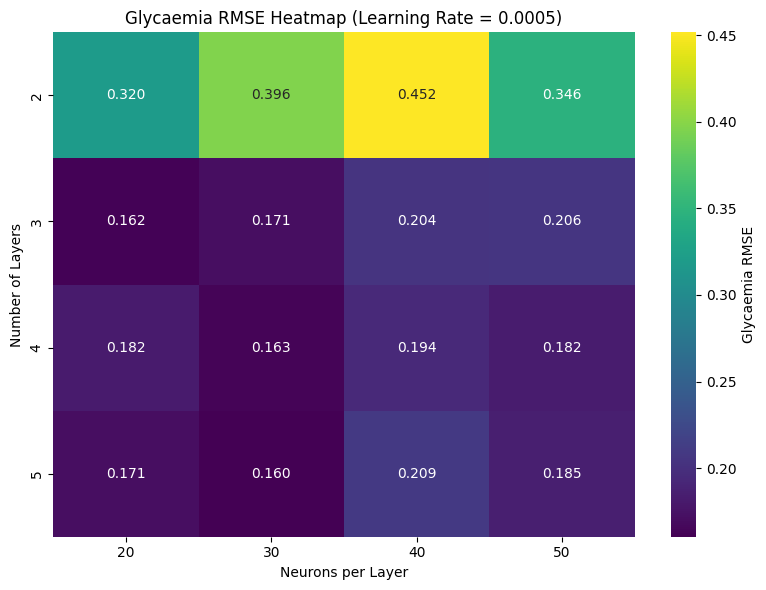

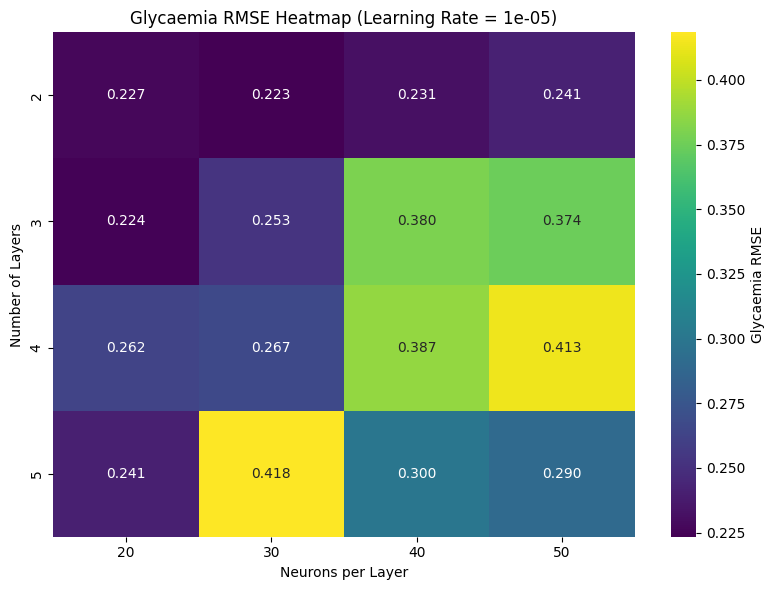

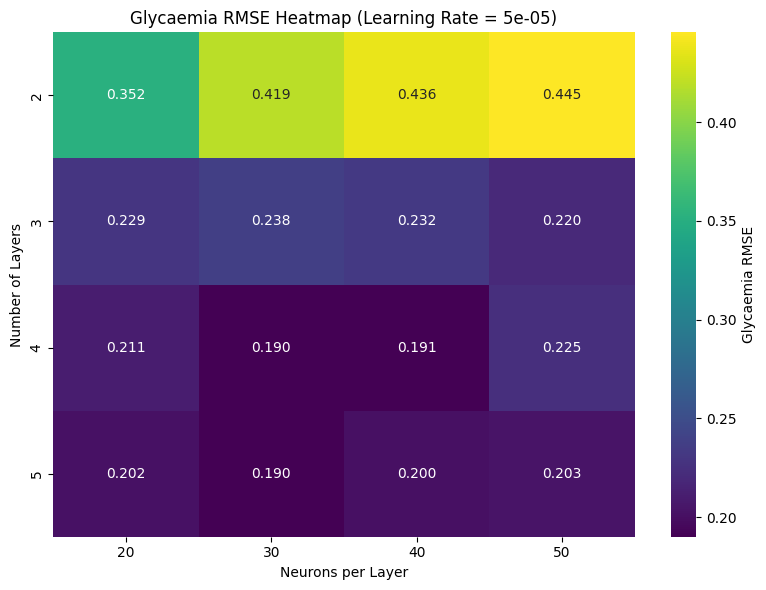

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("PINN_gridsearch_results.csv")

# Loop over each learning rate and plot + save a heatmap
for lr in df["LR"].unique():
    df_lr = df[df["LR"] == lr]
    heatmap_data = df_lr.pivot(index="Layers", columns="Neurons", values="G_RMSE")

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Glycaemia RMSE'})
    plt.title(f"Glycaemia RMSE Heatmap (Learning Rate = {lr})")
    plt.xlabel("Neurons per Layer")
    plt.ylabel("Number of Layers")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"heatmapMODMLP_lr_{lr:.0e}.png", dpi=600)  # e.g., "heatmap_lr_1e-4.png"

    plt.show()
